In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import sys
from tqdm import tqdm
from dataclasses import dataclass
from google.colab import drive
import math
from copy import deepcopy


In [ ]:
!pip install "numpy<2"

In [ ]:
import numpy as np

In [ ]:
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/cs-598-deep-learning-healthcare/SAMIL/processed_data/organized_tmed2.zip -d /content/
!ls /content/organized_tmed2/ | wc -l
!ls /content/organized_tmed2/ | tail


Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/organized_tmed2/589s1/._589s1_110.png  
  inflating: /content/organized_tmed2/589s1/589s1_65.png  
  inflating: /content/__MACOSX/organized_tmed2/589s1/._589s1_65.png  
  inflating: /content/organized_tmed2/589s1/589s1_71.png  
  inflating: /content/__MACOSX/organized_tmed2/589s1/._589s1_71.png  
  inflating: /content/organized_tmed2/589s1/589s1_70.png  
  inflating: /content/__MACOSX/organized_tmed2/589s1/._589s1_70.png  
  inflating: /content/organized_tmed2/589s1/589s1_64.png  
  inflating: /content/__MACOSX/organized_tmed2/589s1/._589s1_64.png  
  inflating: /content/organized_tmed2/589s1/589s1_111.png  
  inflating: /content/__MACOSX/organized_tmed2/589s1/._589s1_111.png  
  inflating: /content/organized_tmed2/589s1/589s1_58.png  
  inflating: /content/__MACOSX/organized_tmed2/589s1/._589s1_58.png  
  inflating: /content/organized_tmed2/589s1/589s1_105.png  
  inflating: /content/__MACOSX/organized_t

In [ ]:
DiagnosisStr_to_Int_Mapping = {
    'no_AS':0,
    'mild_AS':1,
    'mildtomod_AS':1,
    'moderate_AS':2,
    'severe_AS':2
}

class EchoDataset(Dataset):
    '''
        Modified to work with the organized_tmed2 directory where images are already organized by study folders
    '''

    def __init__(self, PatientStudy_list, TMED2SummaryTable, ML_DATA_dir, sampling_strategy='all', training_seed=0, transform_fn=None):

        self.PatientStudy_list = PatientStudy_list
        self.TMED2SummaryTable = TMED2SummaryTable

        # Update this path to point to your organized data
        self.ML_DATA_dir = ML_DATA_dir  # Should be set to '/content/organized_tmed2'
        self.data_root_dir = os.path.join(self.ML_DATA_dir)
        print(self.data_root_dir)

        self.sampling_strategy = sampling_strategy
        self.training_seed = training_seed
        self.transform_fn = transform_fn

        self.bag_of_PatientStudy_images, self.bag_of_PatientStudy_DiagnosisLabels = self._create_bags()

    def _create_bags(self):

        bag_of_PatientStudy_images = []
        bag_of_PatientStudy_DiagnosisLabels = []

        print("Number of patient studies: ", len(self.PatientStudy_list))

        for PatientStudy in self.PatientStudy_list:
            this_PatientStudy_dir = os.path.join(self.data_root_dir, PatientStudy)

            # Get diagnosis label for this PatientStudy
            this_PatientStudyRecords_from_TMED2SummaryTable = self.TMED2SummaryTable[self.TMED2SummaryTable['patient_study']==PatientStudy]
            assert this_PatientStudyRecords_from_TMED2SummaryTable.shape[0]!=0, f'PatientStudy {PatientStudy} not found in TMED2SummaryTable'

            this_PatientStudyRecords_from_TMED2SummaryTable_DiagnosisLabel = list(set(this_PatientStudyRecords_from_TMED2SummaryTable.diagnosis_label.values))
            assert len(this_PatientStudyRecords_from_TMED2SummaryTable_DiagnosisLabel)==1, f'PatientStudy {PatientStudy} has multiple_PatientStudy_DiagnosisLabel'

            this_PatientStudy_DiagnosisLabel = this_PatientStudyRecords_from_TMED2SummaryTable_DiagnosisLabel[0]
            this_PatientStudy_DiagnosisLabel = DiagnosisStr_to_Int_Mapping[this_PatientStudy_DiagnosisLabel]

            all_images_this_PatientStudy = [i for i in os.listdir(this_PatientStudy_dir)
                                           if i.endswith('.png') and '.ipynb_checkpoints' not in i and '.DS_Store' != i]
            # print(f"PatientStudy: {PatientStudy} has {len(all_images_this_PatientStudy)} images")
            # Ensure consistent order
            all_images_this_PatientStudy.sort()

            ## ALWAYS USEW THIS FIRST_FRAME STRATEGY _ MAYBE CHANGE THIS LATER?
            if self.sampling_strategy == 'first_frame':
                bag_of_PatientStudy_DiagnosisLabels.append(this_PatientStudy_DiagnosisLabel)

                this_PatientStudy_images = []

                for image_filename in all_images_this_PatientStudy:
                    image_path = os.path.join(this_PatientStudy_dir, image_filename)

                    assert Image.open(image_path).mode != 'RGB'
                    # Load the image directly using PIL
                    img = np.array(Image.open(image_path))

                    img = img[:, :, None]
                    img = img[:, :, (0, 0, 0)]
                    assert img.shape == (112, 112, 3), "Image [{}]'s size [{}] != [(112, 112, 3)]".format(image_filename, img.shape)

                    this_PatientStudy_images.append(img)

                this_PatientStudy_images = np.array(this_PatientStudy_images)
                if (len(this_PatientStudy_images) == 0):
                    print("PatientStudy_images len is 0 for PatientStudy with Patient Directory", PatientStudy, this_PatientStudy_dir)

                bag_of_PatientStudy_images.append(this_PatientStudy_images)

            elif self.sampling_strategy == 'subset':
                # Sample a subset of images if there are too many
                bag_of_PatientStudy_DiagnosisLabels.append(this_PatientStudy_DiagnosisLabel)

                # If there are more than 20 images, randomly sample 20
                if len(all_images_this_PatientStudy) > 20:
                    random.seed(self.training_seed)
                    selected_images = random.sample(all_images_this_PatientStudy, 20)
                else:
                    selected_images = all_images_this_PatientStudy

                this_PatientStudy_images = []

                for image_filename in selected_images:
                    image_path = os.path.join(this_PatientStudy_dir, image_filename)
                    img = np.array(Image.open(image_path))
                    this_PatientStudy_images.append(img)

                this_PatientStudy_images = np.array(this_PatientStudy_images)
                bag_of_PatientStudy_images.append(this_PatientStudy_images)

            else:
                # Sample multiple times to create multiple bags
                for i in range(int(self.sampling_strategy)):
                    bag_of_PatientStudy_DiagnosisLabels.append(this_PatientStudy_DiagnosisLabel)

                    # Randomly sample images for each bag
                    random.seed(self.training_seed + i)  # Different seed for each bag

                    # Sample min(10, total_images) images for each bag
                    num_to_sample = min(10, len(all_images_this_PatientStudy))
                    selected_images = random.sample(all_images_this_PatientStudy, num_to_sample)

                    this_PatientStudy_images = []

                    for image_filename in selected_images:
                        image_path = os.path.join(this_PatientStudy_dir, image_filename)
                        img = np.array(Image.open(image_path))
                        this_PatientStudy_images.append(img)

                    this_PatientStudy_images = np.array(this_PatientStudy_images)
                    bag_of_PatientStudy_images.append(this_PatientStudy_images)

        return bag_of_PatientStudy_images, bag_of_PatientStudy_DiagnosisLabels

    def __len__(self):
        return len(self.bag_of_PatientStudy_images)

    def __getitem__(self, index):
        bag_image = self.bag_of_PatientStudy_images[index]
        assert len(bag_image) != 0, f"bag_image is empty for index {index}"

        if self.transform_fn is not None:
            bag_image = torch.stack([self.transform_fn(Image.fromarray(image)) for image in bag_image])

        DiagnosisLabel = self.bag_of_PatientStudy_DiagnosisLabels[index]
        return bag_image, DiagnosisLabel


In [ ]:
#checked
def save_checkpoint(state, checkpoint_dir, filename='last_checkpoint.pth.tar'):
    '''last_checkpoint.pth.tar or xxx_model_best.pth.tar'''

    filepath = os.path.join(checkpoint_dir, filename)
    torch.save(state, filepath)


#checked
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)



#learning rate schedule
def get_cosine_schedule_with_warmup(optimizer,
                                    lr_warmup_epochs,
                                    lr_cycle_epochs, #total train epochs
                                    num_cycles=7./16.,
                                    last_epoch=-1):
    def _lr_lambda(current_epoch):
        if current_epoch < lr_warmup_epochs:
            return float(current_epoch) / float(max(1, lr_warmup_epochs))
#         no_progress = float(current_epoch - lr_warmup_epochs) / \
#             float(max(1, float(lr_cycle_epochs) - lr_warmup_epochs))

        #see if using restart
        ###############################################################
        if current_epoch%lr_cycle_epochs==0:
            current_cycle_epoch=lr_cycle_epochs
        else:
            current_cycle_epoch = current_epoch%lr_cycle_epochs

        no_progress = float(current_cycle_epoch - lr_warmup_epochs) / \
            float(max(1, float(lr_cycle_epochs) - lr_warmup_epochs))
        #################################################################

        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)


def get_fixed_lr(optimizer,
                lr_warmup_epochs,
                lr_cycle_epochs, #total train iterations
                num_cycles=7./16.,
                last_epoch=-1):
    def _lr_lambda(current_epoch):

        return 1.0

    return LambdaLR(optimizer, _lr_lambda, last_epoch)

In [ ]:
from dataclasses import dataclass
import os
import torch

@dataclass
class TrainingConfig:
    patience=200
    batch_size=1
    num_workers=2
    dataset_name='echo'
    training_seed=0
    development_size='DEV479'
    train_epoch=400
    start_epoch=0
    eval_every_Xepoch=1
    script="src.SAMIL.main"
    use_data_normalization=False
    augmentation='RandAug'
    sampling_strategy='first_frame'
    use_class_weights=True
    class_weights = [0.25, 0.25, 0.25]
    Pretrained='Whole'
    data_seed = 0
    ViewRegularization_warmup_schedule_type='Linear'
    ViewRegularization_warmup_pos = 0.4
    optimizer_type='SGD'
    nesterov = "store_true"
    lr_schedule_type='CosineLR'
    lr_warmup_epochs = 0
    lr_cycle_epochs=5
    assert torch.cuda.is_available(), "Need GPU"
    device = torch.device("cuda")
    ema_decay = 0.999
    lr=0.000005
    wd=0.0001
    lambda_ViewRegularization=20
    T=0.05
    root_data: str = "/content/organized_tmed2"
    data_dir = root_data
    root_code_checkpoints: str = "/content/drive/MyDrive/cs-598-deep-learning-healthcare/SAMIL"
    checkpoint_dir = os.path.join(root_code_checkpoints, "/content/drive/MyDrive/cs-598-deep-learning-healthcare/SAMIL/model_checkpoints")
    resume='last_checkpoint.pth.tar'
    resume_checkpoint_fullpath = f"{checkpoint_dir}/{resume}"
    MIL_checkpoint_path = None
    experiment_dir = os.path.join(root_code_checkpoints, "/content/drive/MyDrive/cs-598-deep-learning-healthcare/SAMIL/model_checkpoints/trial6")

    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __post_init__(self):
        self.data_info_dir = os.path.join(self.root_code_checkpoints, "info")
        self.train_study_list_path = os.path.join(self.data_info_dir, "train_studies.csv")
        self.val_study_list_path = os.path.join(self.data_info_dir, "val_studies.csv")
        self.test_study_list_path = os.path.join(self.data_info_dir, "test_studies.csv")
        self.summary_table_path = os.path.join(self.data_info_dir, 'TMED2SummaryTable.csv')

args = TrainingConfig()


In [ ]:
# code in this file is adpated from
# https://github.com/ildoonet/pytorch-randaugment/blob/master/RandAugment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/third_party/auto_augment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/libml/ctaugment.py
import logging
import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

logger = logging.getLogger(__name__)

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
    return augs


# def my_augment_pool():
#     # Test
#     augs = [(AutoContrast, None, None),
#             (Brightness, 1.8, 0.1),
#             (Color, 1.8, 0.1),
#             (Contrast, 1.8, 0.1),
#             (Cutout, 0.2, 0),
#             (Equalize, None, None),
#             (Invert, None, None),
#             (Posterize, 4, 4),
#             (Rotate, 30, 0),
#             (Sharpness, 1.8, 0.1),
#             (ShearX, 0.3, 0),
#             (ShearY, 0.3, 0),
#             (Solarize, 256, 0),
#             (SolarizeAdd, 110, 0),
#             (TranslateX, 0.45, 0),
#             (TranslateY, 0.45, 0)]
#     return augs


# class RandAugmentPC(object):
#     def __init__(self, n, m):
#         assert n >= 1
#         assert 1 <= m <= 10
#         self.n = n
#         self.m = m
#         self.augment_pool = my_augment_pool()

#     def __call__(self, img):
#         ops = random.choices(self.augment_pool, k=self.n)
#         for op, max_v, bias in ops:
#             prob = np.random.uniform(0.2, 0.8)
#             if random.random() + prob >= 1:
#                 img = op(img, v=self.m, max_v=max_v, bias=bias)
#         img = CutoutAbs(img, int(32*0.5))
#         return img


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img


In [ ]:
from torchvision import transforms

def get_transforms(augment=False):
    if augment:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=112, padding=int(112 * 0.125), padding_mode='reflect'),
            RandAugmentMC(n=2, m=10),
            transforms.ToTensor(),
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor()
        ])


In [ ]:
import pandas as pd

train_study_list = pd.read_csv(args.train_study_list_path)['study'].values
val_study_list = pd.read_csv(args.val_study_list_path)['study'].values
test_study_list = pd.read_csv(args.test_study_list_path)['study'].values

summary_table = pd.read_csv(args.summary_table_path)


In [ ]:
train_dataset = EchoDataset(
    train_study_list,
    summary_table,
    args.root_data,
    sampling_strategy=args.sampling_strategy,
    training_seed=args.training_seed,
    transform_fn=get_transforms(augment=True)
)

trainmemory_dataset = EchoDataset(
    train_study_list,
    summary_table,
    args.root_data,
    sampling_strategy=args.sampling_strategy,
    training_seed=args.training_seed,
    transform_fn=get_transforms(augment=False)
)

val_dataset = EchoDataset(
    val_study_list,
    summary_table,
    args.root_data,
    sampling_strategy=args.sampling_strategy,
    training_seed=args.training_seed,
    transform_fn=get_transforms(augment=False)
)

test_dataset = EchoDataset(
    test_study_list,
    summary_table,
    args.root_data,
    sampling_strategy=args.sampling_strategy,
    training_seed=args.training_seed,
    transform_fn=get_transforms(augment=False)
)


/content/organized_tmed2
Number of patient studies:  360
/content/organized_tmed2
Number of patient studies:  360
/content/organized_tmed2
Number of patient studies:  119
/content/organized_tmed2
Number of patient studies:  120


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
trainmemory_loader = DataLoader(trainmemory_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# ADDED DROP OUT LAYERS TO SAMIL MODEL
class SAMIL(nn.Module):
    def __init__(self, num_classes=3):
        super(SAMIL, self).__init__()
        self.L = 500
        self.B = 250
        self.D = 128
        self.K = 1
        self.num_classes = num_classes
        self.dropout_rate = 0.2

        self.feature_extractor_part1 = nn.Sequential(
#             nn.Conv2d(1, 20, kernel_size=5),
            nn.Conv2d(3, 20, kernel_size=5),
            nn.Dropout(self.dropout_rate), # added
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.Dropout(self.dropout_rate), # added
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
             #hz added
            nn.Conv2d(50, 100, kernel_size=5),
            nn.Dropout(self.dropout_rate), # added
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(100, 200, kernel_size=3),
            nn.Dropout(self.dropout_rate), # added
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )

        self.feature_extractor_part2 = nn.Sequential(
#             nn.Linear(50 * 4 * 4, self.L),
            nn.Linear(200 * 4 * 4, self.L),
            nn.Dropout(self.dropout_rate), # added
            nn.ReLU(),
        )

        self.feature_extractor_part3 = nn.Sequential(

            nn.Linear(self.L, self.B),
            nn.ReLU(),
            nn.Linear(self.B, self.L),
            nn.Dropout(self.dropout_rate), # added
            nn.ReLU(),
        )

        self.attention_V = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

#         self.attention_weights = nn.Linear(self.D, self.K)

        self.classifier = nn.Sequential(
#             nn.Linear(self.L*self.K, 1),
            nn.Linear(self.L*self.K, self.num_classes),
#             nn.Sigmoid()
        )

    def forward(self, x):

#         print('Inside forward: input x shape: {}'.format(x.shape))
        x = x.squeeze(0)
#         print('Inside forward: after squeeze x shape: {}'.format(x.shape))

        H = self.feature_extractor_part1(x)
#         print('Inside forward: after feature_extractor_part1 H shape: {}'.format(H.shape))


#         H = H.view(-1, 50 * 4 * 4)
        H = H.view(-1, 200 * 4 * 4)
#         print('Inside forward: after view H shape: {}'.format(H.shape))

        H = self.feature_extractor_part2(H)  # NxL
#         print('Inside forward: after feature_extractor_part2 H shape: {}'.format(H.shape))

        A_V = self.attention_V(H)  # NxK
#         print('Inside forward: A_V is {}, shape: {}'.format(A_V, A_V.shape))

        A_V = torch.transpose(A_V, 1, 0)  # KxN
#         print('Inside forward: A_V is {}, shape: {}'.format(A_V, A_V.shape))

        A_V = F.softmax(A_V, dim=1)  # softmax over N
#         print('Inside forward: A_V (View) is {}, shape: {}'.format(A_V, A_V.shape))


        H = self.feature_extractor_part3(H)

        A_U = self.attention_U(H)  # NxK
#         print('Inside forward: A_U is {}, shape: {}'.format(A_U, A_U.shape))

        A_U = torch.transpose(A_U, 1, 0)  # KxN
#         print('Inside forward: A_U is {}, shape: {}'.format(A_U, A_U.shape))

        A_U = F.softmax(A_U, dim=1)  # softmax over N
#         print('Inside forward: A_U (Diagnosis) is {}, shape: {}'.format(A_U, A_U.shape))

#         A = A_V * A_U
#         print('Inside forward: final A is {}, shape: {}'.format(A, A.shape))
        A = torch.exp(torch.log(A_V) + torch.log(A_U)) #numerically more stable?

        A = A/torch.sum(A)
#         A = F.softmax(A, dim=1)
#         print('Inside forward: final A is {}, shape: {}'.format(A, A.shape))
#         A = self.attention_weights(A_V * A_U) # element wise multiplication # NxK
#         print('Inside forward: A is {}, shape: {}'.format(A, A.shape))

#         A = torch.transpose(A, 1, 0)  # KxN
# #         print('Inside forward: A is {}, shape: {}'.format(A, A.shape))

#         A = F.softmax(A, dim=1)  # softmax over N
# #         print('Inside forward: A is {}, shape: {}'.format(A, A.shape))

        M = torch.mm(A, H)  # KxL #M can be regarded as final representation of this bag
#         print('Inside forward: M is {}, shape: {}'.format(M, M.shape))

        out = self.classifier(M)


        return out, A_V #only view regularize one branch of the attention weights

In [ ]:
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F

logger = logging.getLogger(__name__)


def mish(x):
    """Mish: A Self Regularized Non-Monotonic Neural Activation Function (https://arxiv.org/abs/1908.08681)"""
    return x * torch.tanh(F.softplus(x))


class PSBatchNorm2d(nn.BatchNorm2d):
    """How Does BN Increase Collapsed Neural Network Filters? (https://arxiv.org/abs/2001.11216)"""

    def __init__(self, num_features, alpha=0.1, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True):
        super().__init__(num_features, eps, momentum, affine, track_running_stats)
        self.alpha = alpha

    def forward(self, x):
        return super().forward(x) + self.alpha


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.drop_rate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual

    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, drop_rate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(
            block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, drop_rate, activate_before_residual))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

# args.model_depth = 28
# args.model_width = 2

class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, drop_rate=0.0):
        super(WideResNet, self).__init__()
        channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor, 128*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6 #equivalent to 'repeat' in tf repo
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, channels[0], channels[1], block, 1, drop_rate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(
            n, channels[1], channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(
            n, channels[2], channels[3], block, 2, drop_rate)

        # 4th block (hz added)
        self.block4 = NetworkBlock(
            n, channels[3], channels[4], block, 2, drop_rate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(channels[4], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(channels[4], num_classes)
        self.channels = channels[4]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.channels)
        return self.fc(out)


def build_wideresnet(depth, widen_factor, dropout, num_classes):
    logger.info(f"Model: WideResNet {depth}x{widen_factor}")
    return WideResNet(depth=depth,
                      widen_factor=widen_factor,
                      drop_rate=dropout,
                      num_classes=num_classes)


In [ ]:
def create_view_model(args):
    view_model = build_wideresnet(
        depth=28, widen_factor=2, dropout=0.0, num_classes=3
        )
    print("Total params for View Model: {:.2f}M".format(
        sum(p.numel() for p in view_model.parameters())/1e6))
    #load the saved checkpoint
    assert args.data_seed == 0

    args.view_checkpoint_path = os.path.join(
        args.checkpoint_dir, "view_classifier", f"seed{args.data_seed}_model_best.pth.tar"
        )
    assert torch.cuda.is_available()
    # view_checkpoint = torch.load(
    #     args.view_checkpoint_path, map_location=torch.device('cpu'), weights_only=False
    # )
    # else:

    view_checkpoint = torch.load(args.view_checkpoint_path)

    view_model.load_state_dict(view_checkpoint['ema_state_dict'])
    view_model.eval()
    return view_model


In [ ]:
from copy import deepcopy

import torch

class ModelEMA(object):
    def __init__(self, args, model, decay):
        self.ema = deepcopy(model)
        self.ema.to(args.device)
        self.ema.eval()
        self.decay = decay
        self.ema_has_module = hasattr(self.ema, 'module')
        # Fix EMA. https://github.com/valencebond/FixMatch_pytorch thank you!
        self.param_keys = [k for k, _ in self.ema.named_parameters()]
        self.buffer_keys = [k for k, _ in self.ema.named_buffers()]

        print('self.param_keys: {}'.format(self.param_keys))
        print('self.buffer_keys: {}'.format(self.buffer_keys))

        for p in self.ema.parameters():
#             print('Inside ModelEMA, p dtype is {}'.format(p.dtype))
            p.requires_grad_(False)


    def update(self, model):
        needs_module = hasattr(model, 'module') and not self.ema_has_module
        with torch.no_grad():
            msd = model.state_dict()
            esd = self.ema.state_dict()
            for k in self.param_keys:
                if needs_module:
                    j = 'module.' + k
                else:
                    j = k
                model_v = msd[j].detach()
                ema_v = esd[k]
                esd[k].copy_(ema_v * self.decay + (1. - self.decay) * model_v)

            for k in self.buffer_keys:
                if needs_module:
                    j = 'module.' + k
                else:
                    j = k
                esd[k].copy_(msd[j])


In [ ]:
#regular eval_model
from sklearn.metrics import confusion_matrix as sklearn_cm
def eval_model(args, data_loader, raw_model, ema_model, epoch):

    raw_model.eval()
    ema_model.eval()

    data_loader = tqdm(data_loader, disable=False)

    with torch.no_grad():
        total_targets = []
        total_raw_outputs = []
        total_ema_outputs = []


        for batch_idx, (data, bag_label) in enumerate(data_loader):

#             print('EVAL type(data): {}, data.size: {}, require grad: {}'.format(type(data), data.size(), data.requires_grad))
#             print('EVAL type(bag_label): {}, bag_label: {}'.format(type(bag_label), bag_label))

            data, bag_label = data.to(args.device), bag_label.to(args.device)

            raw_outputs, raw_attention_weights = raw_model(data)
            ema_outputs, ema_attention_weights = ema_model(data)
#             print('target is {}, raw_outputs is: {}, ema_outputs is {}'.format(bag_label, raw_outputs, ema_outputs))

            total_targets.append(bag_label.detach().cpu())
            total_raw_outputs.append(raw_outputs.detach().cpu())
            total_ema_outputs.append(ema_outputs.detach().cpu())


        total_targets = np.concatenate(total_targets, axis=0)
        total_raw_outputs = np.concatenate(total_raw_outputs, axis=0)
        total_ema_outputs = np.concatenate(total_ema_outputs, axis=0)
#         print('RegularEval total_targets: {}'.format(total_targets))
#         print('RegularEval total_raw_outputs: {}'.format(total_raw_outputs))
#         print('RegularEval total_ema_outputs: {}'.format(total_ema_outputs))

        raw_Bacc = calculate_balanced_accuracy(total_raw_outputs, total_targets)
        ema_Bacc = calculate_balanced_accuracy(total_ema_outputs, total_targets)

#         print('raw Bacc this evaluation step: {}'.format(raw_Bacc), flush=True)
#         print('ema Bacc this evaluation step: {}'.format(ema_Bacc), flush=True)


    return raw_Bacc, ema_Bacc, total_targets, total_raw_outputs, total_ema_outputs



def calculate_balanced_accuracy(prediction, true_target, return_type = 'only balanced_accuracy'):

    confusion_matrix = sklearn_cm(true_target, prediction.argmax(1))
    n_class = confusion_matrix.shape[0]
    print('Inside calculate_balanced_accuracy, {} classes passed in'.format(n_class), flush=True)

    assert n_class==3

    recalls = []
    for i in range(n_class):
        recall = confusion_matrix[i,i]/np.sum(confusion_matrix[i])
        recalls.append(recall)
        print('class{} recall: {}'.format(i, recall), flush=True)

    balanced_accuracy = np.mean(np.array(recalls))


    if return_type == 'all':
#         return balanced_accuracy * 100, class0_recall * 100, class1_recall * 100, class2_recall * 100
        return balanced_accuracy * 100, recalls

    elif return_type == 'only balanced_accuracy':
        return balanced_accuracy * 100
    else:
        raise NameError('Unsupported return_type in this calculate_balanced_accuracy fn')

In [ ]:
def train_one_epoch(args, weights, train_loader, model, ema_model, view_model, optimizer, scheduler, epoch):

    # args.writer.add_scalar('train/lr', scheduler.get_last_lr()[0], epoch)
    print("Epoch: ", epoch)
    print("Learning Rate: ", scheduler.get_last_lr()[0])

    model.train()

    TotalLoss_this_epoch, LabeledCELoss_this_epoch, ViewRegularizationLoss_this_epoch, scaled_ViewRegularizationLoss_this_epoch = [], [], [], []

    train_iter = iter(train_loader)
    n_steps_per_epoch = 360 #360 train studies, batch size 1
    p_bar = tqdm(range(n_steps_per_epoch), disable=False)

#     for batch_idx, (data, bag_label, view_relevance) in enumerate(tqdm(train_loader)):
    for batch_idx in range(n_steps_per_epoch):

        try:
            data, bag_label = next(train_iter)
        except:
            train_iter = iter(train_loader)
            data, bag_label = next(train_iter)

#         print('batch_idx: {}'.format(batch_idx))

#         print('type(data): {}, data.size: {}, require grad: {}'.format(type(data), data.size(), data.requires_grad))
#         print('type(bag_label): {}, bag_label: {}'.format(type(bag_label), bag_label))
#         print('type(view_relevance): {}, view_relevance: {}'.format(type(view_relevance), view_relevance))
        data, bag_label = data.to(args.device), bag_label.to(args.device)


        outputs, attentions = model(data)

        log_attentions = torch.log(attentions)


        with torch.no_grad():
            view_predictions = view_model(data.squeeze(0))
            softmax_view_predictions = F.softmax(view_predictions, dim=1)
            predicted_relevance = softmax_view_predictions[:, :2]
            predicted_relevance = torch.sum(predicted_relevance, dim=1)
            predicted_relative_relevance = F.softmax(predicted_relevance/args.T, dim=0)
            predicted_relative_relevance = predicted_relative_relevance.unsqueeze(0)


        #element shape in F.cross_entropy: prediction torch.size([batch_size, num_classes]) and true label torch.size([batch_size])
        if args.use_class_weights:
            LabeledCELoss = F.cross_entropy(outputs, bag_label, weights, reduction='mean')
        else:
            LabeledCELoss = F.cross_entropy(outputs, bag_label, reduction='mean')


#         parser.add_argument('--ViewRegularization_warmup_pos', default=0.4, type=float, help='position at which view regularization loss warmup ends') #following MixMatch and FixMatch repo

# parser.add_argument('--ViewRegularization_warmup_schedule_type', default='NoWarmup', choices=['NoWarmup', 'Linear', 'Sigmoid', ], type=str)

        #ViewRegularization warmup schedule choice
        if args.ViewRegularization_warmup_schedule_type == 'NoWarmup':
            current_warmup = 1
        elif args.ViewRegularization_warmup_schedule_type == 'Linear':
            current_warmup = np.clip(epoch/(float(args.ViewRegularization_warmup_pos) * args.train_epoch), 0, 1)
        elif args.ViewRegularization_warmup_schedule_type == 'Sigmoid':
            current_warmup = math.exp(-5 * (1 - min(epoch/(float(args.ViewRegularization_warmup_pos) * args.train_epoch), 1))**2)
        else:
            raise NameError('Not supported ViewRegularization warmup schedule')



        ViewRegularizationLoss = F.kl_div(input=log_attentions, target=predicted_relative_relevance, log_target=False, reduction='batchmean')

        # backward pass
        # assert current_warmup == 1
        # assert args.lambda_ViewRegularization == 20

        total_loss = LabeledCELoss + args.lambda_ViewRegularization * ViewRegularizationLoss * current_warmup
        # total_loss = LabeledCELoss <- used in trial 1 with last_checkpoint
        # total_loss = LabeledCELoss + ViewRegularizationLoss <- used in trial 3 with last_checkpoint

        total_loss.backward()



        TotalLoss_this_epoch.append(total_loss.item())
        LabeledCELoss_this_epoch.append(LabeledCELoss.item())
        ViewRegularizationLoss_this_epoch.append(ViewRegularizationLoss.item())
        scaled_ViewRegularizationLoss_this_epoch.append(args.lambda_ViewRegularization * ViewRegularizationLoss.item() * current_warmup)

        # step
        optimizer.step()

        #update ema model
        ema_model.update(model)

        model.zero_grad()

    scheduler.step()

    return TotalLoss_this_epoch, LabeledCELoss_this_epoch, ViewRegularizationLoss_this_epoch, scaled_ViewRegularizationLoss_this_epoch


In [ ]:
import csv
def write_row_to_csv(filename, row_data):
    """Writes a row of data to a CSV file.

    Args:
        filename: The name of the CSV file.
        row_data: A list of data to write to the row.
    """

    # Check if file exists, create if not
    assert os.path.isfile(filename)
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(row_data)

In [ ]:
# Data to Plot
train_bacc_results = os.path.join(args.experiment_dir, "train_bacc_extension.csv")
val_bacc_results = os.path.join(args.experiment_dir, "val_bacc_extension.csv")
test_bacc_results = os.path.join(args.experiment_dir, "test_bacc_extension.csv")
loss_results = os.path.join(args.experiment_dir, "loss_results_extension.csv")


# Create empty CSVs for DataFrames
with open(train_bacc_results, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["step", "raw_bacc", "ema_bacc"])  # Write header row

with open(val_bacc_results, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["step", "raw_bacc", "ema_bacc"])  # Write header row

with open(test_bacc_results, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["step", "raw_bacc", "ema_bacc"])  # Write header row

with open(loss_results, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['step', 'MeanTotalloss', 'MeanLabeledCEloss', 'MeanViewRegularizationLoss'])  # Write header row


In [ ]:
def plot():
    val_bacc_df = pd.read_csv(val_bacc_results)
    test_bacc_df = pd.read_csv(test_bacc_results)
    train_bacc_df = pd.read_csv(train_bacc_results)
    loss_df = pd.read_csv(loss_results)

    plt.figure(figsize=(20, 5))

    ax = plt.subplot(1, 4, 1)
    ax.set_title("Validation Balance Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Raw Balance Accuracy")
    plt.plot(val_bacc_df["step"], val_bacc_df["raw_bacc"], linewidth=2)

    ax = plt.subplot(1, 4, 2)
    ax.set_title("Test Balance Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Raw Balance Accuracy")
    plt.plot(test_bacc_df["step"], test_bacc_df["raw_bacc"], linewidth=2)

    ax = plt.subplot(1, 4, 3)
    ax.set_title("Train Balance Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Raw Balance Accuracy")
    plt.plot(train_bacc_df["step"], train_bacc_df["raw_bacc"], linewidth=2)

    ax = plt.subplot(1, 4, 4)
    ax.set_title("Total Loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    plt.plot(loss_df["step"], loss_df["MeanTotalloss"], linewidth=2)

    plt.show()
    print("Max Validation Balance Accuracy -", round(max(val_bacc_df["raw_bacc"]), 1) )
    print("Max Test Balance Accuracy -", round(max(test_bacc_df["raw_bacc"]), 1) )
    print("Min Total Loss -", round(min(loss_df["MeanTotalloss"]), 1) )

In [ ]:
def create_model(args):
    model = SAMIL()

    if args.MIL_checkpoint_path !='':
        print('!!!!!!!!!!!!!!!!!!!!!initializing from pretrained checkpoint!!!!!!!!!!!!!!!!!!!!!')
        pretrained_dict = torch.load(args.MIL_checkpoint_path, map_location=torch.device('cpu'))

        #https://discuss.pytorch.org/t/dataparallel-changes-parameter-names-issue-with-load-state-dict/60211
        #rename tensor in the pretrained dict
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in pretrained_dict.items():
#                         print(k)
            if 'encoder_q' in k:
#                             print('!extract: {}'.format(k))
                name = '.'.join(k.split('.')[1:])
#                             print('new_name: {}'.format(name))
                new_state_dict[name] = v

        model_dict = model.state_dict()

        new_state_dict = {k: v for k, v in new_state_dict.items() if k in model_dict}
        model_dict.update(new_state_dict)

        # 3. load the new state dict
        model.load_state_dict(model_dict)



    logger.info("Total params: {:.2f}M".format(
        sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6))

    return model

In [ ]:
def train_model(args):

  if args.training_seed is not None:
          print('setting training seed{}'.format(args.training_seed), flush=True)
          set_seed(args.training_seed)

  if args.Pretrained == 'Whole':
      if args.data_seed==0:
          args.MIL_checkpoint_path = os.path.join(args.checkpoint_dir,'MOCO_Pretraining_StudyLevel', 'seed0_checkpoint.pt')
      elif args.data_seed==1:
          args.MIL_checkpoint_path = os.path.join(args.checkpoint_dir,'MOCO_Pretraining_StudyLevel', 'seed1_checkpoint.pt')
      elif args.data_seed==2:
          args.MIL_checkpoint_path = os.path.join(args.checkpoint_dir,'MOCO_Pretraining_StudyLevel', 'seed2_checkpoint.pt')
      else:
          raise NameError('NOT VALID PRETRAINED MODEL')


  if args.use_class_weights:
    print("We are using class weights")
    assert args.data_seed == 0 and args.development_size == 'DEV479'
    args.class_weights = [0.463, 0.342, 0.195]

  weights = args.class_weights
  weights = torch.Tensor(weights)
  weights = weights.to(args.device)

  print("Sending to:", args.device)

  view_model = create_view_model(args)
  view_model.to(args.device)

  model = create_model(args)
  model.to(args.device)

  no_decay = ['bias', 'bn']
  grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(
          nd in n for nd in no_decay)], 'weight_decay': args.wd},
      {'params': [p for n, p in model.named_parameters() if any(
          nd in n for nd in no_decay)], 'weight_decay': 0.0}
  ]

  if args.optimizer_type == 'SGD':

    optimizer = optim.SGD(grouped_parameters, lr=args.lr,
                          momentum=0.9, nesterov=args.nesterov)

  elif args.optimizer_type == 'Adam':
      optimizer = optim.Adam(grouped_parameters, lr=args.lr)
  #         optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.999), weight_decay=args.reg)

  elif args.optimizer_type == 'AdamW':
      optimizer = optim.AdamW(grouped_parameters, lr=args.lr)

  else:
      raise NameError('Not supported optimizer setting')


      #lr_schedule_type choice
  if args.lr_schedule_type == 'CosineLR':
      scheduler = get_cosine_schedule_with_warmup(optimizer, args.lr_warmup_epochs, args.lr_cycle_epochs)

  elif args.lr_schedule_type == 'FixedLR':
      scheduler = get_fixed_lr(optimizer, args.lr_warmup_epochs, args.lr_cycle_epochs)

  else:
      raise NameError('Not supported lr scheduler setting')

  assert optimizer is not None and scheduler is not None

  ema_model = ModelEMA(args, model, args.ema_decay)

  best_val_ema_Bacc = 0
  best_test_ema_Bacc_at_val = 0
  best_train_ema_Bacc_at_val = 0

  best_val_raw_Bacc = 0
  best_test_raw_Bacc_at_val = 0
  best_train_raw_Bacc_at_val = 0

  current_count=0 #for early stopping, when continue training
    #if continued from a checkpoint, overwrite the best_val_ema_Bacc, best_test_ema_Bacc_at_val,
    #                                              best_val_raw_Bacc, best_test_raw_Bacc_at_val,
    #                                              start_epoch,
    #                                              model weights, ema model weights
    #                                              optimizer state dict
    #                                              scheduler state dict

#   if os.path.isfile(args.resume_checkpoint_fullpath):
# #         logger.info("==> Resuming from checkpoint..")
#       print('Resuming from checkpoint: {}'.format(args.resume_checkpoint_fullpath))

#       checkpoint = torch.load(args.resume_checkpoint_fullpath, map_location=torch.device('cpu'))
#       args.start_epoch = checkpoint['epoch']
#       model.load_state_dict(checkpoint['state_dict'])
#       ema_model.ema.load_state_dict(checkpoint['ema_state_dict'])
#       current_count = checkpoint['current_count']
#       optimizer.load_state_dict(checkpoint['optimizer'])
#       scheduler.load_state_dict(checkpoint['scheduler'])

#       #val progression view
#       #regular val
#       best_val_ema_Bacc = checkpoint['val_progression_view']['best_val_ema_Bacc']
#       best_test_ema_Bacc_at_val = checkpoint['val_progression_view']['best_test_ema_Bacc_at_val']
#       best_train_ema_Bacc_at_val = checkpoint['val_progression_view']['best_train_ema_Bacc_at_val']

#       best_val_raw_Bacc = checkpoint['val_progression_view']['best_val_raw_Bacc']
#       best_test_raw_Bacc_at_val = checkpoint['val_progression_view']['best_test_raw_Bacc_at_val']
#       best_train_raw_Bacc_at_val = checkpoint['val_progression_view']['best_train_raw_Bacc_at_val']
#   else:
#       print("No checkpoint found")


  print("Start and End Epoch: ", args.start_epoch, args.train_epoch)

  train_loss_dict = dict()
  train_loss_dict['Totalloss'] = []
  train_loss_dict['LabeledCEloss'] = []
  train_loss_dict['ViewRegularizationLoss'] = []

  for epoch in tqdm(range(args.start_epoch, args.train_epoch), disable=True):
      val_predictions_save_dict = dict()
      test_predictions_save_dict = dict()
      train_predictions_save_dict = dict()

      TotalLoss_list, LabeledCEloss_list, ViewRegularizationLoss_list, scaled_ViewRegularizationLoss_list = train_one_epoch(args, weights, train_loader, model, ema_model, view_model, optimizer, scheduler, epoch)
      train_loss_dict['Totalloss'].extend(TotalLoss_list)
      train_loss_dict['LabeledCEloss'].extend(LabeledCEloss_list)
      train_loss_dict['ViewRegularizationLoss'].extend(ViewRegularizationLoss_list)
#         save_pickle(os.path.join(args.experiment_dir, 'losses'), 'train_losses_dict.pkl', train_loss_dict)

      if epoch % args.eval_every_Xepoch == 0:
          val_raw_Bacc, val_ema_Bacc, val_true_labels, val_raw_predictions, val_ema_predictions = eval_model(args, val_loader, model, ema_model.ema, epoch)
          val_predictions_save_dict['raw_Bacc'] = val_raw_Bacc
          val_predictions_save_dict['ema_Bacc'] = val_ema_Bacc
          val_predictions_save_dict['true_labels'] = val_true_labels
          val_predictions_save_dict['raw_predictions'] = val_raw_predictions
          val_predictions_save_dict['ema_predictions'] = val_ema_predictions

#             save_pickle(os.path.join(args.experiment_dir, 'predictions'), 'val_epoch_{}_predictions.pkl'.format(str(epoch)), val_predictions_save_dict)

          test_raw_Bacc, test_ema_Bacc, test_true_labels, test_raw_predictions, test_ema_predictions = eval_model(args, test_loader, model, ema_model.ema, epoch)

          test_predictions_save_dict['raw_Bacc'] = test_raw_Bacc
          test_predictions_save_dict['ema_Bacc'] = test_ema_Bacc
          test_predictions_save_dict['true_labels'] = test_true_labels
          test_predictions_save_dict['raw_predictions'] = test_raw_predictions
          test_predictions_save_dict['ema_predictions'] = test_ema_predictions


#             save_pickle(os.path.join(args.experiment_dir, 'predictions'), 'test_epoch_{}_predictions.pkl'.format(str(epoch)), test_predictions_save_dict)

          train_raw_Bacc, train_ema_Bacc, train_true_labels, train_raw_predictions, train_ema_predictions = eval_model(args, trainmemory_loader, model, ema_model.ema, epoch)

          train_predictions_save_dict['raw_Bacc'] = train_raw_Bacc
          train_predictions_save_dict['ema_Bacc'] = train_ema_Bacc
          train_predictions_save_dict['true_labels'] = train_true_labels
          train_predictions_save_dict['raw_predictions'] = train_raw_predictions
          train_predictions_save_dict['ema_predictions'] = train_ema_predictions

#             save_pickle(os.path.join(args.experiment_dir, 'predictions'), 'train_epoch_{}_predictions.pkl'.format(str(epoch)), train_predictions_save_dict)

          # WRITE TO CSV
          write_row_to_csv(train_bacc_results, [epoch, train_raw_Bacc, train_ema_Bacc])
          write_row_to_csv(val_bacc_results, [epoch, val_raw_Bacc, val_ema_Bacc])
          write_row_to_csv(test_bacc_results, [epoch, test_raw_Bacc, test_ema_Bacc])
          write_row_to_csv(loss_results, [epoch, np.mean(TotalLoss_list), np.mean(LabeledCEloss_list), np.mean(ViewRegularizationLoss_list)])

          #val progression view
          #regular Val
          if val_raw_Bacc > best_val_raw_Bacc:

              best_val_raw_Bacc = val_raw_Bacc
              best_test_raw_Bacc_at_val = test_raw_Bacc
              best_train_raw_Bacc_at_val = train_raw_Bacc

              # save_pickle(os.path.join(args.experiment_dir, 'val_progression_view', 'best_predictions_at_raw_val'), 'val_predictions.pkl', val_predictions_save_dict)

              # save_pickle(os.path.join(args.experiment_dir, 'val_progression_view', 'best_predictions_at_raw_val'), 'test_predictions.pkl', test_predictions_save_dict)


              # save_pickle(os.path.join(args.experiment_dir, 'val_progression_view', 'best_predictions_at_raw_val'), 'train_predictions.pkl', train_predictions_save_dict)

              save_checkpoint(
              {
              'epoch': epoch+1,
              'state_dict': model.state_dict(),
              'ema_state_dict': ema_model.ema.state_dict(),
              'current_count':current_count,
              'optimizer': optimizer.state_dict(),
              'scheduler': scheduler.state_dict(),

              'val_progression_view':
                  {'epoch': epoch+1,
                  #regular val
                  'best_val_ema_Bacc': best_val_ema_Bacc,
                  'best_val_raw_Bacc': best_val_raw_Bacc,
                  'best_test_ema_Bacc_at_val': best_test_ema_Bacc_at_val,
                  'best_test_raw_Bacc_at_val': best_test_raw_Bacc_at_val,
                  'best_train_ema_Bacc_at_val': best_train_ema_Bacc_at_val,
                  'best_train_raw_Bacc_at_val': best_train_raw_Bacc_at_val,
                    },

              }, args.experiment_dir, filename='best_model_at_raw_val.pth.tar')



          if val_ema_Bacc > best_val_ema_Bacc:

              best_val_ema_Bacc = val_ema_Bacc
              best_test_ema_Bacc_at_val = test_ema_Bacc
              best_train_ema_Bacc_at_val = train_ema_Bacc

              # save_pickle(os.path.join(args.experiment_dir, 'val_progression_view', 'best_predictions_at_ema_val'), 'val_predictions.pkl', val_predictions_save_dict)

              # save_pickle(os.path.join(args.experiment_dir, 'val_progression_view', 'best_predictions_at_ema_val'), 'test_predictions.pkl', test_predictions_save_dict)

              # save_pickle(os.path.join(args.experiment_dir, 'val_progression_view', 'best_predictions_at_ema_val'), 'train_predictions.pkl', train_predictions_save_dict)

              save_checkpoint(
              {
              'epoch': epoch+1,
              'state_dict': model.state_dict(),
              'ema_state_dict': ema_model.ema.state_dict(),
              'current_count':current_count,
              'optimizer': optimizer.state_dict(),
              'scheduler': scheduler.state_dict(),

              'val_progression_view':
                  {'epoch': epoch+1,
                  #regular val
                  'best_val_ema_Bacc': best_val_ema_Bacc,
                  'best_val_raw_Bacc': best_val_raw_Bacc,
                  'best_test_ema_Bacc_at_val': best_test_ema_Bacc_at_val,
                  'best_test_raw_Bacc_at_val': best_test_raw_Bacc_at_val,
                  'best_train_ema_Bacc_at_val': best_train_ema_Bacc_at_val,
                  'best_train_raw_Bacc_at_val': best_train_raw_Bacc_at_val,
                    },

              }, args.experiment_dir, filename='best_model_at_ema_val.pth.tar')



          #val progression view
          logger.info('val progression view:')
          #regular val
          logger.info('At RAW Best val, validation/test/train %.2f %.2f %.2f' % (best_val_raw_Bacc, best_test_raw_Bacc_at_val, best_train_raw_Bacc_at_val))
          logger.info('At EMA Best val, validation/test/train %.2f %.2f %.2f' % (best_val_ema_Bacc, best_test_ema_Bacc_at_val, best_train_ema_Bacc_at_val))

      if epoch % 5 == 0:
          plot()


setting training seed0
We are using class weights
Sending to: cuda
Total params for View Model: 5.93M
!!!!!!!!!!!!!!!!!!!!!initializing from pretrained checkpoint!!!!!!!!!!!!!!!!!!!!!
self.param_keys: ['feature_extractor_part1.0.weight', 'feature_extractor_part1.0.bias', 'feature_extractor_part1.4.weight', 'feature_extractor_part1.4.bias', 'feature_extractor_part1.8.weight', 'feature_extractor_part1.8.bias', 'feature_extractor_part1.12.weight', 'feature_extractor_part1.12.bias', 'feature_extractor_part2.0.weight', 'feature_extractor_part2.0.bias', 'feature_extractor_part3.0.weight', 'feature_extractor_part3.0.bias', 'feature_extractor_part3.2.weight', 'feature_extractor_part3.2.bias', 'attention_V.0.weight', 'attention_V.0.bias', 'attention_V.2.weight', 'attention_V.2.bias', 'attention_U.0.weight', 'attention_U.0.bias', 'attention_U.2.weight', 'attention_U.2.bias', 'classifier.0.weight', 'classifier.0.bias']
self.buffer_keys: []
Start and End Epoch:  0 2000
Epoch:  0
Learning Rate:  9.





  0%|          | 0/360 [00:00<?, ?it/s]




  0%|          | 0/360 [00:52<?, ?it/s]





  1%|          | 1/119 [00:00<01:02,  1.90it/s]




  3%|▎         | 4/119 [00:00<00:18,  6.32it/s]




  5%|▌         | 6/119 [00:00<00:12,  8.82it/s]




  8%|▊         | 9/119 [00:00<00:08, 13.18it/s]




  9%|▉         | 11/119 [00:01<00:07, 14.46it/s]




 13%|█▎        | 15/119 [00:01<00:05, 19.95it/s]




 15%|█▌        | 18/119 [00:01<00:04, 21.56it/s]




 18%|█▊        | 21/119 [00:01<00:04, 21.22it/s]




 21%|██        | 25/119 [00:01<00:03, 24.23it/s]




 24%|██▍       | 29/119 [00:01<00:03, 26.46it/s]




 27%|██▋       | 32/119 [00:01<00:03, 23.88it/s]




 29%|██▉       | 35/119 [00:02<00:03, 22.92it/s]




 33%|███▎      | 39/119 [00:02<00:03, 26.22it/s]




 35%|███▌      | 42/119 [00:02<00:02, 26.94it/s]




 39%|███▊      | 46/119 [00:02<00:02, 28.07it/s]




 41%|████      | 49/119 [00:02<00:02, 27.81it/s]




 44%|████▎     | 52/119 [00:02<00:02, 26.68it/s]




 46%|████▌

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.0
class2 recall: 0.0







  0%|          | 0/120 [00:00<?, ?it/s]



  1%|          | 1/120 [00:00<00:32,  3.62it/s]



  5%|▌         | 6/120 [00:00<00:06, 18.96it/s]



  8%|▊         | 10/120 [00:00<00:04, 24.52it/s]



 12%|█▎        | 15/120 [00:00<00:03, 30.87it/s]



 16%|█▌        | 19/120 [00:00<00:03, 32.85it/s]



 21%|██        | 25/120 [00:00<00:02, 37.92it/s]



 25%|██▌       | 30/120 [00:00<00:02, 40.43it/s]



 29%|██▉       | 35/120 [00:01<00:01, 42.70it/s]



 33%|███▎      | 40/120 [00:01<00:01, 40.87it/s]



 38%|███▊      | 45/120 [00:01<00:01, 41.30it/s]



 42%|████▏     | 50/120 [00:01<00:01, 41.90it/s]



 46%|████▌     | 55/120 [00:01<00:01, 43.09it/s]



 50%|█████     | 60/120 [00:01<00:01, 42.27it/s]



 54%|█████▍    | 65/120 [00:01<00:01, 40.79it/s]



 58%|█████▊    | 70/120 [00:01<00:01, 41.76it/s]



 62%|██████▎   | 75/120 [00:02<00:01, 42.71it/s]



 67%|██████▋   | 80/120 [00:02<00:00, 41.33it/s]



 71%|███████   | 85/120 [00:02<00:00, 38.92it/s]



 74%|███████▍  | 8

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.0
class2 recall: 0.0







  0%|          | 0/360 [00:00<?, ?it/s]



  0%|          | 1/360 [00:00<01:38,  3.63it/s]



  1%|          | 3/360 [00:00<00:39,  9.03it/s]



  2%|▏         | 7/360 [00:00<00:19, 18.55it/s]



  4%|▎         | 13/360 [00:00<00:11, 30.12it/s]



  5%|▌         | 18/360 [00:00<00:09, 35.43it/s]



  6%|▌         | 22/360 [00:00<00:09, 35.38it/s]



  8%|▊         | 27/360 [00:00<00:08, 37.62it/s]



  9%|▉         | 32/360 [00:01<00:08, 40.16it/s]



 10%|█         | 37/360 [00:01<00:07, 41.84it/s]



 12%|█▏        | 42/360 [00:01<00:07, 40.65it/s]



 13%|█▎        | 47/360 [00:01<00:07, 40.39it/s]



 14%|█▍        | 52/360 [00:01<00:07, 41.78it/s]



 16%|█▌        | 58/360 [00:01<00:06, 44.75it/s]



 18%|█▊        | 64/360 [00:01<00:06, 48.00it/s]



 19%|█▉        | 69/360 [00:01<00:06, 46.36it/s]



 21%|██        | 74/360 [00:01<00:06, 43.67it/s]



 22%|██▏       | 80/360 [00:02<00:05, 46.90it/s]



 24%|██▎       | 85/360 [00:02<00:06, 42.18it/s]



 25%|██▌       | 90

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.0
class2 recall: 0.0


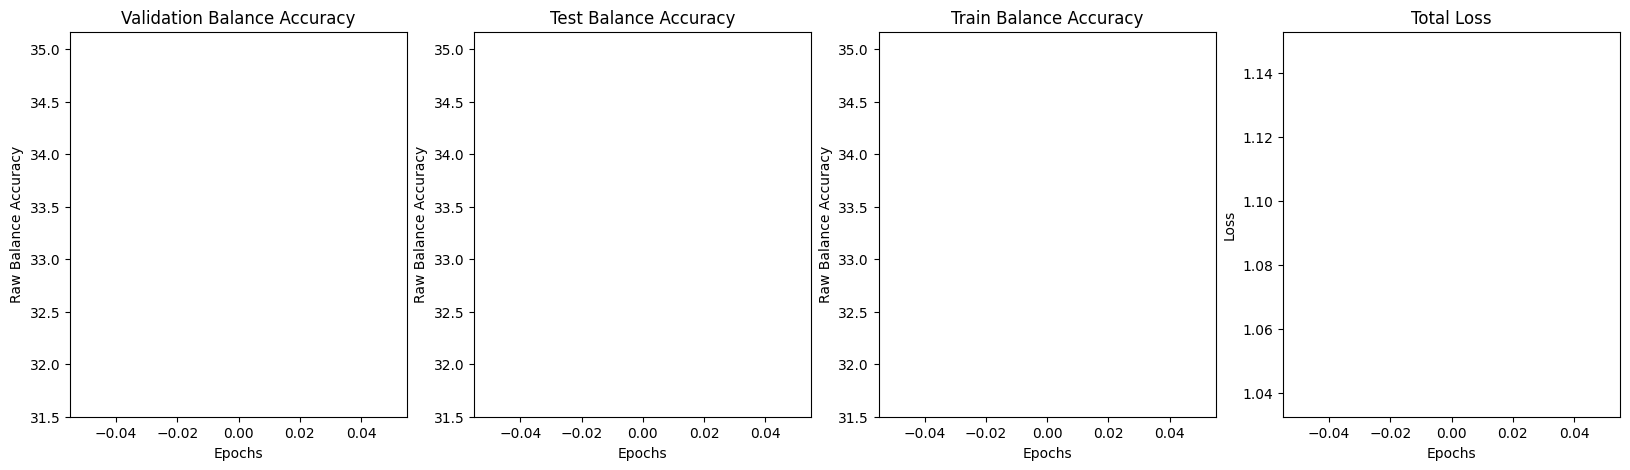

Max Validation Balance Accuracy - 33.3
Max Test Balance Accuracy - 33.3
Min Total Loss - 1.1
Epoch:  1
Learning Rate:  0.0004998111014986735






  0%|          | 0/360 [00:52<?, ?it/s]




  0%|          | 0/119 [00:00<?, ?it/s]



  1%|          | 1/119 [00:00<00:42,  2.76it/s]



  4%|▍         | 5/119 [00:00<00:09, 12.51it/s]



  7%|▋         | 8/119 [00:00<00:06, 17.29it/s]



 10%|█         | 12/119 [00:00<00:04, 22.82it/s]



 14%|█▍        | 17/119 [00:00<00:03, 29.19it/s]



 18%|█▊        | 21/119 [00:00<00:03, 30.90it/s]



 21%|██        | 25/119 [00:01<00:02, 32.79it/s]



 25%|██▌       | 30/119 [00:01<00:02, 34.96it/s]



 29%|██▊       | 34/119 [00:01<00:02, 34.26it/s]



 33%|███▎      | 39/119 [00:01<00:02, 37.68it/s]



 37%|███▋      | 44/119 [00:01<00:01, 40.30it/s]



 41%|████      | 49/119 [00:01<00:01, 40.13it/s]



 45%|████▌     | 54/119 [00:01<00:01, 38.23it/s]



 50%|████▉     | 59/119 [00:01<00:01, 40.86it/s]



 54%|█████▍    | 64/119 [00:01<00:01, 42.34it/s]



 58%|█████▊    | 69/119 [00:02<00:01, 38.62it/s]



 62%|██████▏   | 74/119 [00:02<00:01, 40.83it/s]



 66%|██████▋   | 79/119 [00:

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0







  0%|          | 0/120 [00:00<?, ?it/s]



  1%|          | 1/120 [00:00<00:34,  3.45it/s]



  5%|▌         | 6/120 [00:00<00:06, 18.76it/s]



  9%|▉         | 11/120 [00:00<00:04, 26.36it/s]



 12%|█▎        | 15/120 [00:00<00:03, 30.19it/s]



 16%|█▌        | 19/120 [00:00<00:03, 31.78it/s]



 20%|██        | 24/120 [00:00<00:02, 36.91it/s]



 24%|██▍       | 29/120 [00:00<00:02, 38.33it/s]



 28%|██▊       | 34/120 [00:01<00:02, 41.52it/s]



 32%|███▎      | 39/120 [00:01<00:02, 39.97it/s]



 37%|███▋      | 44/120 [00:01<00:01, 40.70it/s]



 41%|████      | 49/120 [00:01<00:01, 41.80it/s]



 45%|████▌     | 54/120 [00:01<00:01, 42.00it/s]



 49%|████▉     | 59/120 [00:01<00:01, 41.50it/s]



 53%|█████▎    | 64/120 [00:01<00:01, 41.12it/s]



 57%|█████▊    | 69/120 [00:01<00:01, 39.99it/s]



 62%|██████▏   | 74/120 [00:02<00:01, 40.89it/s]



 66%|██████▌   | 79/120 [00:02<00:00, 41.32it/s]



 70%|███████   | 84/120 [00:02<00:00, 40.28it/s]



 74%|███████▍  | 8

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0







  0%|          | 0/360 [00:00<?, ?it/s]



  0%|          | 1/360 [00:00<01:40,  3.59it/s]



  1%|          | 4/360 [00:00<00:30, 11.51it/s]



  2%|▎         | 9/360 [00:00<00:16, 21.72it/s]



  4%|▍         | 14/360 [00:00<00:11, 28.84it/s]



  5%|▌         | 19/360 [00:00<00:10, 33.89it/s]



  7%|▋         | 24/360 [00:00<00:09, 37.00it/s]



  8%|▊         | 29/360 [00:00<00:08, 40.19it/s]



  9%|▉         | 34/360 [00:01<00:08, 40.70it/s]



 11%|█         | 40/360 [00:01<00:07, 43.51it/s]



 12%|█▎        | 45/360 [00:01<00:07, 41.96it/s]



 14%|█▍        | 50/360 [00:01<00:07, 42.05it/s]



 15%|█▌        | 55/360 [00:01<00:07, 43.26it/s]



 17%|█▋        | 61/360 [00:01<00:06, 46.21it/s]



 19%|█▊        | 67/360 [00:01<00:06, 48.21it/s]



 20%|██        | 72/360 [00:01<00:06, 43.38it/s]



 21%|██▏       | 77/360 [00:02<00:06, 44.79it/s]



 23%|██▎       | 82/360 [00:02<00:06, 45.88it/s]



 24%|██▍       | 87/360 [00:02<00:06, 41.32it/s]



 26%|██▌       | 92

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  2
Learning Rate:  0.0004992445487252689







  0%|          | 0/360 [00:51<?, ?it/s]




  0%|          | 0/119 [00:00<?, ?it/s]



  1%|          | 1/119 [00:00<00:31,  3.74it/s]



  4%|▍         | 5/119 [00:00<00:07, 15.45it/s]



  8%|▊         | 9/119 [00:00<00:04, 22.61it/s]



 11%|█         | 13/119 [00:00<00:03, 26.82it/s]



 15%|█▌        | 18/119 [00:00<00:03, 31.30it/s]



 18%|█▊        | 22/119 [00:00<00:02, 32.78it/s]



 23%|██▎       | 27/119 [00:00<00:02, 36.75it/s]



 26%|██▌       | 31/119 [00:01<00:02, 36.31it/s]



 29%|██▉       | 35/119 [00:01<00:02, 35.47it/s]



 34%|███▍      | 41/119 [00:01<00:01, 39.63it/s]



 39%|███▊      | 46/119 [00:01<00:01, 40.16it/s]



 43%|████▎     | 51/119 [00:01<00:01, 38.16it/s]



 47%|████▋     | 56/119 [00:01<00:01, 38.37it/s]



 51%|█████▏    | 61/119 [00:01<00:01, 40.83it/s]



 55%|█████▌    | 66/119 [00:01<00:01, 40.04it/s]



 60%|█████▉    | 71/119 [00:02<00:01, 39.80it/s]



 64%|██████▍   | 76/119 [00:02<00:01, 41.02it/s]



 68%|██████▊   | 81/119 [00

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0







  0%|          | 0/120 [00:00<?, ?it/s]



  1%|          | 1/120 [00:00<00:34,  3.47it/s]



  5%|▌         | 6/120 [00:00<00:06, 18.65it/s]



  8%|▊         | 10/120 [00:00<00:04, 25.44it/s]



 12%|█▎        | 15/120 [00:00<00:03, 30.82it/s]



 16%|█▌        | 19/120 [00:00<00:03, 32.35it/s]



 20%|██        | 24/120 [00:00<00:02, 37.11it/s]



 24%|██▍       | 29/120 [00:00<00:02, 38.18it/s]



 28%|██▊       | 34/120 [00:01<00:02, 39.49it/s]



 32%|███▎      | 39/120 [00:01<00:01, 41.28it/s]



 37%|███▋      | 44/120 [00:01<00:01, 39.91it/s]



 41%|████      | 49/120 [00:01<00:02, 34.92it/s]



 44%|████▍     | 53/120 [00:01<00:01, 35.65it/s]



 48%|████▊     | 58/120 [00:01<00:01, 37.52it/s]



 52%|█████▎    | 63/120 [00:01<00:01, 39.25it/s]



 57%|█████▋    | 68/120 [00:01<00:01, 37.95it/s]



 60%|██████    | 72/120 [00:02<00:01, 38.46it/s]



 64%|██████▍   | 77/120 [00:02<00:01, 40.26it/s]



 68%|██████▊   | 82/120 [00:02<00:00, 41.17it/s]



 72%|███████▎  | 8

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0







  0%|          | 0/360 [00:00<?, ?it/s]



  0%|          | 1/360 [00:00<01:41,  3.54it/s]



  1%|          | 4/360 [00:00<00:30, 11.75it/s]



  2%|▏         | 8/360 [00:00<00:17, 20.55it/s]



  4%|▎         | 13/360 [00:00<00:11, 29.48it/s]



  5%|▌         | 18/360 [00:00<00:09, 34.81it/s]



  6%|▌         | 22/360 [00:00<00:09, 35.58it/s]



  8%|▊         | 27/360 [00:00<00:08, 39.34it/s]



  9%|▉         | 32/360 [00:01<00:08, 40.77it/s]



 10%|█         | 37/360 [00:01<00:07, 41.56it/s]



 12%|█▏        | 42/360 [00:01<00:07, 40.51it/s]



 13%|█▎        | 47/360 [00:01<00:08, 39.02it/s]



 14%|█▍        | 51/360 [00:01<00:08, 37.47it/s]



 15%|█▌        | 55/360 [00:01<00:08, 37.03it/s]



 16%|█▋        | 59/360 [00:01<00:08, 35.59it/s]



 18%|█▊        | 63/360 [00:01<00:08, 35.89it/s]



 19%|█▊        | 67/360 [00:01<00:08, 35.58it/s]



 20%|█▉        | 71/360 [00:02<00:08, 33.02it/s]



 21%|██        | 75/360 [00:02<00:09, 30.30it/s]



 22%|██▏       | 79

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  3
Learning Rate:  0.0004983007697636659







  0%|          | 0/360 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dd830b13100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
      Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dd830b13100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
     ^if w.is_alive():^
 ^  ^ ^^^ ^^^^^
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^    assert self._parent_pid == os.getpid(), 'can only test a child 

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 26.29it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0


class2 recall: 1.0


100%|██████████| 360/360 [00:09<00:00, 39.42it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  4
Learning Rate:  0.0004969804777275899



100%|██████████| 119/119 [00:03<00:00, 31.68it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 28.55it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 37.53it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  5
Learning Rate:  0.0004952846702217887



100%|██████████| 119/119 [00:04<00:00, 25.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 35.58it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0


class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


100%|██████████| 360/360 [00:10<00:00, 34.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


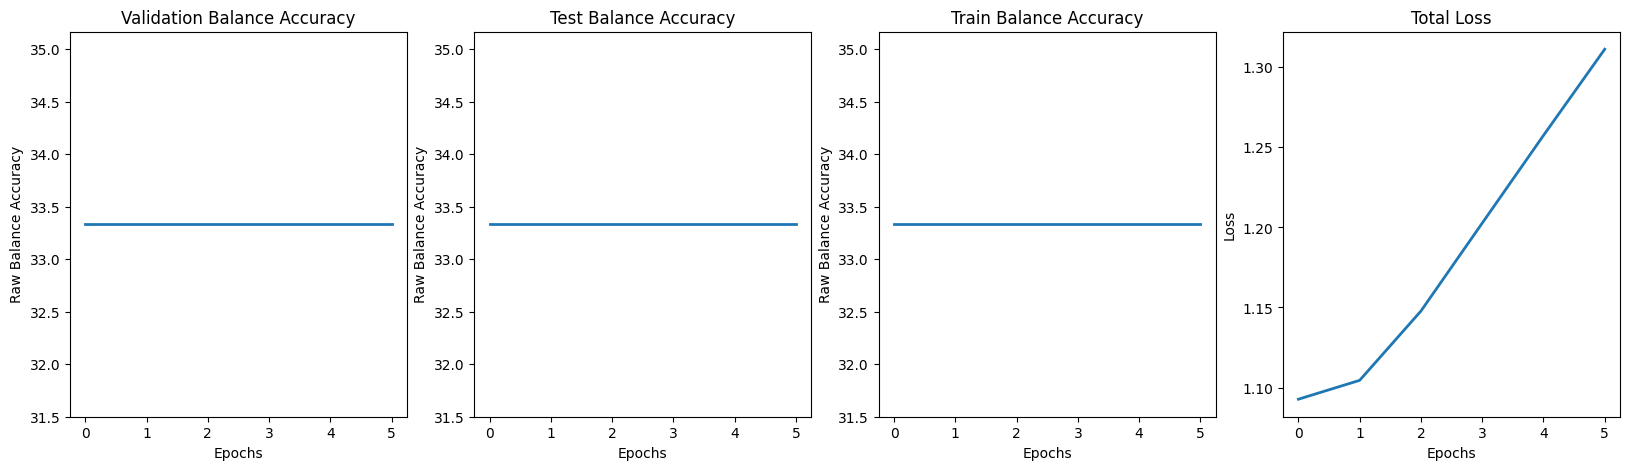

Max Validation Balance Accuracy - 33.3
Max Test Balance Accuracy - 33.3
Min Total Loss - 1.1
Epoch:  6
Learning Rate:  0.0004932146285882477


100%|██████████| 119/119 [00:03<00:00, 31.69it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 35.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.69it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0


class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  7
Learning Rate:  0.0004907719169380163


100%|██████████| 119/119 [00:03<00:00, 35.11it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 35.59it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.80it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0


class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  8
Learning Rate:  0.0004879583809693737


100%|██████████| 119/119 [00:03<00:00, 34.97it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 36.02it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.31it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0


class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  9
Learning Rate:  0.00048477614657323176


100%|██████████| 119/119 [00:03<00:00, 35.01it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 31.28it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 35.67it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  10
Learning Rate:  0.00048122761822682366



100%|██████████| 119/119 [00:03<00:00, 34.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 26.41it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 38.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


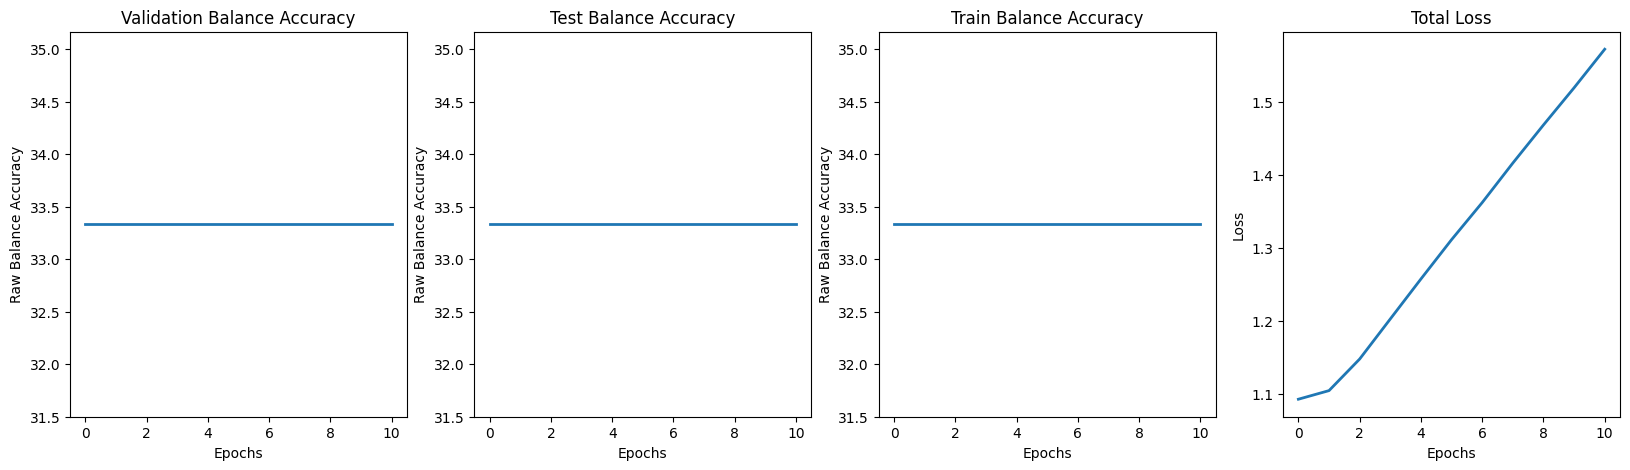

Max Validation Balance Accuracy - 33.3
Max Test Balance Accuracy - 33.3
Min Total Loss - 1.1
Epoch:  11
Learning Rate:  0.00047731547717689556


100%|██████████| 119/119 [00:04<00:00, 27.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 32.52it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 35.04it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  12
Learning Rate:  0.00047304267941377265



100%|██████████| 119/119 [00:04<00:00, 28.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 35.14it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  13
Learning Rate:  0.0004684124534378307



100%|██████████| 119/119 [00:03<00:00, 34.58it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


100%|██████████| 120/120 [00:03<00:00, 34.69it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.13it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  14
Learning Rate:  0.0004634282978200604



100%|██████████| 119/119 [00:03<00:00, 34.58it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 35.44it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.25it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  15
Learning Rate:  0.000458093978558568



100%|██████████| 119/119 [00:03<00:00, 35.17it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 31.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.96it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


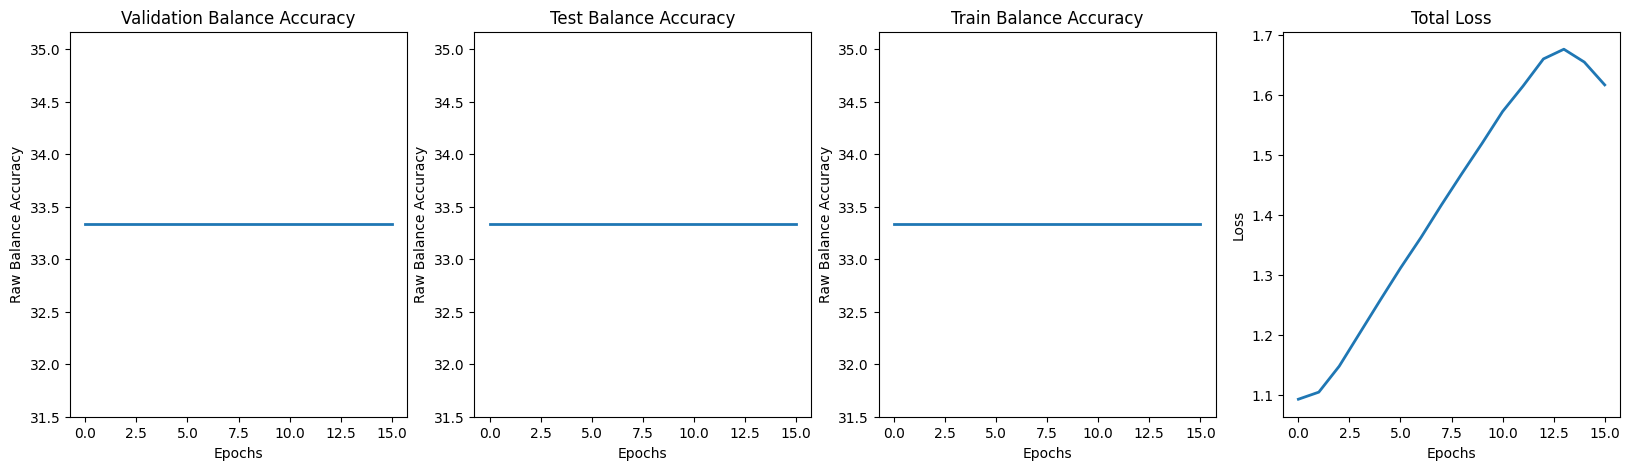

Max Validation Balance Accuracy - 33.3
Max Test Balance Accuracy - 33.3
Min Total Loss - 1.1
Epoch:  16
Learning Rate:  0.0004524135262330098


100%|██████████| 119/119 [00:03<00:00, 34.57it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0


class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


100%|██████████| 120/120 [00:04<00:00, 25.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 38.56it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  17
Learning Rate:  0.0004463912329591104



100%|██████████| 119/119 [00:04<00:00, 29.49it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 29.50it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 35.58it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  18
Learning Rate:  0.000440031649145566



100%|██████████| 119/119 [00:04<00:00, 26.55it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.98it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.66it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  19
Learning Rate:  0.00043333958005578203



100%|██████████| 119/119 [00:03<00:00, 32.95it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 35.06it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


100%|██████████| 360/360 [00:10<00:00, 34.01it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  20
Learning Rate:  0.0004263200821770461



100%|██████████| 119/119 [00:03<00:00, 34.35it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 35.53it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


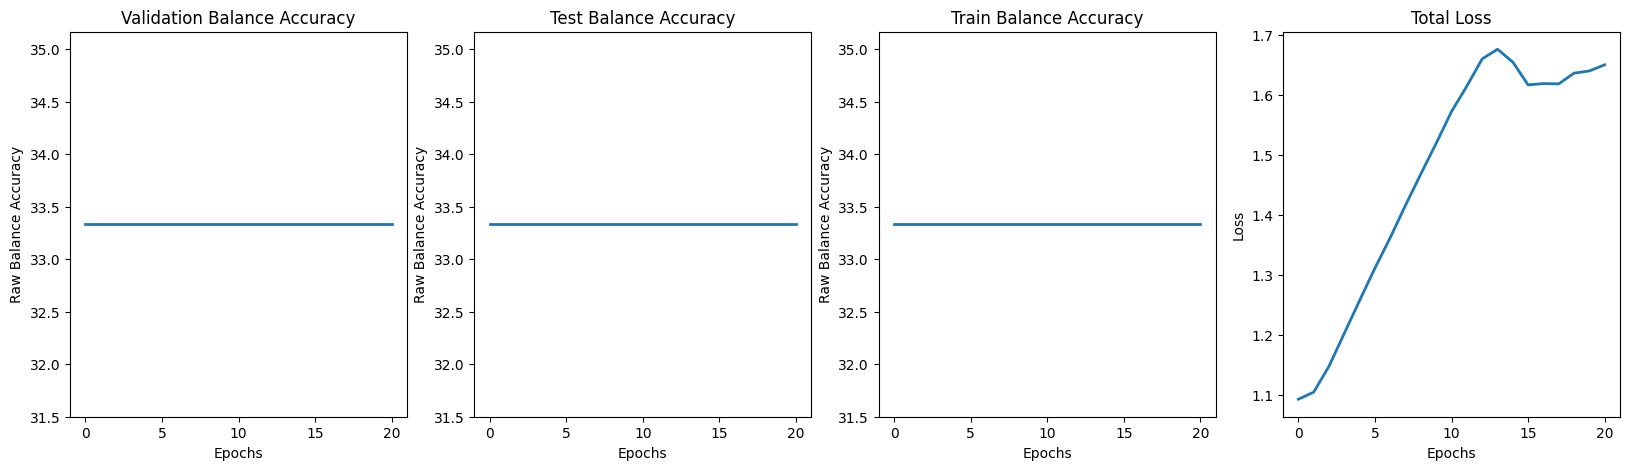

Max Validation Balance Accuracy - 33.3
Max Test Balance Accuracy - 33.3
Min Total Loss - 1.1
Epoch:  21
Learning Rate:  0.00041897845939987553


100%|██████████| 119/119 [00:03<00:00, 34.31it/s]

Inside calculate_balanced_accuracy, 3 classes passed in


class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


100%|██████████| 120/120 [00:03<00:00, 32.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.80it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  22
Learning Rate:  0.0004113202590104299



100%|██████████| 119/119 [00:03<00:00, 34.60it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 27.82it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 37.35it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0


class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  23
Learning Rate:  0.000403351267499015


100%|██████████| 119/119 [00:03<00:00, 32.65it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 27.30it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 36.96it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  24
Learning Rate:  0.0003950775061878452



100%|██████████| 119/119 [00:04<00:00, 25.40it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.60it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  25
Learning Rate:  0.0003865052266813685



100%|██████████| 119/119 [00:03<00:00, 32.36it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 35.08it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.89it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


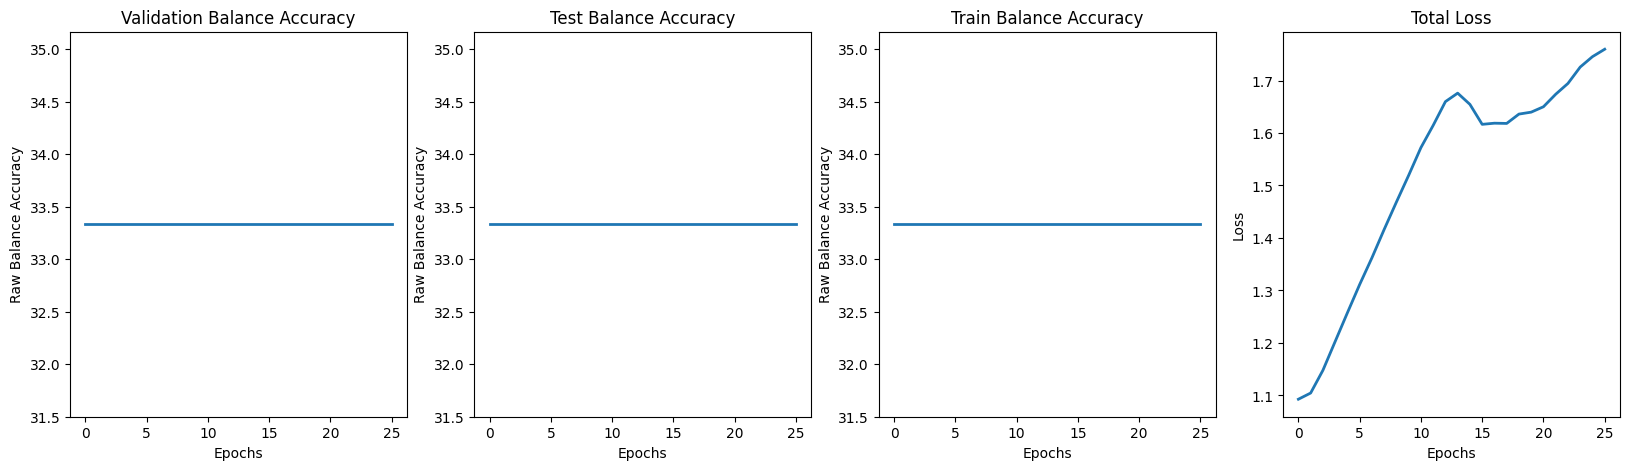

Max Validation Balance Accuracy - 33.3
Max Test Balance Accuracy - 33.3
Min Total Loss - 1.1
Epoch:  26
Learning Rate:  0.0003776409061425918


100%|██████████| 119/119 [00:03<00:00, 34.72it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.96it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.51it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  27
Learning Rate:  0.0003684912423989754


100%|██████████| 119/119 [00:03<00:00, 33.96it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.42it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.94it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  28
Learning Rate:  0.0003590631488815944



100%|██████████| 119/119 [00:03<00:00, 33.58it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 25.60it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 38.34it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  29
Learning Rate:  0.00034936374940139223


100%|██████████| 119/119 [00:03<00:00, 30.79it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 27.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 37.01it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  30
Learning Rate:  0.0003394003727664709



100%|██████████| 119/119 [00:04<00:00, 25.38it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.96it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.97it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


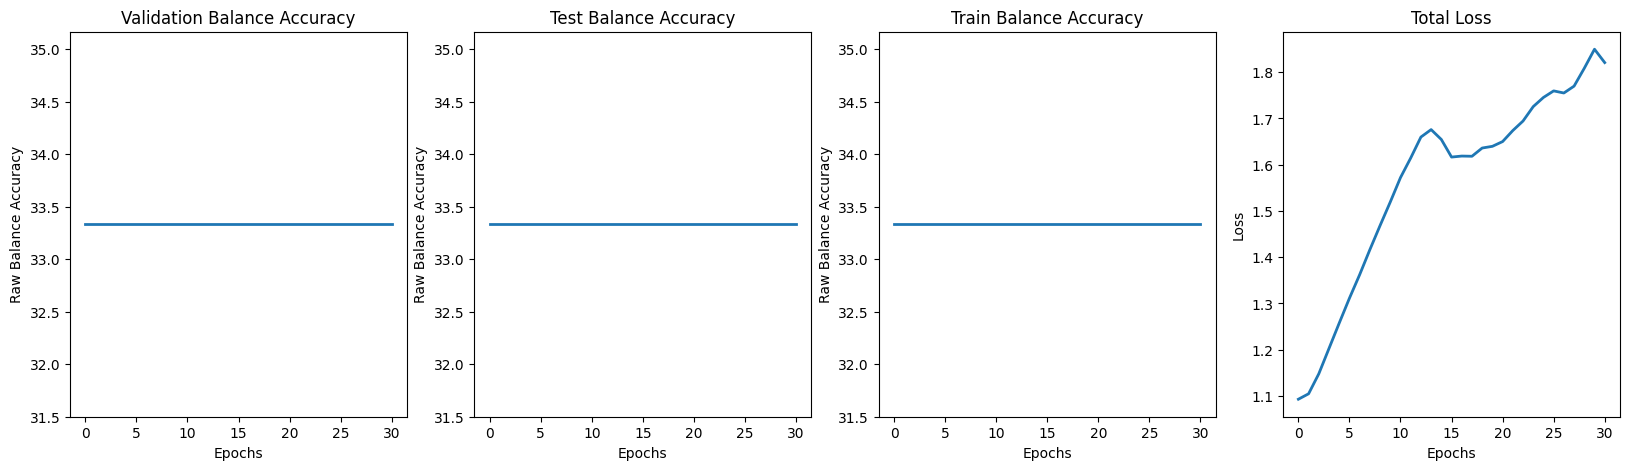

Max Validation Balance Accuracy - 33.3
Max Test Balance Accuracy - 33.3
Min Total Loss - 1.1
Epoch:  31
Learning Rate:  0.0003291805472444886


100%|██████████| 119/119 [00:03<00:00, 31.44it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 35.03it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.60it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  32
Learning Rate:  0.00031871199487434486



100%|██████████| 119/119 [00:03<00:00, 33.92it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 31.95it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.50it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  33
Learning Rate:  0.00030800262563145494



100%|██████████| 119/119 [00:03<00:00, 33.69it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 30.48it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.89it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  34
Learning Rate:  0.00029706053145101924


100%|██████████| 119/119 [00:03<00:00, 33.16it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 25.65it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 36.90it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  35
Learning Rate:  0.0002858939801138062



100%|██████████| 119/119 [00:04<00:00, 26.90it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 32.29it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.58it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


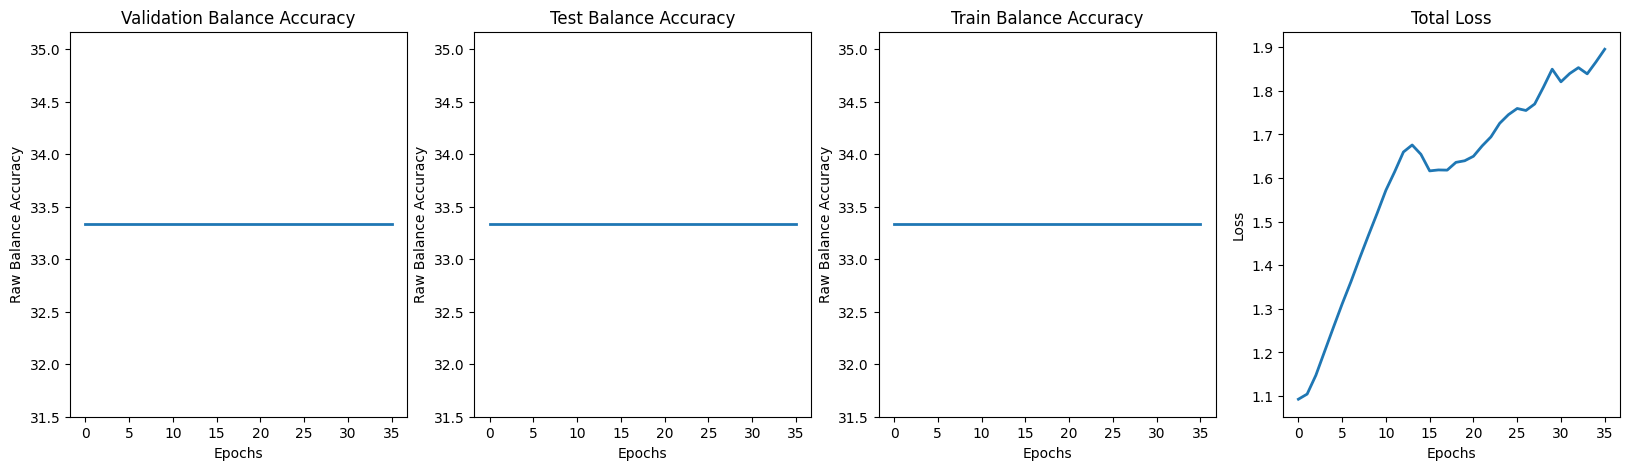

Max Validation Balance Accuracy - 33.3
Max Test Balance Accuracy - 33.3
Min Total Loss - 1.1
Epoch:  36
Learning Rate:  0.0002745114089990659


100%|██████████| 119/119 [00:04<00:00, 29.23it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


100%|██████████| 120/120 [00:03<00:00, 34.68it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  37
Learning Rate:  0.00026292141870929776



100%|██████████| 119/119 [00:03<00:00, 34.07it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.79it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.34615384615384615
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.23it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2236842105263158
class1 recall: 0.0
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  38
Learning Rate:  0.0002511327665716863



100%|██████████| 119/119 [00:03<00:00, 33.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.08
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.71it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.11538461538461539


class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0


100%|██████████| 360/360 [00:10<00:00, 33.53it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.05263157894736842
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  39
Learning Rate:  0.0002391543600211173



100%|██████████| 119/119 [00:03<00:00, 33.98it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2


class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.04
class1 recall: 0.0
class2 recall: 1.0


100%|██████████| 120/120 [00:04<00:00, 28.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 35.42it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2236842105263158
class1 recall: 0.0
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Epoch:  40
Learning Rate:  0.0002269952498697734



100%|██████████| 119/119 [00:03<00:00, 29.91it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.16
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.04
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 27.82it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.34615384615384615
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.07692307692307693
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 35.37it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.14473684210526316
class1 recall: 0.0
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.039473684210526314
class1 recall: 0.0
class2 recall: 1.0


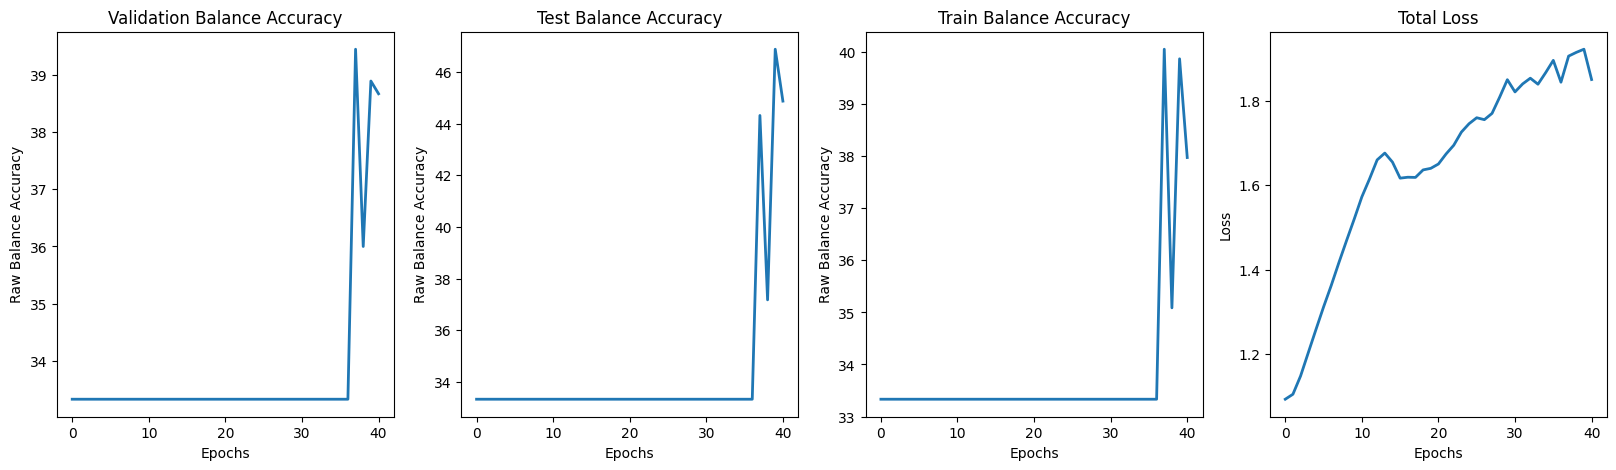

Max Validation Balance Accuracy - 39.4
Max Test Balance Accuracy - 46.9
Min Total Loss - 1.1
Epoch:  41
Learning Rate:  0.00021466462346839507


100%|██████████| 119/119 [00:04<00:00, 27.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.16
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.12
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.19it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.38461538461538464
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.19230769230769232
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.26it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.18421052631578946
class1 recall: 0.0
class2 recall: 0.988950276243094
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.039473684210526314
class1 recall: 0.0
class2 recall: 1.0
Epoch:  42
Learning Rate:  0.00020217179776437256



100%|██████████| 119/119 [00:03<00:00, 34.14it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.16
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.19it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.3076923076923077
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.24it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2894736842105263
class1 recall: 0.0
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.06578947368421052
class1 recall: 0.0
class2 recall: 1.0
Epoch:  43
Learning Rate:  0.00018952621226191733


100%|██████████| 119/119 [00:03<00:00, 34.38it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.16
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.16
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.34615384615384615
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 33.44it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.18421052631578946
class1 recall: 0.0
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.10526315789473684
class1 recall: 0.0
class2 recall: 0.994475138121547
Epoch:  44
Learning Rate:  0.00017673742188962856



100%|██████████| 119/119 [00:03<00:00, 33.84it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.28
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.16
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 27.27it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.34615384615384615
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 36.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.40789473684210525
class1 recall: 0.0
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.14473684210526316
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  45
Learning Rate:  0.00016381508978084673



100%|██████████| 119/119 [00:03<00:00, 31.48it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.16
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:04<00:00, 27.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 35.80it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.0
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.18421052631578946
class1 recall: 0.0
class2 recall: 0.988950276243094


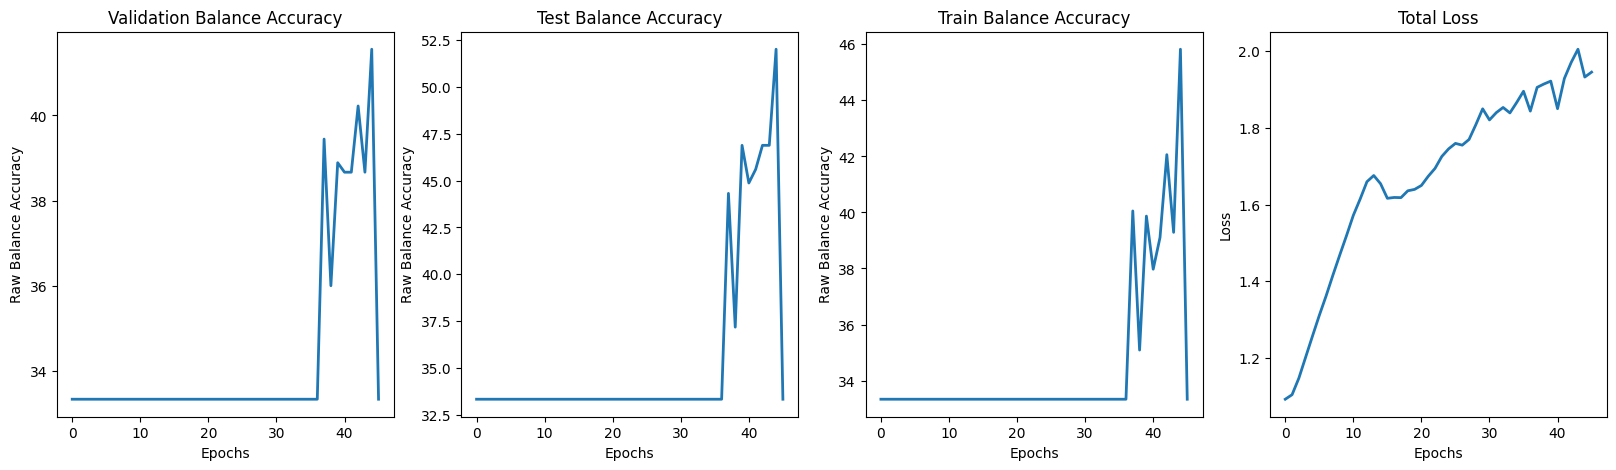

Max Validation Balance Accuracy - 41.6
Max Test Balance Accuracy - 52.0
Min Total Loss - 1.1
Epoch:  46
Learning Rate:  0.0001507689799722479


100%|██████████| 119/119 [00:05<00:00, 22.90it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.16
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 32.43it/s]

Inside calculate_balanced_accuracy, 3 classes passed in


class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333


100%|██████████| 360/360 [00:11<00:00, 32.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2631578947368421
class1 recall: 0.0
class2 recall: 0.988950276243094
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2236842105263158
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  47
Learning Rate:  0.0001376089500261958



100%|██████████| 119/119 [00:03<00:00, 31.75it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.17it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 32.97it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2894736842105263
class1 recall: 0.0
class2 recall: 0.9834254143646409
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.25
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  48
Learning Rate:  0.00012434494358242747



100%|██████████| 119/119 [00:03<00:00, 34.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:03<00:00, 33.70it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.41it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32894736842105265
class1 recall: 0.0
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.27631578947368424
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  49
Learning Rate:  0.00011098698284469807



100%|██████████| 119/119 [00:03<00:00, 33.65it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.28
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 33.63it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.60it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.34210526315789475
class1 recall: 0.0
class2 recall: 0.988950276243094
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2894736842105263
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  50
Learning Rate:  9.754516100806417e-05



100%|██████████| 119/119 [00:03<00:00, 34.17it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:04<00:00, 27.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:09<00:00, 36.66it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.27631578947368424
class1 recall: 0.0
class2 recall: 0.988950276243094
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.3026315789473684
class1 recall: 0.0
class2 recall: 0.988950276243094


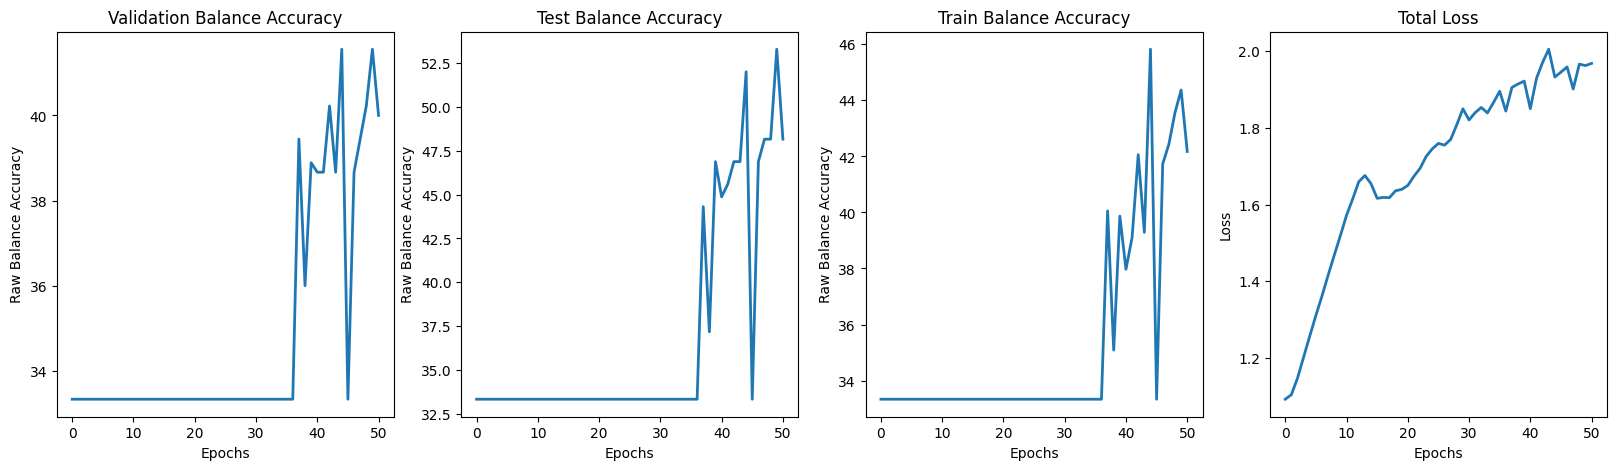

Max Validation Balance Accuracy - 41.6
Max Test Balance Accuracy - 53.3
Min Total Loss - 1.1
Epoch:  51
Learning Rate:  0.0004998111014986735


100%|██████████| 119/119 [00:04<00:00, 29.60it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:04<00:00, 27.90it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 35.40it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.27631578947368424
class1 recall: 0.0
class2 recall: 0.9834254143646409
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.27631578947368424
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  52
Learning Rate:  0.0004992445487252689



100%|██████████| 119/119 [00:04<00:00, 25.39it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:03<00:00, 33.93it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.0
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4473684210526316
class1 recall: 0.0
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2631578947368421
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  53
Learning Rate:  0.0004983007697636659



100%|██████████| 119/119 [00:03<00:00, 30.42it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 34.41it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.0
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.38461538461538464
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.07it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.47368421052631576
class1 recall: 0.0
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2236842105263158
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  54
Learning Rate:  0.0004969804777275899



100%|██████████| 119/119 [00:03<00:00, 33.81it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.36
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 1.0



100%|██████████| 120/120 [00:03<00:00, 33.63it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.0
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.38461538461538464
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4868421052631579
class1 recall: 0.0
class2 recall: 0.9337016574585635
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2236842105263158
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  55
Learning Rate:  0.0004952846702217887



100%|██████████| 119/119 [00:03<00:00, 34.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.36
class1 recall: 0.0
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:03<00:00, 35.04it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.0
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.36it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4342105263157895
class1 recall: 0.0
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.3026315789473684
class1 recall: 0.0
class2 recall: 0.9834254143646409


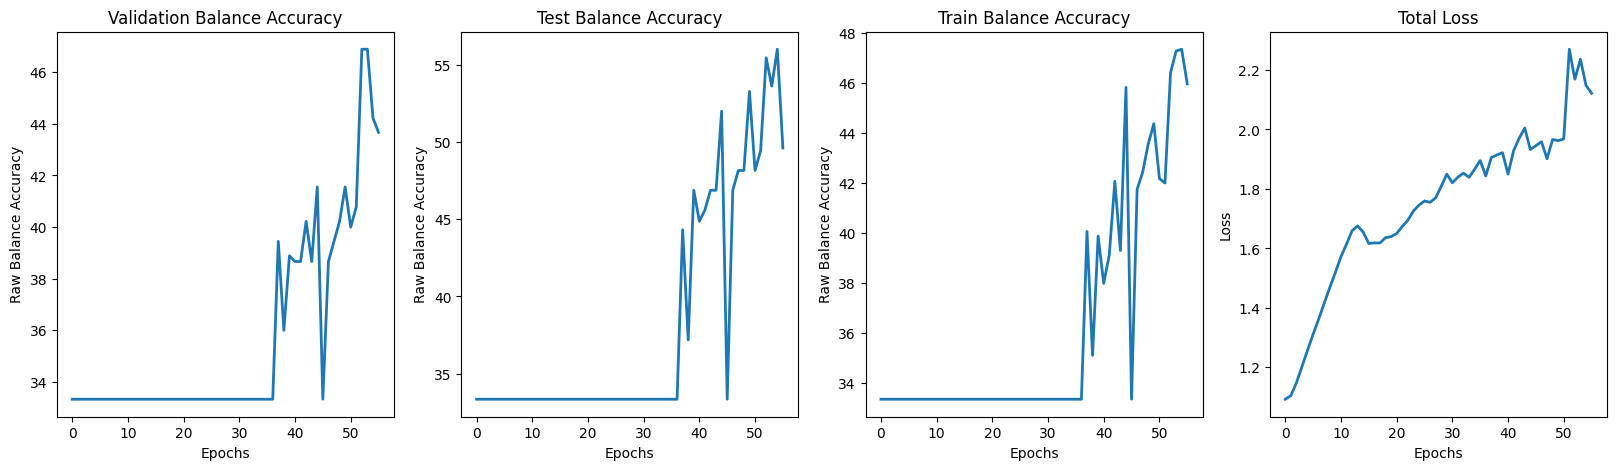

Max Validation Balance Accuracy - 46.9
Max Test Balance Accuracy - 56.0
Min Total Loss - 1.1
Epoch:  56
Learning Rate:  0.0004932146285882477


100%|██████████| 119/119 [00:03<00:00, 33.75it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:04<00:00, 29.59it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 35.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.2631578947368421
class1 recall: 0.0
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.3026315789473684
class1 recall: 0.0
class2 recall: 0.9834254143646409
Epoch:  57
Learning Rate:  0.0004907719169380163



100%|██████████| 119/119 [00:03<00:00, 34.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.0
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.28
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:04<00:00, 24.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.0
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:09<00:00, 37.62it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.631578947368421
class1 recall: 0.0
class2 recall: 0.9171270718232044
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.3157894736842105
class1 recall: 0.0
class2 recall: 0.9779005524861878


Epoch:  58
Learning Rate:  0.0004879583809693737


100%|██████████| 119/119 [00:04<00:00, 26.95it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.0
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.28
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:03<00:00, 31.00it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.0
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6710526315789473
class1 recall: 0.0
class2 recall: 0.9171270718232044
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.3684210526315789
class1 recall: 0.0
class2 recall: 0.9779005524861878
Epoch:  59
Learning Rate:  0.00048477614657323176



100%|██████████| 119/119 [00:04<00:00, 27.59it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.28
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:03<00:00, 33.90it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.06it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.3815789473684211
class1 recall: 0.0
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.40789473684210525
class1 recall: 0.0
class2 recall: 0.9779005524861878
Epoch:  60
Learning Rate:  0.00048122761822682366



100%|██████████| 119/119 [00:03<00:00, 33.56it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:03<00:00, 33.87it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.0
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.10it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4868421052631579
class1 recall: 0.0
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.42105263157894735
class1 recall: 0.0
class2 recall: 0.9834254143646409


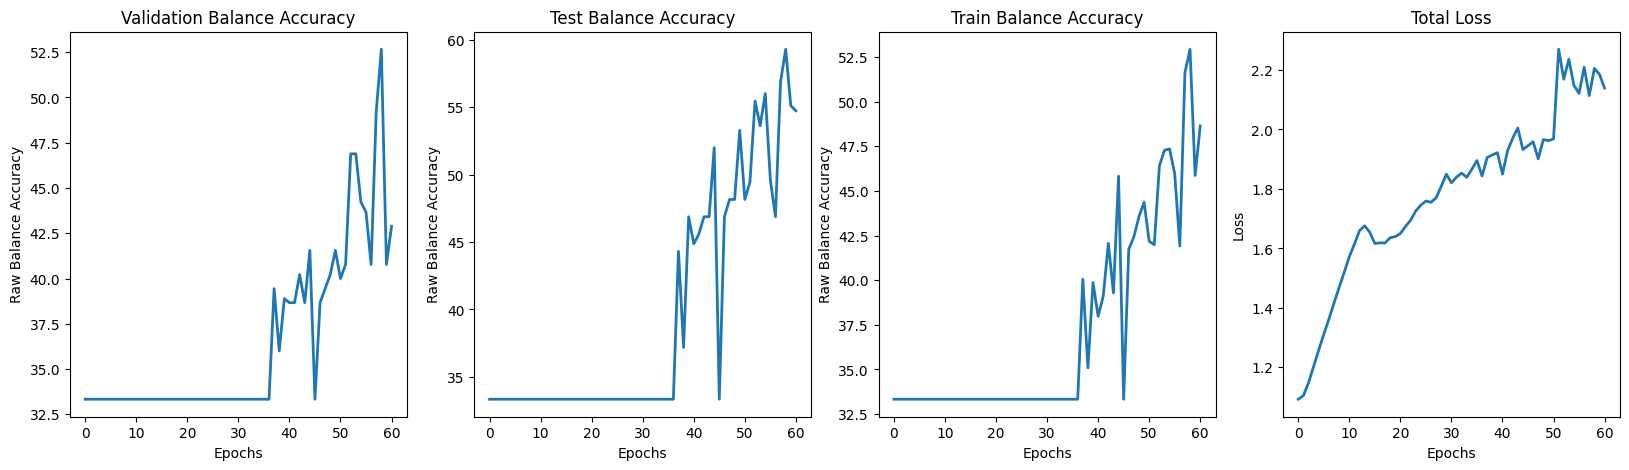

Max Validation Balance Accuracy - 52.7
Max Test Balance Accuracy - 59.3
Min Total Loss - 1.1
Epoch:  61
Learning Rate:  0.00047731547717689556


100%|██████████| 119/119 [00:03<00:00, 33.79it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.0
class2 recall: 0.9333333333333333


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.36
class1 recall: 0.0
class2 recall: 0.9833333333333333


100%|██████████| 120/120 [00:03<00:00, 31.65it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:11<00:00, 32.66it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.618421052631579
class1 recall: 0.0
class2 recall: 0.9392265193370166
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4473684210526316
class1 recall: 0.0
class2 recall: 0.9834254143646409
Epoch:  62
Learning Rate:  0.00047304267941377265



100%|██████████| 119/119 [00:03<00:00, 33.19it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:04<00:00, 27.28it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 35.41it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5131578947368421
class1 recall: 0.0
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.47368421052631576
class1 recall: 0.0
class2 recall: 0.9834254143646409
Epoch:  63
Learning Rate:  0.0004684124534378307



100%|██████████| 119/119 [00:03<00:00, 32.75it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.0
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.36
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:04<00:00, 24.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8846153846153846
class1 recall: 0.0
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:10<00:00, 35.57it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.0
class2 recall: 0.8784530386740331
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4868421052631579
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  64
Learning Rate:  0.0004634282978200604



100%|██████████| 119/119 [00:04<00:00, 24.99it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.0
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 120/120 [00:03<00:00, 33.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.0
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:11<00:00, 32.69it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6052631578947368
class1 recall: 0.0
class2 recall: 0.9337016574585635
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4868421052631579
class1 recall: 0.0
class2 recall: 0.988950276243094
Epoch:  65
Learning Rate:  0.000458093978558568



100%|██████████| 119/119 [00:03<00:00, 31.16it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.24
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 34.31it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:10<00:00, 33.14it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.3026315789473684
class1 recall: 0.0
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5131578947368421
class1 recall: 0.0
class2 recall: 0.9834254143646409


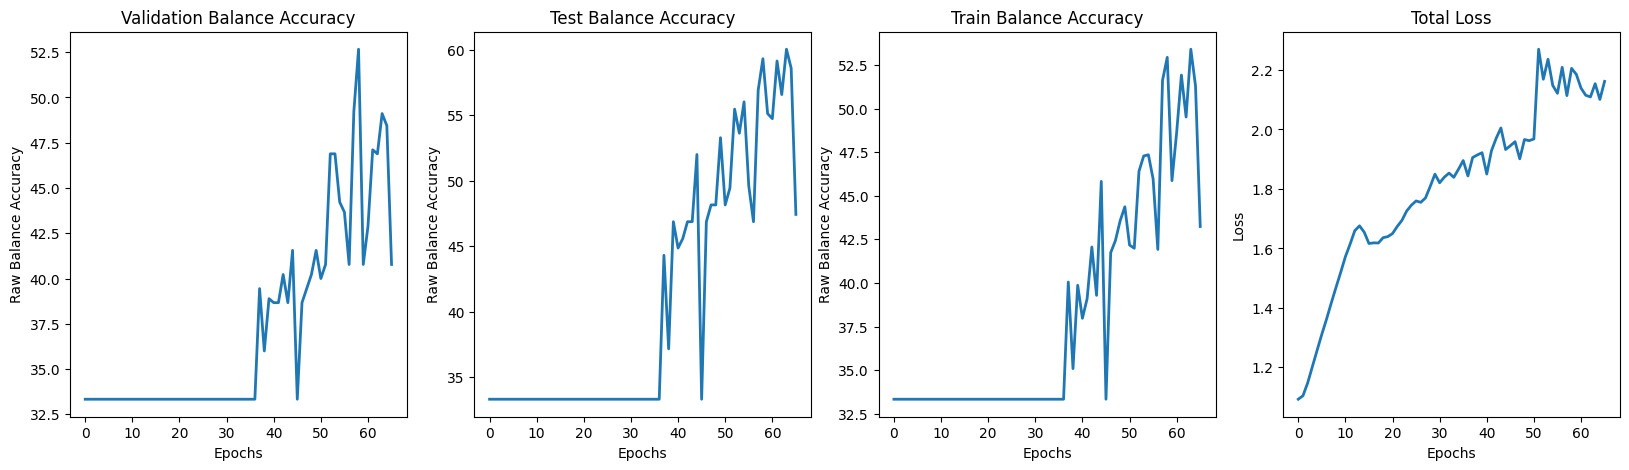

Max Validation Balance Accuracy - 52.7
Max Test Balance Accuracy - 60.0
Min Total Loss - 1.1
Epoch:  66
Learning Rate:  0.0004524135262330098


100%|██████████| 119/119 [00:03<00:00, 33.27it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.0
class2 recall: 0.95



100%|██████████| 120/120 [00:03<00:00, 33.40it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.0
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:11<00:00, 32.38it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6052631578947368
class1 recall: 0.0
class2 recall: 0.9613259668508287
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5131578947368421
class1 recall: 0.0
class2 recall: 0.9834254143646409
Epoch:  67
Learning Rate:  0.0004463912329591104



100%|██████████| 119/119 [00:03<00:00, 33.42it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.0
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 31.13it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9230769230769231
class1 recall: 0.0
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.0
class2 recall: 0.9116022099447514
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5263157894736842
class1 recall: 0.0
class2 recall: 0.9834254143646409
Epoch:  68
Learning Rate:  0.000440031649145566



100%|██████████| 119/119 [00:03<00:00, 33.11it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.88
class1 recall: 0.0
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:04<00:00, 24.97it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9230769230769231
class1 recall: 0.0
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:09<00:00, 36.84it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.009708737864077669
class2 recall: 0.8839779005524862
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5394736842105263
class1 recall: 0.0
class2 recall: 0.9834254143646409
Epoch:  69
Learning Rate:  0.00043333958005578203



100%|██████████| 119/119 [00:04<00:00, 26.69it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.0
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 30.68it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.55it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5657894736842105
class1 recall: 0.019417475728155338
class2 recall: 0.9613259668508287
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5526315789473685
class1 recall: 0.0
class2 recall: 0.9834254143646409
Epoch:  70
Learning Rate:  0.0004263200821770461



100%|██████████| 119/119 [00:04<00:00, 26.58it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.0
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 33.82it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.0
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:11<00:00, 32.53it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8157894736842105
class1 recall: 0.0
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5526315789473685
class1 recall: 0.009708737864077669
class2 recall: 0.9834254143646409


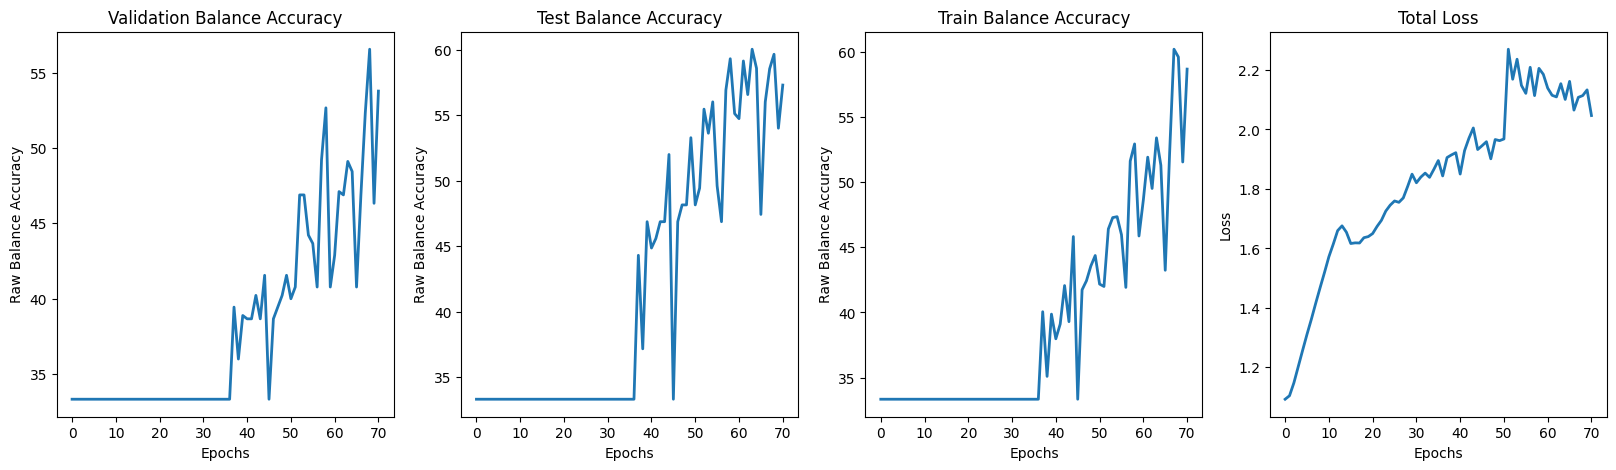

Max Validation Balance Accuracy - 56.6
Max Test Balance Accuracy - 60.0
Min Total Loss - 1.1
Epoch:  71
Learning Rate:  0.00041897845939987553


100%|██████████| 119/119 [00:03<00:00, 33.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.84
class1 recall: 0.058823529411764705
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 33.19it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9230769230769231
class1 recall: 0.08823529411764706
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.0
class2 recall: 0.9833333333333333


100%|██████████| 360/360 [00:11<00:00, 32.52it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.009708737864077669
class2 recall: 0.7790055248618785
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5657894736842105
class1 recall: 0.0
class2 recall: 0.9779005524861878
Epoch:  72
Learning Rate:  0.0004113202590104299



100%|██████████| 119/119 [00:03<00:00, 32.93it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.14705882352941177
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 34.08it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.0
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:11<00:00, 32.66it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6447368421052632
class1 recall: 0.038834951456310676
class2 recall: 0.9558011049723757
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5921052631578947
class1 recall: 0.0
class2 recall: 0.9723756906077348
Epoch:  73
Learning Rate:  0.000403351267499015



100%|██████████| 119/119 [00:03<00:00, 32.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.058823529411764705
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:04<00:00, 28.00it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 34.72it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5657894736842105
class1 recall: 0.04854368932038835
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5789473684210527
class1 recall: 0.019417475728155338
class2 recall: 0.9723756906077348
Epoch:  74
Learning Rate:  0.0003950775061878452



100%|██████████| 119/119 [00:03<00:00, 32.13it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.08823529411764706
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:04<00:00, 24.99it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8846153846153846
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 35.84it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8026315789473685
class1 recall: 0.1553398058252427
class2 recall: 0.9116022099447514
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.618421052631579
class1 recall: 0.019417475728155338
class2 recall: 0.9668508287292817
Epoch:  75
Learning Rate:  0.0003865052266813685



100%|██████████| 119/119 [00:04<00:00, 26.20it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 30.70it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.0
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 32.93it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6710526315789473
class1 recall: 0.0
class2 recall: 0.988950276243094
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5789473684210527
class1 recall: 0.019417475728155338
class2 recall: 0.9668508287292817


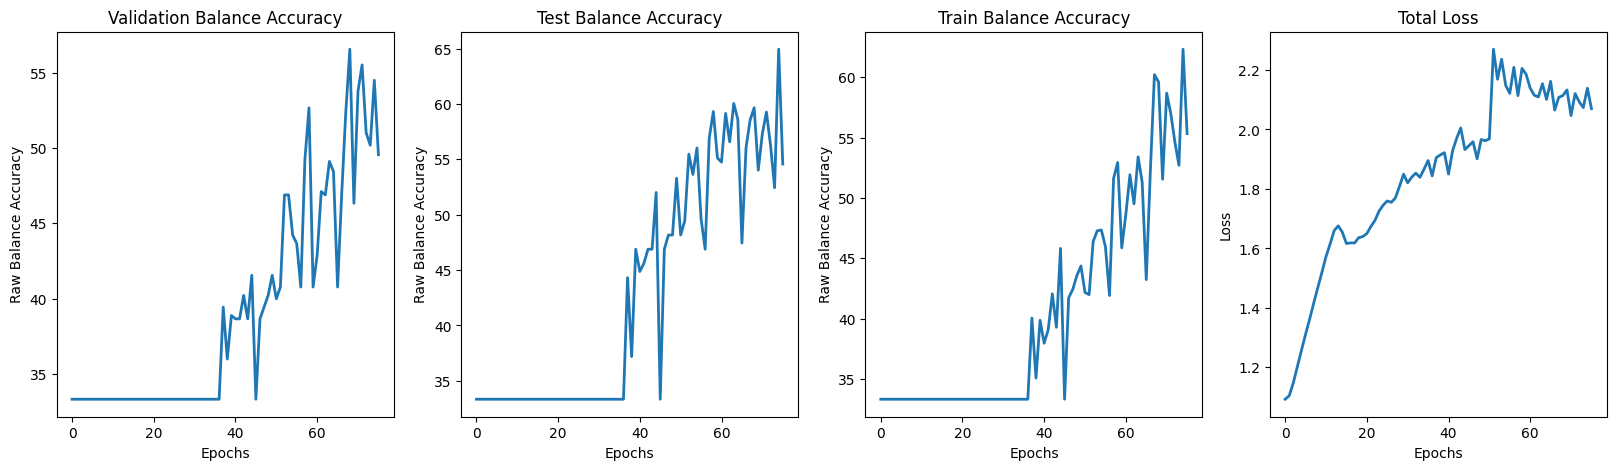

Max Validation Balance Accuracy - 56.6
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  76
Learning Rate:  0.0003776409061425918


100%|██████████| 119/119 [00:04<00:00, 28.35it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.0
class2 recall: 0.9666666666666667


100%|██████████| 120/120 [00:03<00:00, 33.37it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.0
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:11<00:00, 32.14it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.618421052631579
class1 recall: 0.019417475728155338
class2 recall: 0.988950276243094
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6052631578947368
class1 recall: 0.009708737864077669
class2 recall: 0.9723756906077348
Epoch:  77
Learning Rate:  0.0003684912423989754



100%|██████████| 119/119 [00:03<00:00, 32.59it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.17647058823529413
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.0
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 32.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.08823529411764706
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.058823529411764705
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:11<00:00, 32.42it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.04854368932038835
class2 recall: 0.9281767955801105
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.618421052631579
class1 recall: 0.009708737864077669
class2 recall: 0.9723756906077348
Epoch:  78
Learning Rate:  0.0003590631488815944



100%|██████████| 119/119 [00:03<00:00, 33.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.08823529411764706
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 32.85it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in


class0 recall: 0.5769230769230769
class1 recall: 0.058823529411764705
class2 recall: 0.9833333333333333


100%|██████████| 360/360 [00:11<00:00, 32.32it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5921052631578947
class1 recall: 0.04854368932038835
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.631578947368421
class1 recall: 0.02912621359223301
class2 recall: 0.9723756906077348
Epoch:  79
Learning Rate:  0.00034936374940139223



100%|██████████| 119/119 [00:03<00:00, 33.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.11764705882352941


class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667


100%|██████████| 120/120 [00:04<00:00, 27.93it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.058823529411764705
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 1.0



100%|██████████| 360/360 [00:10<00:00, 34.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6578947368421053
class1 recall: 0.05825242718446602
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5921052631578947
class1 recall: 0.038834951456310676
class2 recall: 0.9723756906077348
Epoch:  80
Learning Rate:  0.0003394003727664709



100%|██████████| 119/119 [00:03<00:00, 32.72it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.08823529411764706
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:04<00:00, 24.33it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.0
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 1.0



100%|██████████| 360/360 [00:09<00:00, 36.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5657894736842105
class1 recall: 0.0
class2 recall: 0.9834254143646409
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5921052631578947
class1 recall: 0.05825242718446602
class2 recall: 0.9668508287292817


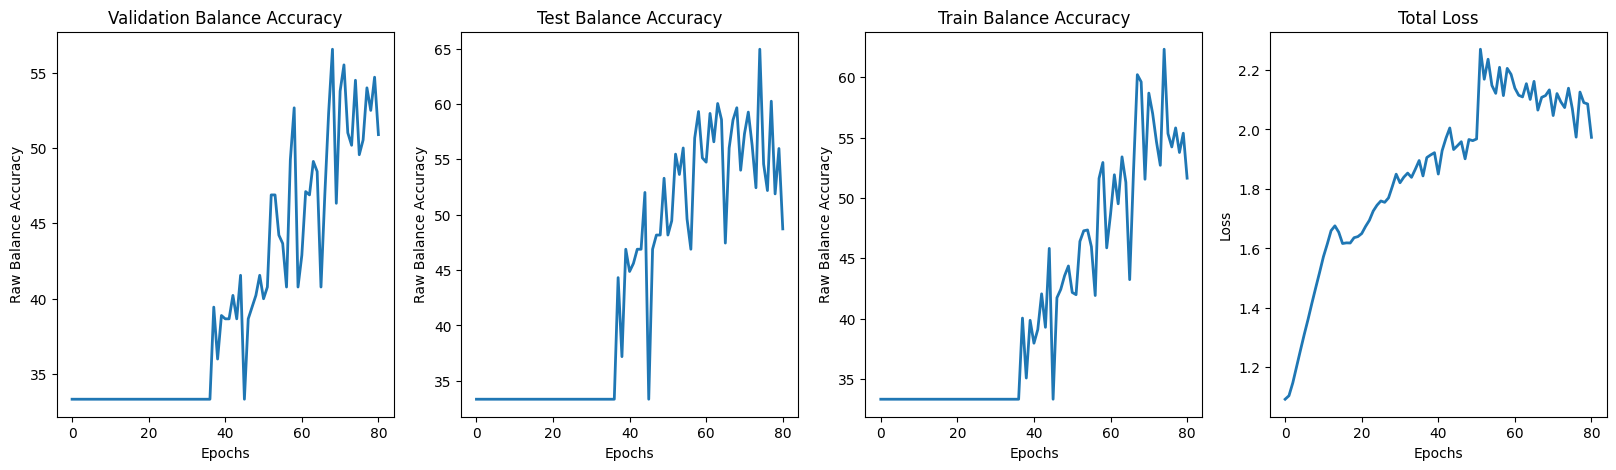

Max Validation Balance Accuracy - 56.6
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  81
Learning Rate:  0.0003291805472444886


100%|██████████| 119/119 [00:04<00:00, 26.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.029411764705882353
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.08823529411764706
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:04<00:00, 29.88it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.038834951456310676
class2 recall: 0.9558011049723757
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.618421052631579
class1 recall: 0.05825242718446602
class2 recall: 0.9668508287292817
Epoch:  82
Learning Rate:  0.00031871199487434486



100%|██████████| 119/119 [00:04<00:00, 27.50it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.058823529411764705
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.058823529411764705
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 33.08it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:11<00:00, 31.95it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5263157894736842
class1 recall: 0.0
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.631578947368421
class1 recall: 0.04854368932038835
class2 recall: 0.9723756906077348
Epoch:  83
Learning Rate:  0.00030800262563145494



100%|██████████| 119/119 [00:03<00:00, 33.02it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.17647058823529413
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 32.98it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:11<00:00, 32.33it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7894736842105263
class1 recall: 0.10679611650485436
class2 recall: 0.9392265193370166
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.618421052631579
class1 recall: 0.04854368932038835
class2 recall: 0.9723756906077348
Epoch:  84
Learning Rate:  0.00029706053145101924


100%|██████████| 119/119 [00:03<00:00, 33.36it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 33.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:11<00:00, 31.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4605263157894737
class1 recall: 0.038834951456310676
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6052631578947368
class1 recall: 0.038834951456310676
class2 recall: 0.9723756906077348
Epoch:  85
Learning Rate:  0.0002858939801138062



100%|██████████| 119/119 [00:03<00:00, 33.16it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.20588235294117646
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.029411764705882353
class2 recall: 0.95



100%|██████████| 120/120 [00:04<00:00, 27.01it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.11764705882352941
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 34.74it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.0970873786407767
class2 recall: 0.9392265193370166
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6052631578947368
class1 recall: 0.05825242718446602
class2 recall: 0.9723756906077348


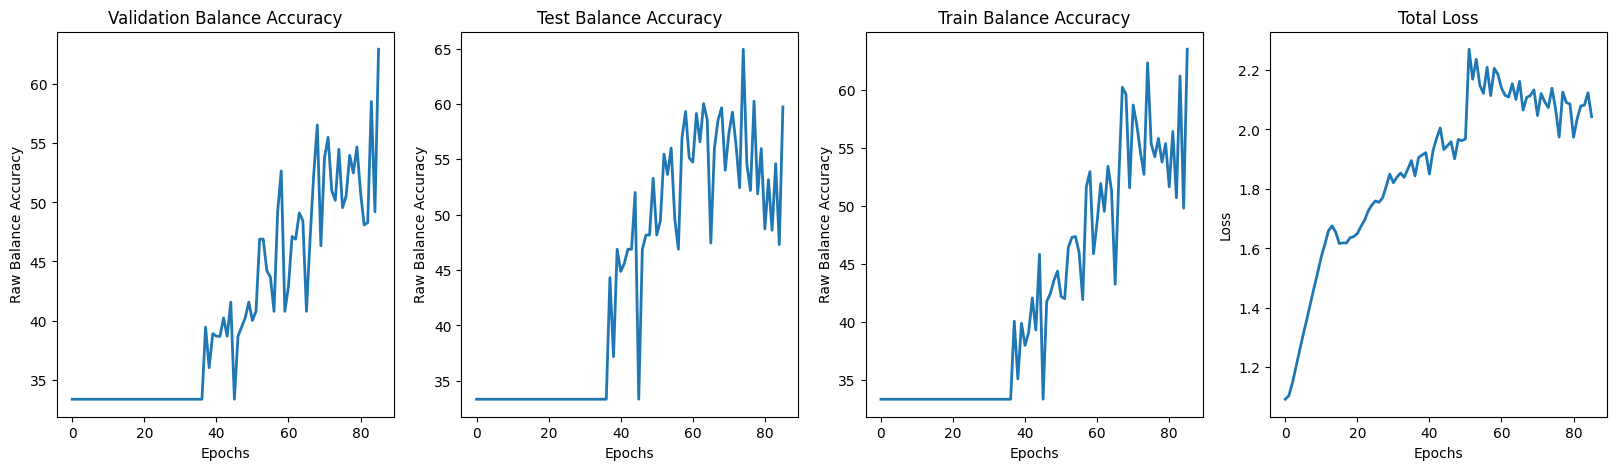

Max Validation Balance Accuracy - 63.0
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  86
Learning Rate:  0.0002745114089990659


100%|██████████| 119/119 [00:04<00:00, 28.81it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.029411764705882353
class2 recall: 0.95



100%|██████████| 120/120 [00:04<00:00, 26.63it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.058823529411764705
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.87it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.06796116504854369
class2 recall: 0.9834254143646409
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6447368421052632
class1 recall: 0.06796116504854369
class2 recall: 0.9723756906077348
Epoch:  87
Learning Rate:  0.00026292141870929776



100%|██████████| 119/119 [00:04<00:00, 24.15it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.36
class1 recall: 0.08823529411764706
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.029411764705882353
class2 recall: 0.95



100%|██████████| 120/120 [00:03<00:00, 33.06it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:11<00:00, 31.72it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6447368421052632
class1 recall: 0.06796116504854369
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6447368421052632
class1 recall: 0.06796116504854369
class2 recall: 0.9723756906077348
Epoch:  88
Learning Rate:  0.0002511327665716863



100%|██████████| 119/119 [00:03<00:00, 30.37it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.14705882352941177
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.08823529411764706
class2 recall: 0.95



100%|██████████| 120/120 [00:03<00:00, 32.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.0
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:11<00:00, 32.20it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7894736842105263
class1 recall: 0.08737864077669903
class2 recall: 0.9558011049723757
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.0970873786407767
class2 recall: 0.9723756906077348
Epoch:  89
Learning Rate:  0.0002391543600211173



100%|██████████| 119/119 [00:03<00:00, 32.73it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.08823529411764706
class2 recall: 0.95



100%|██████████| 120/120 [00:03<00:00, 32.87it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:11<00:00, 32.15it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6710526315789473
class1 recall: 0.08737864077669903
class2 recall: 0.9834254143646409
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.0970873786407767
class2 recall: 0.9723756906077348
Epoch:  90
Learning Rate:  0.0002269952498697734



100%|██████████| 119/119 [00:03<00:00, 33.21it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.058823529411764705
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.08823529411764706
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:04<00:00, 29.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.029411764705882353
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:10<00:00, 33.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5657894736842105
class1 recall: 0.04854368932038835
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.0970873786407767
class2 recall: 0.9723756906077348


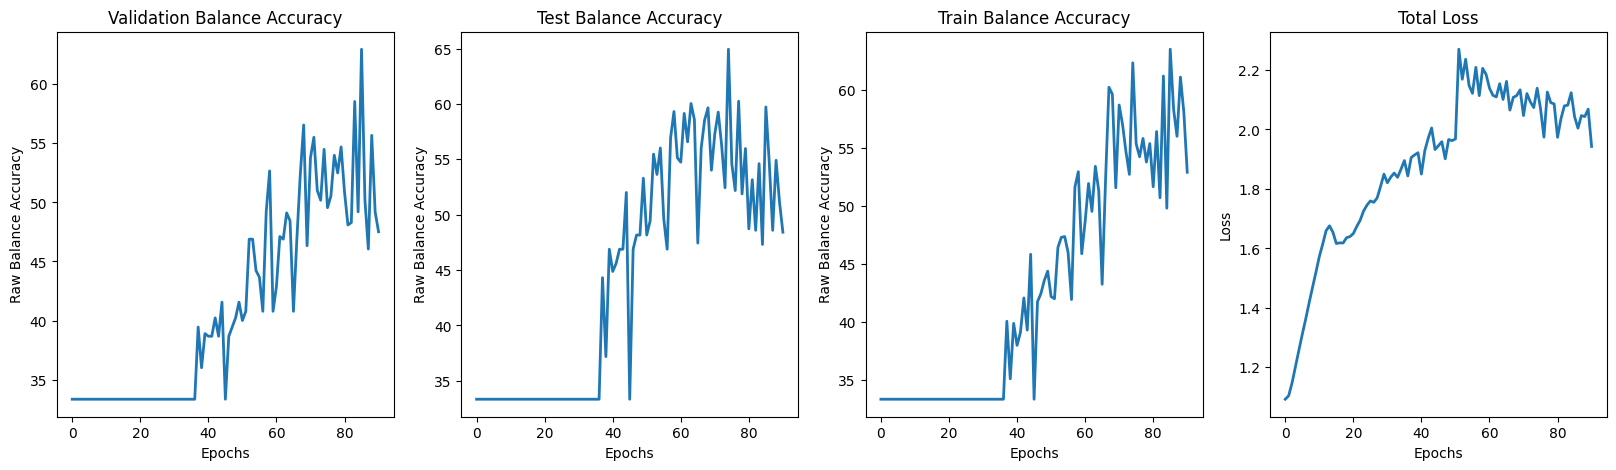

Max Validation Balance Accuracy - 63.0
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  91
Learning Rate:  0.00021466462346839507


100%|██████████| 119/119 [00:04<00:00, 28.23it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.058823529411764705
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.11764705882352941
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:04<00:00, 27.07it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.058823529411764705
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:10<00:00, 33.10it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6052631578947368
class1 recall: 0.06796116504854369
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.08737864077669903
class2 recall: 0.9723756906077348
Epoch:  92
Learning Rate:  0.00020217179776437256



100%|██████████| 119/119 [00:04<00:00, 24.39it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.11764705882352941
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.14705882352941177
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 32.75it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.08823529411764706
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:11<00:00, 31.63it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.10679611650485436
class2 recall: 0.9392265193370166
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.0970873786407767
class2 recall: 0.9723756906077348
Epoch:  93
Learning Rate:  0.00018952621226191733



100%|██████████| 119/119 [00:03<00:00, 32.33it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.23529411764705882
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.11764705882352941
class2 recall: 0.9666666666666667



100%|██████████| 120/120 [00:03<00:00, 32.22it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667



100%|██████████| 360/360 [00:11<00:00, 31.82it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.21359223300970873
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6710526315789473
class1 recall: 0.0970873786407767
class2 recall: 0.9668508287292817
Epoch:  94
Learning Rate:  0.00017673742188962856



100%|██████████| 119/119 [00:03<00:00, 32.25it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.20588235294117646
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.14705882352941177
class2 recall: 0.95



100%|██████████| 120/120 [00:03<00:00, 31.62it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.95



100%|██████████| 360/360 [00:11<00:00, 31.59it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8289473684210527
class1 recall: 0.1650485436893204
class2 recall: 0.9281767955801105
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6710526315789473
class1 recall: 0.0970873786407767
class2 recall: 0.9668508287292817
Epoch:  95
Learning Rate:  0.00016381508978084673



100%|██████████| 119/119 [00:03<00:00, 32.43it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.2647058823529412
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.11764705882352941
class2 recall: 0.95



100%|██████████| 120/120 [00:04<00:00, 24.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.058823529411764705
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.95



100%|██████████| 360/360 [00:10<00:00, 35.02it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.1650485436893204
class2 recall: 0.9502762430939227
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.08737864077669903
class2 recall: 0.9668508287292817


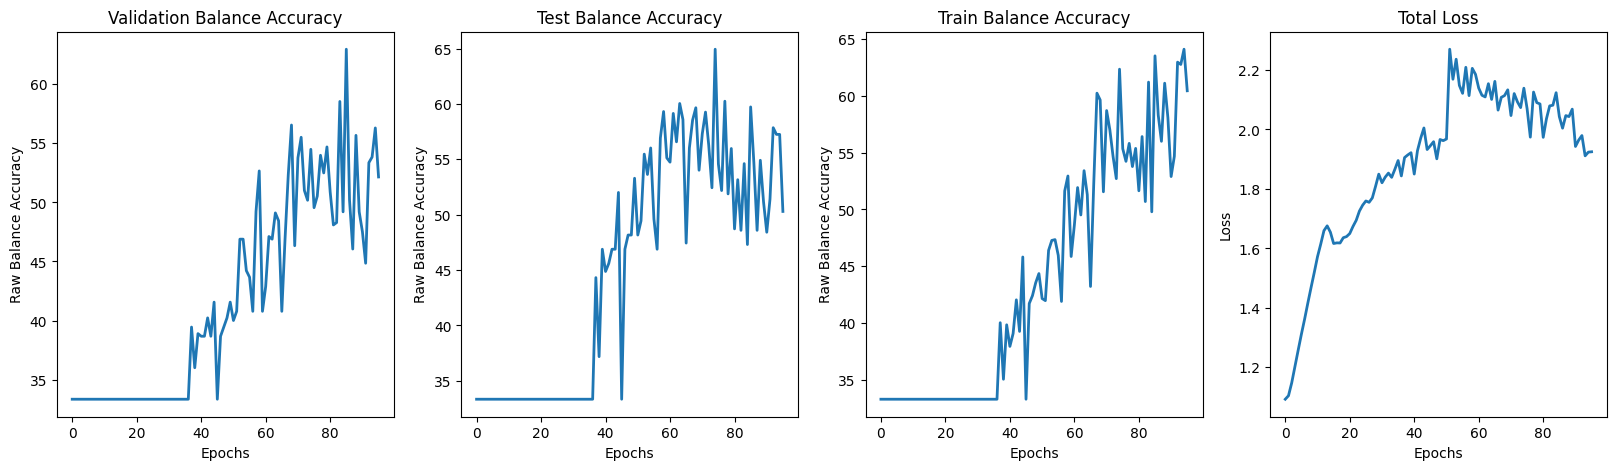

Max Validation Balance Accuracy - 63.0
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  96
Learning Rate:  0.0001507689799722479


100%|██████████| 119/119 [00:04<00:00, 26.14it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.029411764705882353
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.08823529411764706
class2 recall: 0.95



100%|██████████| 120/120 [00:04<00:00, 28.41it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.029411764705882353
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.95



100%|██████████| 360/360 [00:11<00:00, 32.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.75
class1 recall: 0.06796116504854369
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.11650485436893204
class2 recall: 0.9668508287292817
Epoch:  97
Learning Rate:  0.0001376089500261958



100%|██████████| 119/119 [00:04<00:00, 26.09it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.17647058823529413
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.11764705882352941
class2 recall: 0.9333333333333333



100%|██████████| 120/120 [00:03<00:00, 32.45it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.95



100%|██████████| 360/360 [00:11<00:00, 31.50it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7105263157894737
class1 recall: 0.1553398058252427
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.1262135922330097
class2 recall: 0.9668508287292817
Epoch:  98
Learning Rate:  0.00012434494358242747



100%|██████████| 119/119 [00:03<00:00, 32.78it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.2647058823529412
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.11764705882352941
class2 recall: 0.95



100%|██████████| 120/120 [00:03<00:00, 32.20it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.9333333333333333



100%|██████████| 360/360 [00:11<00:00, 31.22it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7368421052631579
class1 recall: 0.22330097087378642
class2 recall: 0.9281767955801105
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.11650485436893204
class2 recall: 0.9668508287292817
Epoch:  99
Learning Rate:  0.00011098698284469807



100%|██████████| 119/119 [00:03<00:00, 31.69it/s]

Inside calculate_balanced_accuracy, 3 classes passed in


class0 recall: 0.52
class1 recall: 0.20588235294117646
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.11764705882352941
class2 recall: 0.95


100%|██████████| 120/120 [00:03<00:00, 30.13it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.058823529411764705
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9333333333333333



100%|██████████| 360/360 [00:11<00:00, 32.27it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7631578947368421
class1 recall: 0.10679611650485436
class2 recall: 0.9558011049723757
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7368421052631579
class1 recall: 0.11650485436893204
class2 recall: 0.9668508287292817
Epoch:  100
Learning Rate:  9.754516100806417e-05



100%|██████████| 119/119 [00:03<00:00, 32.09it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.20588235294117646
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666



100%|██████████| 120/120 [00:05<00:00, 23.75it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.08823529411764706
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.058823529411764705
class2 recall: 0.9333333333333333



100%|██████████| 360/360 [00:10<00:00, 35.59it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.75
class1 recall: 0.14563106796116504
class2 recall: 0.9502762430939227
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7368421052631579
class1 recall: 0.1553398058252427
class2 recall: 0.9558011049723757


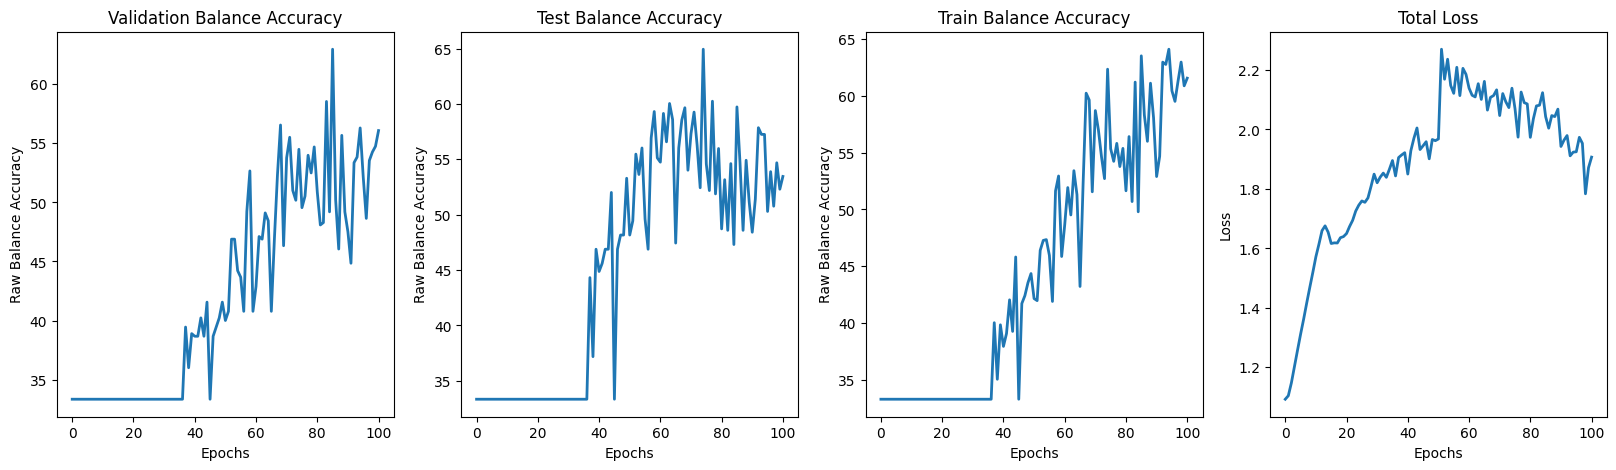

Max Validation Balance Accuracy - 63.0
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  101
Learning Rate:  0.0004998111014986735


100%|██████████| 119/119 [00:04<00:00, 24.42it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.14705882352941177
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.14705882352941177
class2 recall: 0.95



100%|██████████| 120/120 [00:03<00:00, 30.48it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.14705882352941177
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.95



100%|██████████| 360/360 [00:11<00:00, 31.36it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.17475728155339806
class2 recall: 0.9502762430939227
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.11650485436893204
class2 recall: 0.9558011049723757
Epoch:  102
Learning Rate:  0.0004992445487252689



100%|██████████| 119/119 [00:04<00:00, 27.03it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.08823529411764706
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.14705882352941177
class2 recall: 0.95



100%|██████████| 120/120 [00:03<00:00, 32.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.029411764705882353
class2 recall: 0.9333333333333333



100%|██████████| 360/360 [00:11<00:00, 31.36it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8157894736842105
class1 recall: 0.0970873786407767
class2 recall: 0.9392265193370166
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.1262135922330097
class2 recall: 0.9668508287292817
Epoch:  103
Learning Rate:  0.0004983007697636659



100%|██████████| 119/119 [00:03<00:00, 32.41it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.35294117647058826
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.17647058823529413
class2 recall: 0.9166666666666666


100%|██████████| 120/120 [00:03<00:00, 31.92it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.17647058823529413
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.0
class2 recall: 0.9333333333333333



100%|██████████| 360/360 [00:11<00:00, 30.50it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.23300970873786409
class2 recall: 0.9226519337016574
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.11650485436893204
class2 recall: 0.9668508287292817
Epoch:  104
Learning Rate:  0.0004969804777275899



100%|██████████| 119/119 [00:03<00:00, 32.25it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.058823529411764705
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.17647058823529413
class2 recall: 0.95



100%|██████████| 120/120 [00:04<00:00, 28.53it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.08823529411764706
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.0
class2 recall: 0.9333333333333333



100%|██████████| 360/360 [00:11<00:00, 32.73it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6052631578947368
class1 recall: 0.02912621359223301
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6578947368421053
class1 recall: 0.14563106796116504
class2 recall: 0.9723756906077348
Epoch:  105
Learning Rate:  0.0004952846702217887



100%|██████████| 119/119 [00:03<00:00, 32.03it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.35294117647058826
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.14705882352941177
class2 recall: 0.9333333333333333



100%|██████████| 120/120 [00:05<00:00, 23.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.08823529411764706
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666



100%|██████████| 360/360 [00:10<00:00, 35.17it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6052631578947368
class1 recall: 0.32038834951456313
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6578947368421053
class1 recall: 0.10679611650485436
class2 recall: 0.9668508287292817


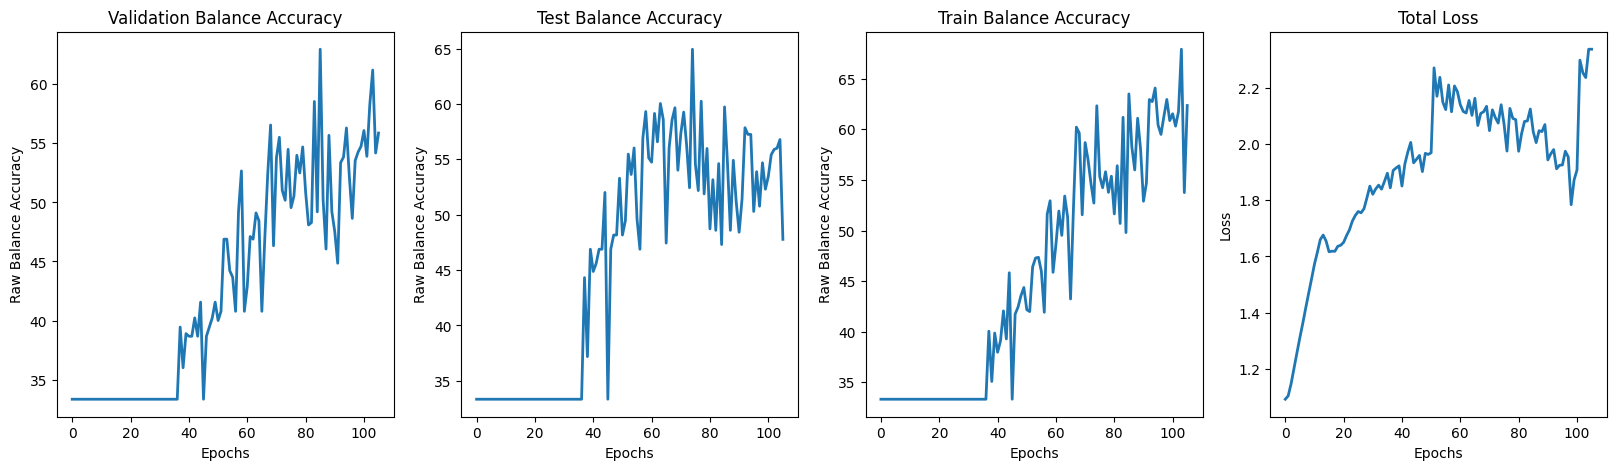

Max Validation Balance Accuracy - 63.0
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  106
Learning Rate:  0.0004932146285882477


100%|██████████| 119/119 [00:04<00:00, 24.70it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.35294117647058826
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.17647058823529413
class2 recall: 0.9166666666666666



100%|██████████| 120/120 [00:04<00:00, 29.76it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.29411764705882354
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666



100%|██████████| 360/360 [00:11<00:00, 30.87it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.631578947368421
class1 recall: 0.27184466019417475
class2 recall: 0.9171270718232044
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.14563106796116504
class2 recall: 0.9779005524861878
Epoch:  107
Learning Rate:  0.0004907719169380163



100%|██████████| 119/119 [00:04<00:00, 27.65it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.88
class1 recall: 0.14705882352941177
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666



100%|██████████| 120/120 [00:03<00:00, 31.84it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.14705882352941177
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666


100%|██████████| 360/360 [00:11<00:00, 31.19it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.14563106796116504
class2 recall: 0.9060773480662984
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7105263157894737
class1 recall: 0.1650485436893204
class2 recall: 0.9668508287292817
Epoch:  108
Learning Rate:  0.0004879583809693737



100%|██████████| 119/119 [00:03<00:00, 32.31it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.14705882352941177
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.17647058823529413
class2 recall: 0.9333333333333333



100%|██████████| 120/120 [00:03<00:00, 32.10it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.0
class2 recall: 0.9166666666666666



100%|██████████| 360/360 [00:11<00:00, 31.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.1650485436893204
class2 recall: 0.9502762430939227
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.1553398058252427
class2 recall: 0.9723756906077348
Epoch:  109
Learning Rate:  0.00048477614657323176



100%|██████████| 119/119 [00:03<00:00, 32.38it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.0
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.20588235294117646
class2 recall: 0.9166666666666666



100%|██████████| 120/120 [00:04<00:00, 29.08it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.029411764705882353
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.0
class2 recall: 0.9166666666666666



100%|██████████| 360/360 [00:11<00:00, 32.16it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6447368421052632
class1 recall: 0.009708737864077669
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6710526315789473
class1 recall: 0.14563106796116504
class2 recall: 0.9723756906077348
Epoch:  110
Learning Rate:  0.00048122761822682366



100%|██████████| 119/119 [00:03<00:00, 32.11it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.058823529411764705
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.17647058823529413
class2 recall: 0.9166666666666666



100%|██████████| 120/120 [00:04<00:00, 24.14it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.029411764705882353
class2 recall: 0.9166666666666666



100%|██████████| 360/360 [00:10<00:00, 34.77it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7631578947368421
class1 recall: 0.05825242718446602
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.13592233009708737
class2 recall: 0.9723756906077348


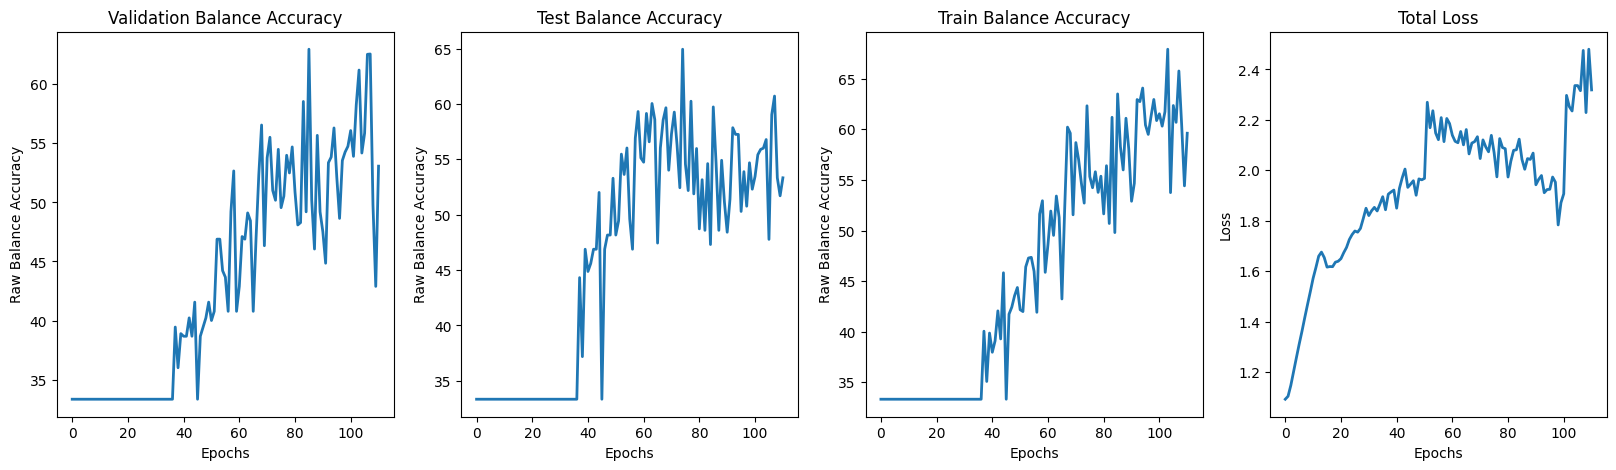

Max Validation Balance Accuracy - 63.0
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  111
Learning Rate:  0.00047731547717689556


100%|██████████| 119/119 [00:04<00:00, 25.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.88
class1 recall: 0.0
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666



100%|██████████| 120/120 [00:04<00:00, 28.55it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9230769230769231
class1 recall: 0.0
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.058823529411764705
class2 recall: 0.9166666666666666



100%|██████████| 360/360 [00:11<00:00, 31.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.019417475728155338
class2 recall: 0.9337016574585635
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7105263157894737
class1 recall: 0.13592233009708737
class2 recall: 0.9668508287292817
Epoch:  112
Learning Rate:  0.00047304267941377265



100%|██████████| 119/119 [00:04<00:00, 26.44it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.47058823529411764
class2 recall: 0.65
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.17647058823529413
class2 recall: 0.9166666666666666



100%|██████████| 120/120 [00:03<00:00, 31.84it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.5294117647058824
class2 recall: 0.6666666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.058823529411764705
class2 recall: 0.9166666666666666



100%|██████████| 360/360 [00:11<00:00, 30.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.5436893203883495
class2 recall: 0.7624309392265194
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.17475728155339806
class2 recall: 0.9613259668508287
Epoch:  113
Learning Rate:  0.0004684124534378307



100%|██████████| 119/119 [00:03<00:00, 31.85it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.5
class2 recall: 0.6166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.17647058823529413
class2 recall: 0.9



100%|██████████| 120/120 [00:03<00:00, 32.02it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4411764705882353
class2 recall: 0.5166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.058823529411764705
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:11<00:00, 30.76it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.5145631067961165
class2 recall: 0.7292817679558011
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.24271844660194175
class2 recall: 0.9502762430939227
Epoch:  114
Learning Rate:  0.0004634282978200604



100%|██████████| 119/119 [00:03<00:00, 31.20it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.23529411764705882
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.14705882352941177
class2 recall: 0.9


100%|██████████| 120/120 [00:04<00:00, 26.79it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.20588235294117646
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.058823529411764705
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:11<00:00, 32.70it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.3592233009708738
class2 recall: 0.9060773480662984
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.75
class1 recall: 0.2621359223300971
class2 recall: 0.9502762430939227
Epoch:  115
Learning Rate:  0.000458093978558568



100%|██████████| 119/119 [00:03<00:00, 30.30it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.08823529411764706
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.17647058823529413
class2 recall: 0.8833333333333333



100%|██████████| 120/120 [00:05<00:00, 23.65it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.14705882352941177
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.14705882352941177
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:10<00:00, 33.76it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8289473684210527
class1 recall: 0.20388349514563106
class2 recall: 0.9281767955801105
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7368421052631579
class1 recall: 0.23300970873786409
class2 recall: 0.9558011049723757


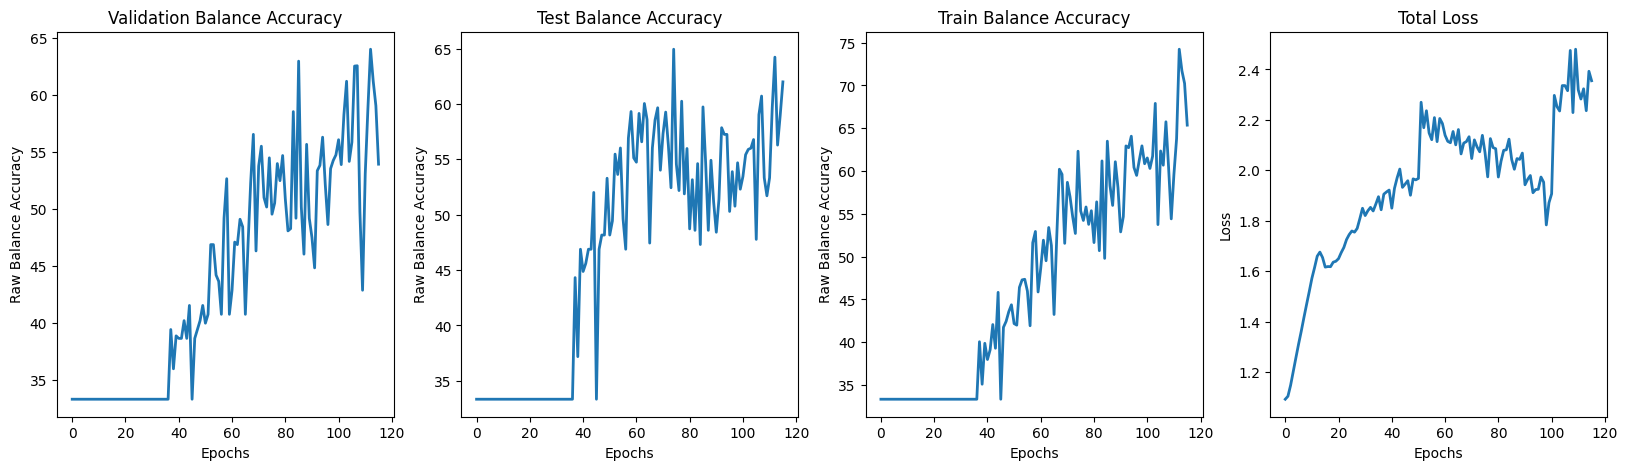

Max Validation Balance Accuracy - 64.0
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  116
Learning Rate:  0.0004524135262330098


100%|██████████| 119/119 [00:05<00:00, 23.03it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.17647058823529413
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.23529411764705882
class2 recall: 0.8833333333333333



100%|██████████| 120/120 [00:03<00:00, 31.51it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.17647058823529413
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.11764705882352941
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:11<00:00, 30.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5657894736842105
class1 recall: 0.20388349514563106
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.2524271844660194
class2 recall: 0.9558011049723757
Epoch:  117
Learning Rate:  0.0004463912329591104



100%|██████████| 119/119 [00:04<00:00, 26.80it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.2647058823529412
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.11764705882352941
class2 recall: 0.8833333333333333



100%|██████████| 120/120 [00:03<00:00, 31.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.17647058823529413
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.11764705882352941
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:11<00:00, 31.25it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.2912621359223301
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.2524271844660194
class2 recall: 0.9613259668508287
Epoch:  118
Learning Rate:  0.000440031649145566



100%|██████████| 119/119 [00:03<00:00, 32.20it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.28
class1 recall: 0.11764705882352941
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.14705882352941177
class2 recall: 0.8833333333333333



100%|██████████| 120/120 [00:03<00:00, 31.23it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.11764705882352941
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.20588235294117646
class2 recall: 0.8666666666666667



100%|██████████| 360/360 [00:11<00:00, 30.94it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5131578947368421
class1 recall: 0.18446601941747573
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.27184466019417475
class2 recall: 0.9613259668508287
Epoch:  119
Learning Rate:  0.00043333958005578203



100%|██████████| 119/119 [00:03<00:00, 31.32it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.11764705882352941
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.17647058823529413
class2 recall: 0.9



100%|██████████| 120/120 [00:04<00:00, 26.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.11764705882352941
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.20588235294117646
class2 recall: 0.8666666666666667



100%|██████████| 360/360 [00:11<00:00, 32.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5921052631578947
class1 recall: 0.14563106796116504
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.2815533980582524
class2 recall: 0.9558011049723757
Epoch:  120
Learning Rate:  0.0004263200821770461



100%|██████████| 119/119 [00:04<00:00, 29.68it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.23529411764705882
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.17647058823529413
class2 recall: 0.9



100%|██████████| 120/120 [00:04<00:00, 24.41it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.14705882352941177
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.20588235294117646
class2 recall: 0.8666666666666667



100%|██████████| 360/360 [00:10<00:00, 33.81it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.75
class1 recall: 0.27184466019417475
class2 recall: 0.9558011049723757
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7105263157894737
class1 recall: 0.2815533980582524
class2 recall: 0.9502762430939227


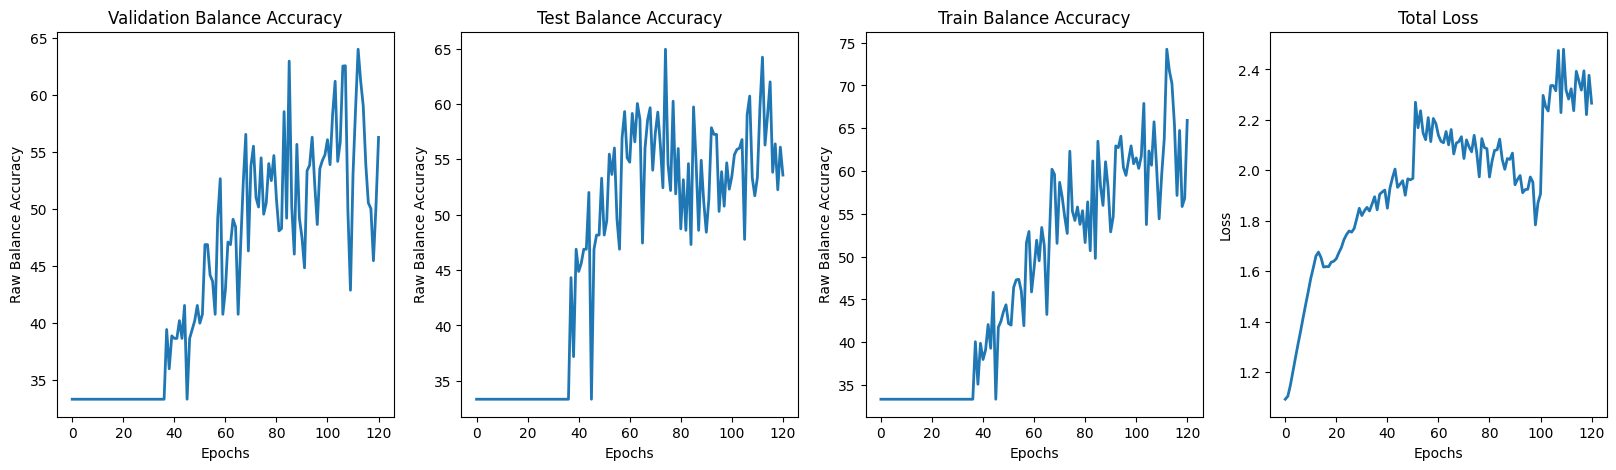

Max Validation Balance Accuracy - 64.0
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  121
Learning Rate:  0.00041897845939987553


100%|██████████| 119/119 [00:05<00:00, 23.24it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.28
class1 recall: 0.08823529411764706
class2 recall: 0.9833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.14705882352941177
class2 recall: 0.8833333333333333



100%|██████████| 120/120 [00:03<00:00, 31.13it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.14705882352941177
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.20588235294117646
class2 recall: 0.8666666666666667



100%|██████████| 360/360 [00:11<00:00, 30.41it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5263157894736842
class1 recall: 0.0970873786407767
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7368421052631579
class1 recall: 0.3106796116504854
class2 recall: 0.9502762430939227
Epoch:  122
Learning Rate:  0.0004113202590104299



100%|██████████| 119/119 [00:04<00:00, 28.22it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.2647058823529412
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.23529411764705882
class2 recall: 0.8833333333333333



100%|██████████| 120/120 [00:03<00:00, 31.37it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.2647058823529412
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.20588235294117646
class2 recall: 0.8333333333333334


100%|██████████| 360/360 [00:11<00:00, 30.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8289473684210527
class1 recall: 0.2912621359223301
class2 recall: 0.9060773480662984
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.75
class1 recall: 0.3300970873786408
class2 recall: 0.9392265193370166
Epoch:  123
Learning Rate:  0.000403351267499015



100%|██████████| 119/119 [00:03<00:00, 31.29it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.11764705882352941
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.2647058823529412
class2 recall: 0.85



100%|██████████| 120/120 [00:03<00:00, 30.52it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.08823529411764706
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.20588235294117646
class2 recall: 0.85



100%|██████████| 360/360 [00:11<00:00, 30.99it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.1941747572815534
class2 recall: 0.9502762430939227
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.75
class1 recall: 0.36893203883495146
class2 recall: 0.9447513812154696
Epoch:  124
Learning Rate:  0.0003950775061878452



100%|██████████| 119/119 [00:03<00:00, 31.04it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.23529411764705882
class2 recall: 0.85


100%|██████████| 120/120 [00:05<00:00, 23.88it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.29411764705882354
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.20588235294117646
class2 recall: 0.85



100%|██████████| 360/360 [00:10<00:00, 33.92it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8157894736842105
class1 recall: 0.33980582524271846
class2 recall: 0.9171270718232044
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7631578947368421
class1 recall: 0.3786407766990291
class2 recall: 0.9447513812154696
Epoch:  125
Learning Rate:  0.0003865052266813685



100%|██████████| 119/119 [00:04<00:00, 25.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.058823529411764705
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.29411764705882354
class2 recall: 0.8333333333333334



100%|██████████| 120/120 [00:04<00:00, 27.82it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.058823529411764705
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.23529411764705882
class2 recall: 0.8666666666666667


100%|██████████| 360/360 [00:11<00:00, 31.38it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7631578947368421
class1 recall: 0.10679611650485436
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7631578947368421
class1 recall: 0.3786407766990291
class2 recall: 0.9447513812154696


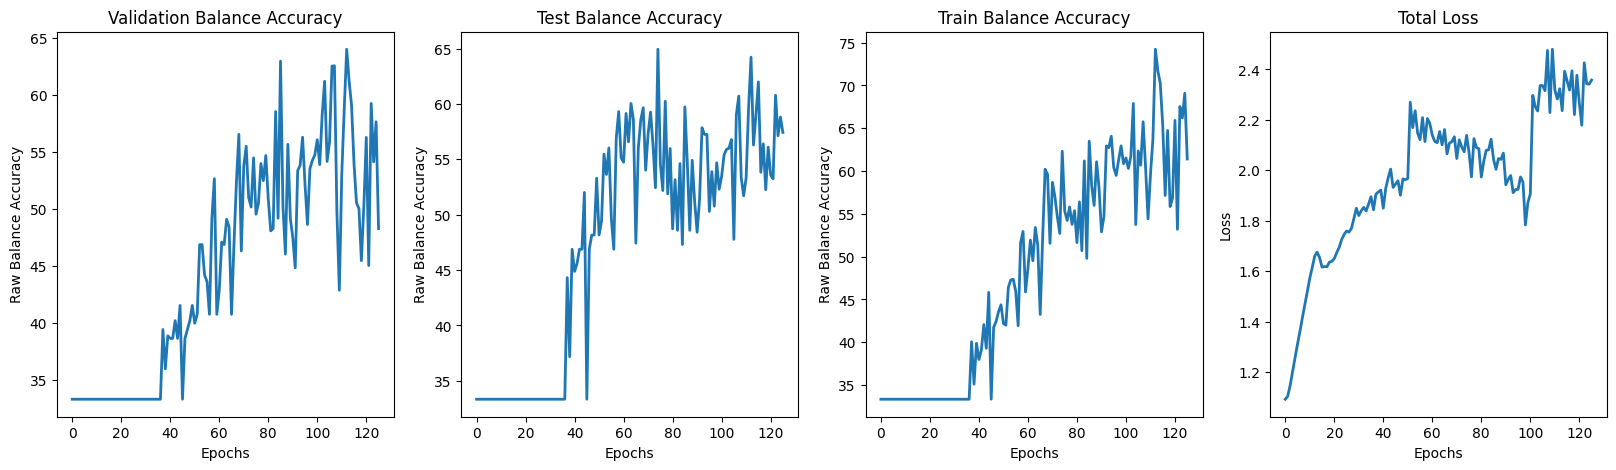

Max Validation Balance Accuracy - 64.0
Max Test Balance Accuracy - 64.9
Min Total Loss - 1.1
Epoch:  126
Learning Rate:  0.0003776409061425918


100%|██████████| 119/119 [00:04<00:00, 28.99it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.23529411764705882
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.23529411764705882
class2 recall: 0.85



100%|██████████| 120/120 [00:03<00:00, 30.60it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4411764705882353
class2 recall: 0.85


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.23529411764705882
class2 recall: 0.8666666666666667


100%|██████████| 360/360 [00:11<00:00, 30.04it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8157894736842105
class1 recall: 0.4077669902912621
class2 recall: 0.9171270718232044
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7894736842105263
class1 recall: 0.3592233009708738
class2 recall: 0.9392265193370166
Epoch:  127
Learning Rate:  0.0003684912423989754



100%|██████████| 119/119 [00:03<00:00, 30.82it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.14705882352941177
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.23529411764705882
class2 recall: 0.8333333333333334



100%|██████████| 120/120 [00:03<00:00, 30.79it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.17647058823529413
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.20588235294117646
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:11<00:00, 30.23it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.3106796116504854
class2 recall: 0.9558011049723757
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7631578947368421
class1 recall: 0.3592233009708738
class2 recall: 0.9337016574585635
Epoch:  128
Learning Rate:  0.0003590631488815944


100%|██████████| 119/119 [00:03<00:00, 31.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.5
class2 recall: 0.6
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.2647058823529412
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 24.57it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.6764705882352942
class2 recall: 0.5333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.20588235294117646
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:10<00:00, 32.93it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.6699029126213593
class2 recall: 0.7458563535911602
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7631578947368421
class1 recall: 0.39805825242718446
class2 recall: 0.9447513812154696
Epoch:  129
Learning Rate:  0.00034936374940139223



100%|██████████| 119/119 [00:04<00:00, 27.48it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.4117647058823529
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.29411764705882354
class2 recall: 0.8333333333333334



100%|██████████| 120/120 [00:04<00:00, 25.06it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.4117647058823529
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.2647058823529412
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:11<00:00, 31.32it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.5145631067961165
class2 recall: 0.8784530386740331
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7763157894736842
class1 recall: 0.4077669902912621
class2 recall: 0.9447513812154696
Epoch:  130
Learning Rate:  0.0003394003727664709



100%|██████████| 119/119 [00:05<00:00, 23.59it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.29411764705882354
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.23529411764705882
class2 recall: 0.8333333333333334



100%|██████████| 120/120 [00:03<00:00, 30.97it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.35294117647058826
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.23529411764705882
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:11<00:00, 30.08it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7894736842105263
class1 recall: 0.32038834951456313
class2 recall: 0.9337016574585635
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8026315789473685
class1 recall: 0.3883495145631068
class2 recall: 0.9392265193370166


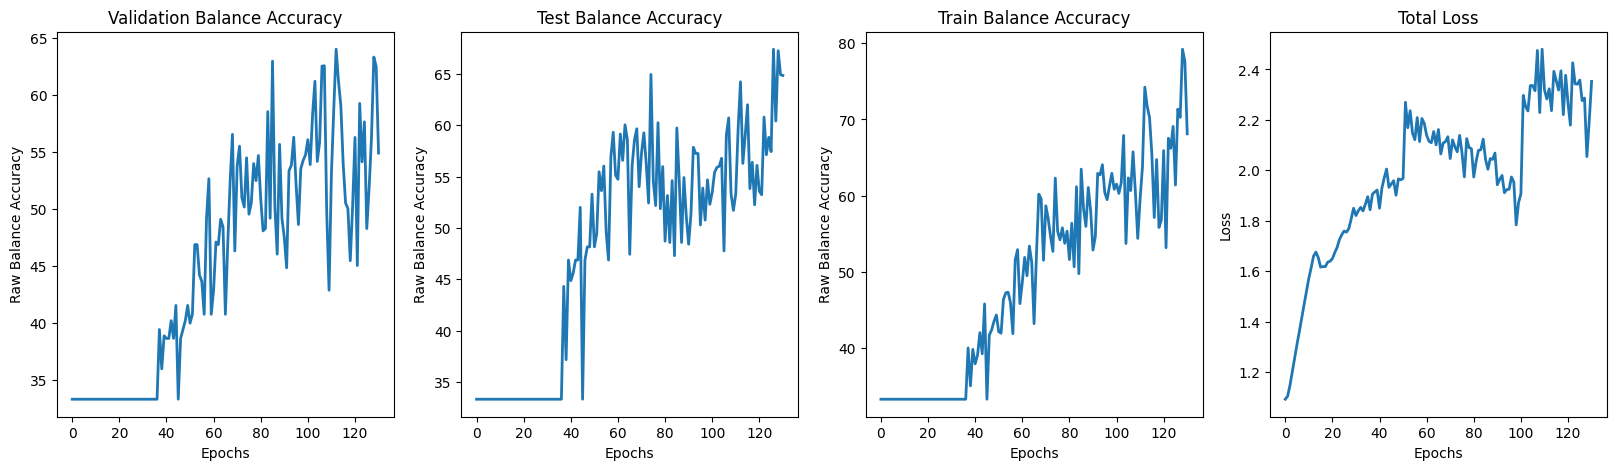

Max Validation Balance Accuracy - 64.0
Max Test Balance Accuracy - 67.4
Min Total Loss - 1.1
Epoch:  131
Learning Rate:  0.0003291805472444886


100%|██████████| 119/119 [00:03<00:00, 30.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.36
class1 recall: 0.2647058823529412
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.23529411764705882
class2 recall: 0.8333333333333334



100%|██████████| 120/120 [00:03<00:00, 31.25it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.46153846153846156
class1 recall: 0.29411764705882354
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.3235294117647059
class2 recall: 0.8666666666666667



100%|██████████| 360/360 [00:12<00:00, 29.51it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6578947368421053
class1 recall: 0.33980582524271846
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8289473684210527
class1 recall: 0.39805825242718446
class2 recall: 0.9337016574585635
Epoch:  132
Learning Rate:  0.00031871199487434486



100%|██████████| 119/119 [00:03<00:00, 30.43it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.2647058823529412
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.20588235294117646
class2 recall: 0.8333333333333334



100%|██████████| 120/120 [00:04<00:00, 26.79it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.2647058823529412
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.35294117647058826
class2 recall: 0.8833333333333333



100%|██████████| 360/360 [00:11<00:00, 31.23it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.4174757281553398
class2 recall: 0.9558011049723757
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.44660194174757284
class2 recall: 0.9337016574585635
Epoch:  133
Learning Rate:  0.00030800262563145494



100%|██████████| 119/119 [00:04<00:00, 28.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.6764705882352942
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.2647058823529412
class2 recall: 0.8333333333333334



100%|██████████| 120/120 [00:05<00:00, 23.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.5882352941176471
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.35294117647058826
class2 recall: 0.8666666666666667



100%|██████████| 360/360 [00:11<00:00, 32.24it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.6310679611650486
class2 recall: 0.8397790055248618
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.47572815533980584
class2 recall: 0.9281767955801105


Epoch:  134
Learning Rate:  0.00029706053145101924


100%|██████████| 119/119 [00:05<00:00, 22.81it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.29411764705882354
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.29411764705882354
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 29.85it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.29411764705882354
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.38235294117647056
class2 recall: 0.85



100%|██████████| 360/360 [00:12<00:00, 29.79it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6447368421052632
class1 recall: 0.3883495145631068
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8157894736842105
class1 recall: 0.47572815533980584
class2 recall: 0.9337016574585635
Epoch:  135
Learning Rate:  0.0002858939801138062



100%|██████████| 119/119 [00:04<00:00, 27.27it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.058823529411764705
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.29411764705882354
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:03<00:00, 30.71it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.029411764705882353
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.38235294117647056
class2 recall: 0.85


100%|██████████| 360/360 [00:12<00:00, 29.28it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.1553398058252427
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8157894736842105
class1 recall: 0.47572815533980584
class2 recall: 0.9337016574585635


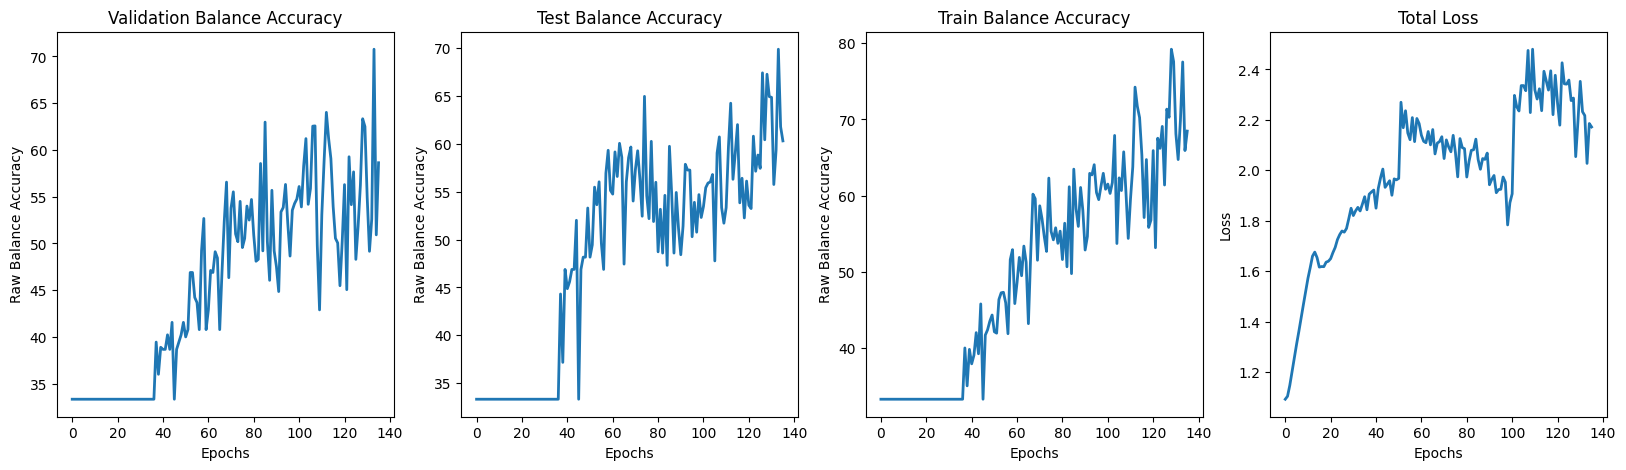

Max Validation Balance Accuracy - 70.8
Max Test Balance Accuracy - 69.9
Min Total Loss - 1.1
Epoch:  136
Learning Rate:  0.0002745114089990659


100%|██████████| 119/119 [00:03<00:00, 30.80it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.7352941176470589
class2 recall: 0.43333333333333335
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.3235294117647059
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:03<00:00, 30.57it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.7058823529411765
class2 recall: 0.45
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.38235294117647056
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 29.24it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.8155339805825242
class2 recall: 0.6077348066298343
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.46601941747572817
class2 recall: 0.9337016574585635
Epoch:  137
Learning Rate:  0.00026292141870929776



100%|██████████| 119/119 [00:03<00:00, 31.31it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.08823529411764706
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.38235294117647056
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 24.37it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.029411764705882353
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.4117647058823529
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 32.72it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.20388349514563106
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.4563106796116505
class2 recall: 0.9171270718232044
Epoch:  138
Learning Rate:  0.0002511327665716863



100%|██████████| 119/119 [00:04<00:00, 25.97it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.2647058823529412
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.2647058823529412
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 26.27it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.29411764705882354
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.29411764705882354
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:11<00:00, 30.38it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.4854368932038835
class2 recall: 0.9116022099447514
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.4174757281553398
class2 recall: 0.9281767955801105
Epoch:  139
Learning Rate:  0.0002391543600211173



100%|██████████| 119/119 [00:04<00:00, 23.89it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.3235294117647059
class2 recall: 0.7333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.29411764705882354
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:03<00:00, 30.30it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.4411764705882353
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.2647058823529412
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 29.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.5145631067961165
class2 recall: 0.8839779005524862
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.4368932038834951
class2 recall: 0.9226519337016574
Epoch:  140
Learning Rate:  0.0002269952498697734



100%|██████████| 119/119 [00:03<00:00, 30.45it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.4117647058823529
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:03<00:00, 30.21it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.35294117647058826
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.2647058823529412
class2 recall: 0.8166666666666667


100%|██████████| 360/360 [00:12<00:00, 29.67it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.5728155339805825
class2 recall: 0.9005524861878453
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.44660194174757284
class2 recall: 0.9116022099447514


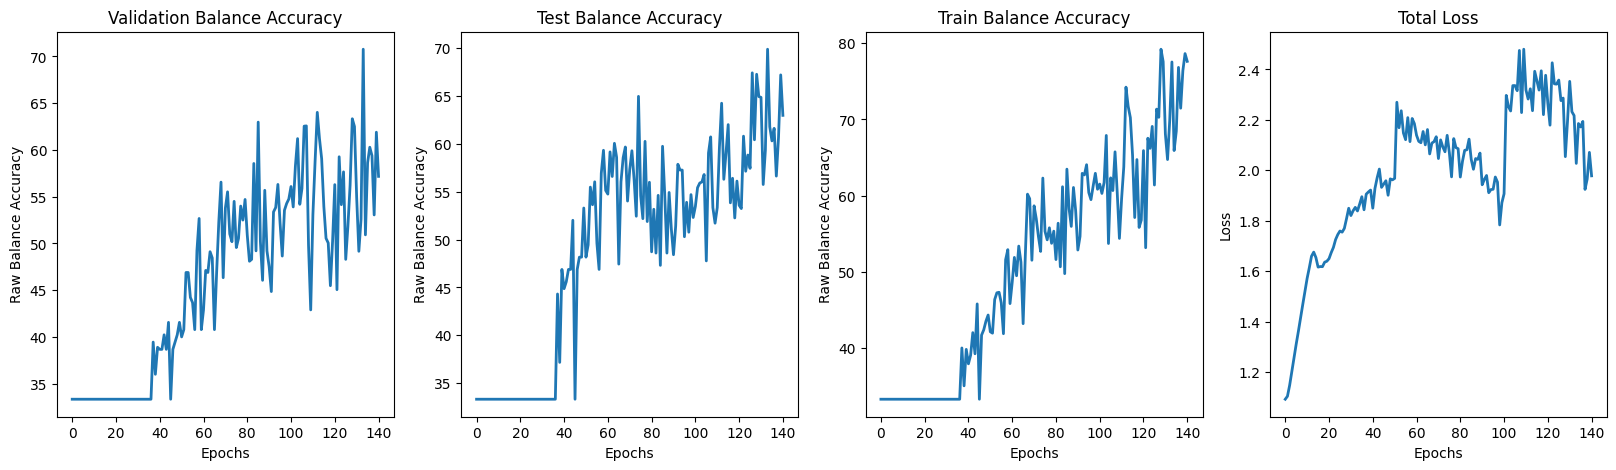

Max Validation Balance Accuracy - 70.8
Max Test Balance Accuracy - 69.9
Min Total Loss - 1.1
Epoch:  141
Learning Rate:  0.00021466462346839507


100%|██████████| 119/119 [00:03<00:00, 30.98it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.84
class1 recall: 0.38235294117647056
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.3235294117647059
class2 recall: 0.8333333333333334



100%|██████████| 120/120 [00:04<00:00, 24.59it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.4117647058823529
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.2647058823529412
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 31.62it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.46601941747572817
class2 recall: 0.8839779005524862
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.4368932038834951
class2 recall: 0.9226519337016574
Epoch:  142
Learning Rate:  0.00020217179776437256


100%|██████████| 119/119 [00:04<00:00, 26.68it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.7352941176470589
class2 recall: 0.65
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.3235294117647059
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 24.73it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.5882352941176471
class2 recall: 0.7333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.2647058823529412
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 31.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.7669902912621359
class2 recall: 0.8011049723756906
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.44660194174757284
class2 recall: 0.9171270718232044
Epoch:  143
Learning Rate:  0.00018952621226191733



100%|██████████| 119/119 [00:05<00:00, 23.45it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.38235294117647056
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.35294117647058826
class2 recall: 0.8



100%|██████████| 120/120 [00:03<00:00, 30.39it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.20588235294117646
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.29411764705882354
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 29.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.42718446601941745
class2 recall: 0.9337016574585635
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.4854368932038835
class2 recall: 0.9060773480662984
Epoch:  144
Learning Rate:  0.00017673742188962856



100%|██████████| 119/119 [00:04<00:00, 29.04it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.5294117647058824
class2 recall: 0.7333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.38235294117647056
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:03<00:00, 30.24it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8846153846153846
class1 recall: 0.47058823529411764
class2 recall: 0.7166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.3235294117647059
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 29.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.6019417475728155
class2 recall: 0.856353591160221
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.4563106796116505
class2 recall: 0.9116022099447514
Epoch:  145
Learning Rate:  0.00016381508978084673



100%|██████████| 119/119 [00:03<00:00, 30.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.6470588235294118
class2 recall: 0.5833333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.38235294117647056
class2 recall: 0.8



100%|██████████| 120/120 [00:04<00:00, 26.60it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.6470588235294118
class2 recall: 0.6333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 30.66it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.7864077669902912
class2 recall: 0.7458563535911602
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.4854368932038835
class2 recall: 0.9005524861878453


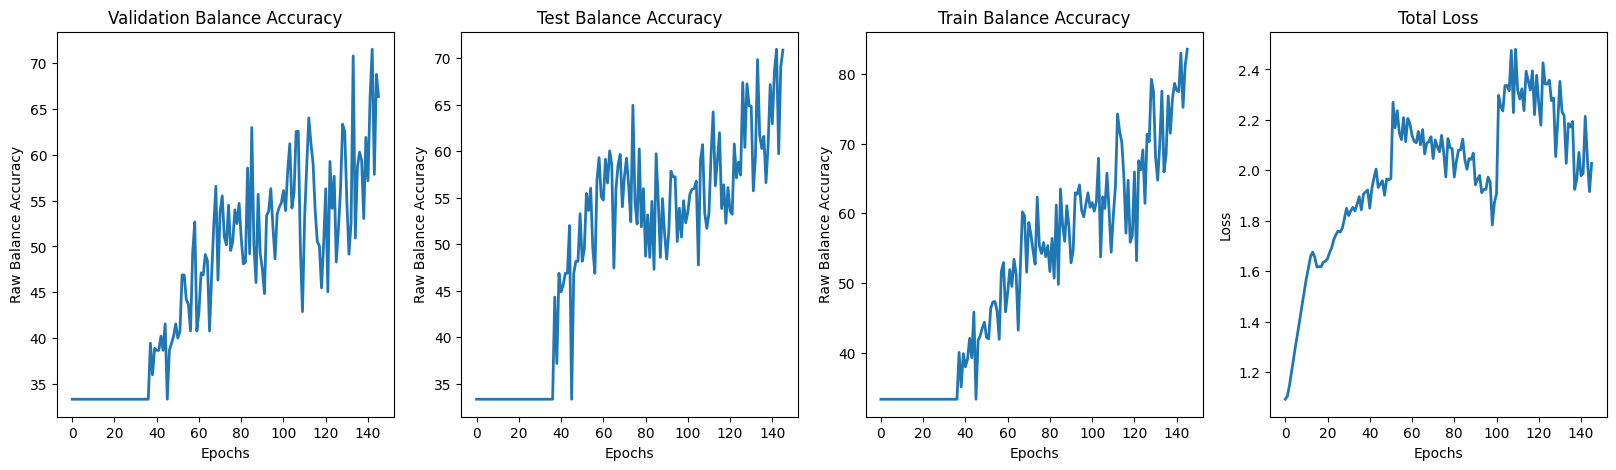

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 71.0
Min Total Loss - 1.1
Epoch:  146
Learning Rate:  0.0001507689799722479


100%|██████████| 119/119 [00:04<00:00, 26.94it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.5294117647058824
class2 recall: 0.7333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4117647058823529
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 23.45it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4117647058823529
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 31.15it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.6504854368932039
class2 recall: 0.9005524861878453
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.5436893203883495
class2 recall: 0.8950276243093923
Epoch:  147
Learning Rate:  0.0001376089500261958



100%|██████████| 119/119 [00:05<00:00, 21.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.20588235294117646
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.4411764705882353
class2 recall: 0.8



100%|██████████| 120/120 [00:04<00:00, 29.92it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.14705882352941177
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 29.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.36893203883495146
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.5728155339805825
class2 recall: 0.9005524861878453
Epoch:  148
Learning Rate:  0.00012434494358242747



100%|██████████| 119/119 [00:04<00:00, 29.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.7352941176470589
class2 recall: 0.6666666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.4411764705882353
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:03<00:00, 30.24it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.6176470588235294
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4411764705882353
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 29.32it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.8252427184466019
class2 recall: 0.8176795580110497
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.5922330097087378
class2 recall: 0.9005524861878453
Epoch:  149
Learning Rate:  0.00011098698284469807



100%|██████████| 119/119 [00:03<00:00, 30.89it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.47058823529411764
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4117647058823529
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:03<00:00, 30.67it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.38235294117647056
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4117647058823529
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 29.23it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.5922330097087378
class2 recall: 0.9171270718232044
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.6019417475728155
class2 recall: 0.9005524861878453
Epoch:  150
Learning Rate:  9.754516100806417e-05



100%|██████████| 119/119 [00:03<00:00, 31.31it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.7058823529411765
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4411764705882353
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 24.93it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.6176470588235294
class2 recall: 0.7333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.4117647058823529
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 31.91it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.7864077669902912
class2 recall: 0.861878453038674
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.5922330097087378
class2 recall: 0.9060773480662984


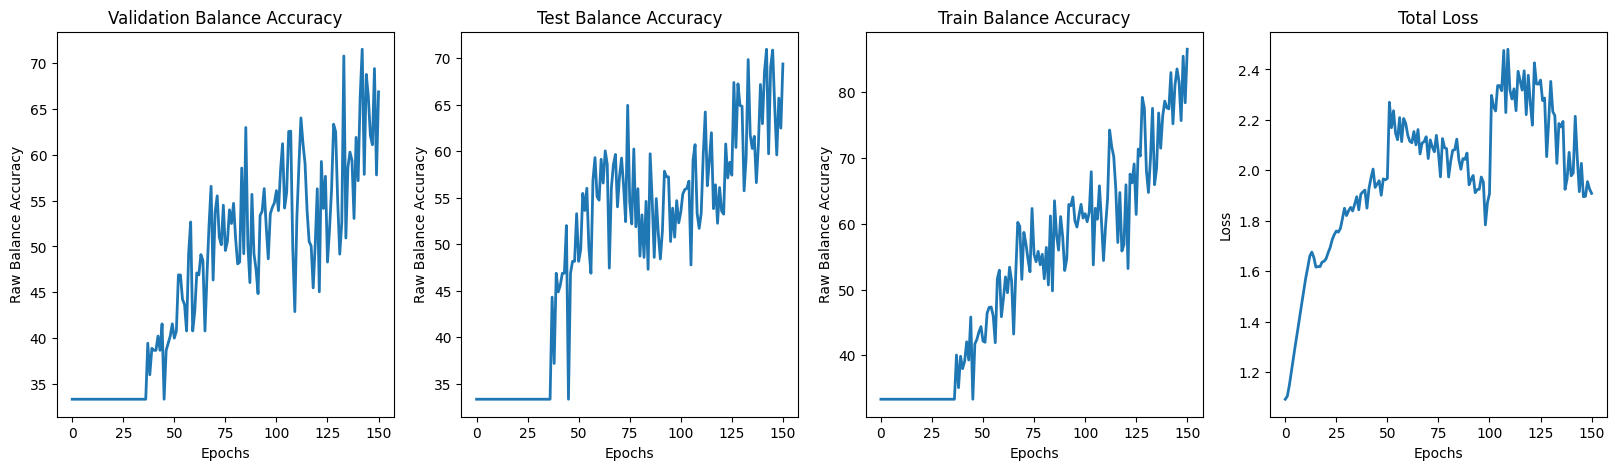

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 71.0
Min Total Loss - 1.1
Epoch:  151
Learning Rate:  0.0004998111014986735


100%|██████████| 119/119 [00:04<00:00, 25.23it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.28
class1 recall: 0.5
class2 recall: 0.75
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.4411764705882353
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 25.80it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.5588235294117647
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 30.66it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5394736842105263
class1 recall: 0.6504854368932039
class2 recall: 0.8729281767955801
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.5339805825242718
class2 recall: 0.9226519337016574
Epoch:  152
Learning Rate:  0.0004992445487252689



100%|██████████| 119/119 [00:05<00:00, 22.71it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.23529411764705882
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.4117647058823529
class2 recall: 0.8



100%|██████████| 120/120 [00:04<00:00, 29.87it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.3235294117647059
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.35294117647058826
class2 recall: 0.8



100%|██████████| 360/360 [00:12<00:00, 28.80it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.5048543689320388
class2 recall: 0.9171270718232044
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.5145631067961165
class2 recall: 0.9226519337016574
Epoch:  153
Learning Rate:  0.0004983007697636659



100%|██████████| 119/119 [00:04<00:00, 27.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.23529411764705882
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 29.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.17647058823529413
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.38235294117647056
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 29.44it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.4077669902912621
class2 recall: 0.9502762430939227
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.5339805825242718
class2 recall: 0.9226519337016574
Epoch:  154
Learning Rate:  0.0004969804777275899



100%|██████████| 119/119 [00:03<00:00, 30.32it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.5588235294117647
class2 recall: 0.75
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.38235294117647056
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 27.96it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.5588235294117647
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.35294117647058826
class2 recall: 0.85



100%|██████████| 360/360 [00:12<00:00, 29.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6447368421052632
class1 recall: 0.6699029126213593
class2 recall: 0.8784530386740331
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.5436893203883495
class2 recall: 0.9226519337016574
Epoch:  155
Learning Rate:  0.0004952846702217887



100%|██████████| 119/119 [00:03<00:00, 30.01it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.14705882352941177
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.35294117647058826
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 22.98it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8846153846153846
class1 recall: 0.2647058823529412
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.38235294117647056
class2 recall: 0.85



100%|██████████| 360/360 [00:11<00:00, 32.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.4368932038834951
class2 recall: 0.9337016574585635
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.5631067961165048
class2 recall: 0.9337016574585635


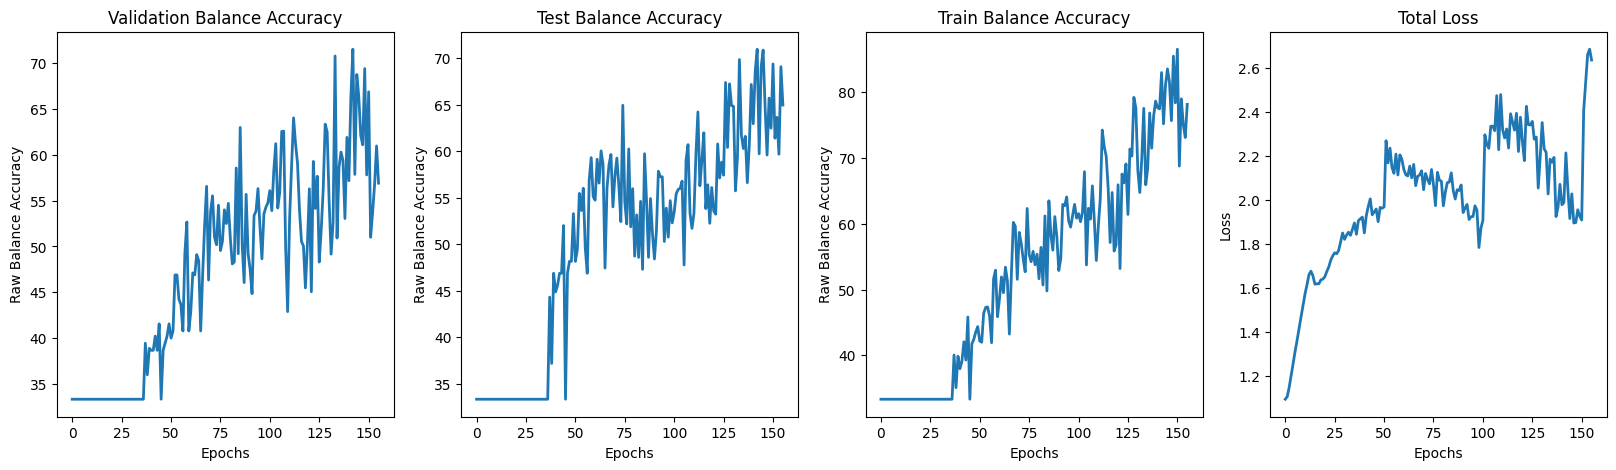

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 71.0
Min Total Loss - 1.1
Epoch:  156
Learning Rate:  0.0004932146285882477


100%|██████████| 119/119 [00:05<00:00, 23.58it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.88
class1 recall: 0.2647058823529412
class2 recall: 0.2833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.38235294117647056
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 26.83it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9230769230769231
class1 recall: 0.38235294117647056
class2 recall: 0.2833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.35294117647058826
class2 recall: 0.85



100%|██████████| 360/360 [00:12<00:00, 29.76it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.5048543689320388
class2 recall: 0.425414364640884
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.5728155339805825
class2 recall: 0.9447513812154696
Epoch:  157
Learning Rate:  0.0004907719169380163



100%|██████████| 119/119 [00:05<00:00, 22.70it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.08823529411764706
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 29.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.11764705882352941
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.29411764705882354
class2 recall: 0.85



100%|██████████| 360/360 [00:12<00:00, 28.39it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.33980582524271846
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.5339805825242718
class2 recall: 0.9502762430939227
Epoch:  158
Learning Rate:  0.0004879583809693737



100%|██████████| 119/119 [00:04<00:00, 29.53it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.029411764705882353
class2 recall: 0.7166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.38235294117647056
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 29.44it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.0
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.38235294117647056
class2 recall: 0.85



100%|██████████| 360/360 [00:12<00:00, 28.99it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.038834951456310676
class2 recall: 0.7513812154696132
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.5339805825242718
class2 recall: 0.9447513812154696
Epoch:  159
Learning Rate:  0.00048477614657323176



100%|██████████| 119/119 [00:03<00:00, 30.45it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.9117647058823529
class2 recall: 0.26666666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.35294117647058826
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:04<00:00, 24.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.8529411764705882
class2 recall: 0.2
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4117647058823529
class2 recall: 0.85



100%|██████████| 360/360 [00:11<00:00, 30.94it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7894736842105263
class1 recall: 0.9611650485436893
class2 recall: 0.3370165745856354
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.5436893203883495
class2 recall: 0.9337016574585635
Epoch:  160
Learning Rate:  0.00048122761822682366



100%|██████████| 119/119 [00:04<00:00, 26.90it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.38235294117647056
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:05<00:00, 22.68it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.08823529411764706
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4117647058823529
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:11<00:00, 31.45it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7368421052631579
class1 recall: 0.20388349514563106
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.5728155339805825
class2 recall: 0.9281767955801105


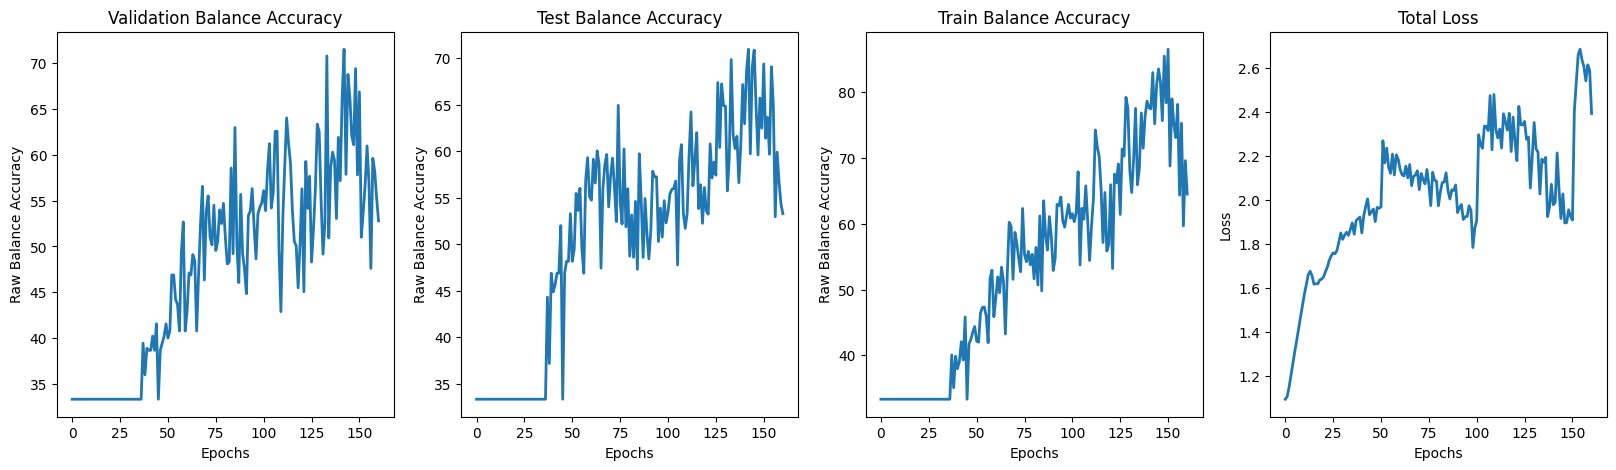

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 71.0
Min Total Loss - 1.1
Epoch:  161
Learning Rate:  0.00047731547717689556


100%|██████████| 119/119 [00:04<00:00, 23.84it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.7058823529411765
class2 recall: 0.6833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.4117647058823529
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:04<00:00, 26.07it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.5294117647058824
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4117647058823529
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 28.66it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7368421052631579
class1 recall: 0.7572815533980582
class2 recall: 0.8397790055248618
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.5339805825242718
class2 recall: 0.9337016574585635
Epoch:  162
Learning Rate:  0.00047304267941377265



100%|██████████| 119/119 [00:04<00:00, 25.91it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.11764705882352941
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4117647058823529
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:04<00:00, 27.88it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.08823529411764706
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.38235294117647056
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 28.40it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.2524271844660194
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.5242718446601942
class2 recall: 0.9392265193370166
Epoch:  163
Learning Rate:  0.0004684124534378307



100%|██████████| 119/119 [00:03<00:00, 29.95it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.29411764705882354
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.38235294117647056
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 27.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.2647058823529412
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.35294117647058826
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 29.57it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.39805825242718446
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.5048543689320388
class2 recall: 0.9281767955801105
Epoch:  164
Learning Rate:  0.0004634282978200604



100%|██████████| 119/119 [00:03<00:00, 30.11it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.38235294117647056
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.4117647058823529
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:05<00:00, 23.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.29411764705882354
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 31.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6973684210526315
class1 recall: 0.4563106796116505
class2 recall: 0.9502762430939227
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.5242718446601942
class2 recall: 0.9392265193370166
Epoch:  165
Learning Rate:  0.000458093978558568



100%|██████████| 119/119 [00:04<00:00, 26.21it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.5294117647058824
class2 recall: 0.7333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.47058823529411764
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:04<00:00, 24.09it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.38235294117647056
class2 recall: 0.75
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 30.75it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.6407766990291263
class2 recall: 0.8729281767955801
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.5048543689320388
class2 recall: 0.9392265193370166


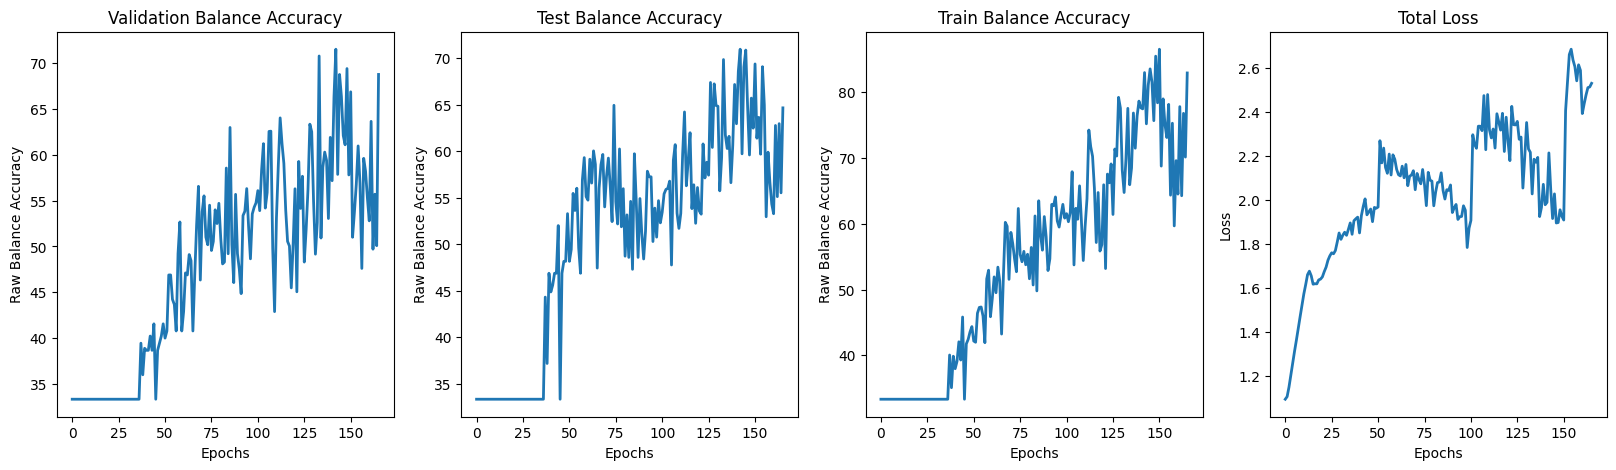

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 71.0
Min Total Loss - 1.1
Epoch:  166
Learning Rate:  0.0004524135262330098


100%|██████████| 119/119 [00:05<00:00, 23.21it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.5294117647058824
class2 recall: 0.75
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.5
class2 recall: 0.75



100%|██████████| 120/120 [00:04<00:00, 29.22it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8846153846153846
class1 recall: 0.47058823529411764
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.4411764705882353
class2 recall: 0.8



100%|██████████| 360/360 [00:12<00:00, 28.55it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.6213592233009708
class2 recall: 0.8839779005524862
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.5922330097087378
class2 recall: 0.9281767955801105
Epoch:  167
Learning Rate:  0.0004463912329591104



100%|██████████| 119/119 [00:04<00:00, 29.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.5588235294117647
class2 recall: 0.65
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.5
class2 recall: 0.75



100%|██████████| 120/120 [00:04<00:00, 29.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.47058823529411764
class2 recall: 0.6333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4411764705882353
class2 recall: 0.7666666666666667



100%|██████████| 360/360 [00:12<00:00, 28.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9868421052631579
class1 recall: 0.7572815533980582
class2 recall: 0.8066298342541437
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.6504854368932039
class2 recall: 0.9171270718232044
Epoch:  168
Learning Rate:  0.000440031649145566



100%|██████████| 119/119 [00:03<00:00, 30.11it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.11764705882352941
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.5
class2 recall: 0.7333333333333333



100%|██████████| 120/120 [00:04<00:00, 26.51it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.20588235294117646
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.4117647058823529
class2 recall: 0.7833333333333333



100%|██████████| 360/360 [00:12<00:00, 29.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.46601941747572817
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.6310679611650486
class2 recall: 0.9116022099447514
Epoch:  169
Learning Rate:  0.00043333958005578203



100%|██████████| 119/119 [00:04<00:00, 27.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.7647058823529411
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4411764705882353
class2 recall: 0.75



100%|██████████| 120/120 [00:05<00:00, 22.27it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5384615384615384
class1 recall: 0.7058823529411765
class2 recall: 0.6333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.35294117647058826
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 31.11it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6842105263157895
class1 recall: 0.8252427184466019
class2 recall: 0.8176795580110497
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.6407766990291263
class2 recall: 0.9281767955801105
Epoch:  170
Learning Rate:  0.0004263200821770461



100%|██████████| 119/119 [00:05<00:00, 21.83it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4411764705882353
class2 recall: 0.7333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.38235294117647056
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:04<00:00, 28.90it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.5294117647058824
class2 recall: 0.75
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.38235294117647056
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 28.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.7281553398058253
class2 recall: 0.861878453038674
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.6213592233009708
class2 recall: 0.9281767955801105


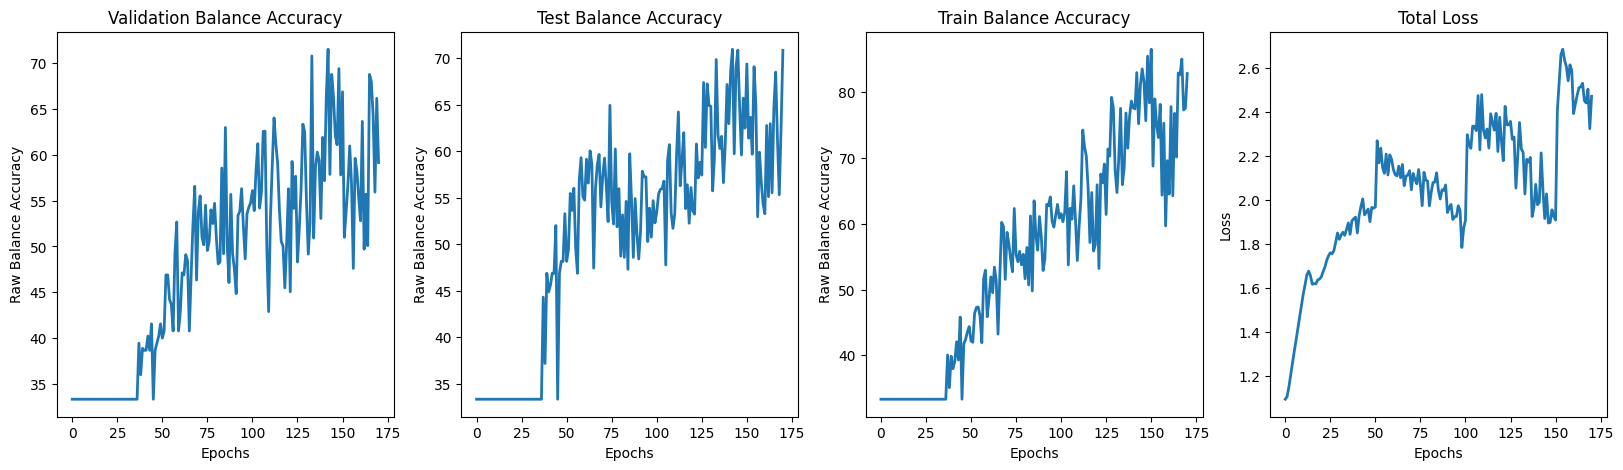

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 71.0
Min Total Loss - 1.1
Epoch:  171
Learning Rate:  0.00041897845939987553


100%|██████████| 119/119 [00:04<00:00, 28.92it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.7941176470588235
class2 recall: 0.5833333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 29.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.7941176470588235
class2 recall: 0.6333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.4117647058823529
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 28.59it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.8737864077669902
class2 recall: 0.8066298342541437
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.5825242718446602
class2 recall: 0.9337016574585635
Epoch:  172
Learning Rate:  0.0004113202590104299



100%|██████████| 119/119 [00:04<00:00, 29.43it/s]


Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.29411764705882354
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4117647058823529
class2 recall: 0.7666666666666667


100%|██████████| 120/120 [00:04<00:00, 26.76it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8846153846153846
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.4411764705882353
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 29.62it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.5533980582524272
class2 recall: 0.9337016574585635
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.6019417475728155
class2 recall: 0.9337016574585635
Epoch:  173
Learning Rate:  0.000403351267499015



100%|██████████| 119/119 [00:04<00:00, 29.65it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.20588235294117646
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:05<00:00, 22.42it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.20588235294117646
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.3235294117647059
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 31.00it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.3786407766990291
class2 recall: 0.9613259668508287
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.5631067961165048
class2 recall: 0.9502762430939227
Epoch:  174
Learning Rate:  0.0003950775061878452



100%|██████████| 119/119 [00:04<00:00, 24.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.47058823529411764
class2 recall: 0.75
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.3235294117647059
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:05<00:00, 23.76it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8846153846153846
class1 recall: 0.5588235294117647
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.2647058823529412
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 29.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.6893203883495146
class2 recall: 0.8950276243093923
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.5242718446601942
class2 recall: 0.9613259668508287
Epoch:  175
Learning Rate:  0.0003865052266813685



100%|██████████| 119/119 [00:05<00:00, 22.87it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.5
class2 recall: 0.7166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 28.92it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9230769230769231
class1 recall: 0.4411764705882353
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.20588235294117646
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 28.33it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.6893203883495146
class2 recall: 0.861878453038674
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.5242718446601942
class2 recall: 0.9558011049723757


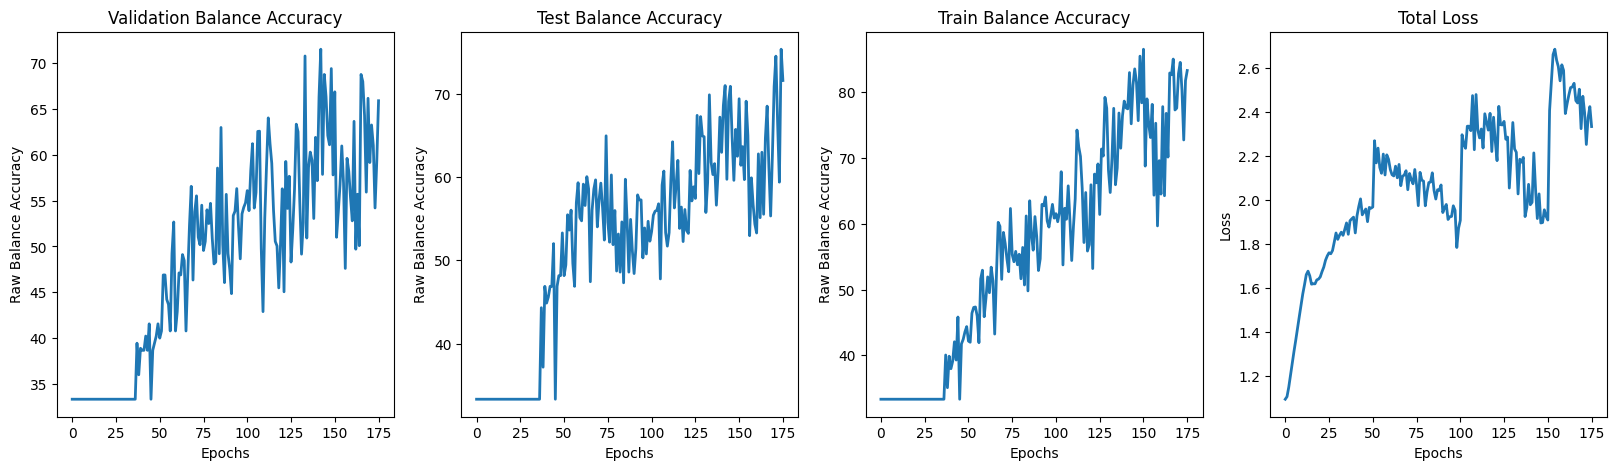

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  176
Learning Rate:  0.0003776409061425918


100%|██████████| 119/119 [00:04<00:00, 28.58it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.4411764705882353
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.3235294117647059
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 28.36it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.4411764705882353
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.20588235294117646
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 28.27it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7236842105263158
class1 recall: 0.6893203883495146
class2 recall: 0.9060773480662984
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.5048543689320388
class2 recall: 0.9558011049723757
Epoch:  177
Learning Rate:  0.0003684912423989754



100%|██████████| 119/119 [00:04<00:00, 29.69it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.35294117647058826
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.29411764705882354
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 25.95it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.35294117647058826
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.23529411764705882
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 29.31it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8289473684210527
class1 recall: 0.5728155339805825
class2 recall: 0.9392265193370166
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.4854368932038835
class2 recall: 0.9558011049723757
Epoch:  178
Learning Rate:  0.0003590631488815944



100%|██████████| 119/119 [00:04<00:00, 28.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.5294117647058824
class2 recall: 0.6833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.29411764705882354
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:05<00:00, 22.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.47058823529411764
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.23529411764705882
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:11<00:00, 30.25it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.8737864077669902
class2 recall: 0.8729281767955801
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.5048543689320388
class2 recall: 0.9502762430939227
Epoch:  179
Learning Rate:  0.00034936374940139223



100%|██████████| 119/119 [00:05<00:00, 23.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.35294117647058826
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.38235294117647056
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:04<00:00, 25.83it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.23529411764705882
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.23529411764705882
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 28.44it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.5825242718446602
class2 recall: 0.9281767955801105
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.5242718446601942
class2 recall: 0.9502762430939227
Epoch:  180
Learning Rate:  0.0003394003727664709



100%|██████████| 119/119 [00:04<00:00, 25.82it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.20588235294117646
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.38235294117647056
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 28.97it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.11764705882352941
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.23529411764705882
class2 recall: 0.8



100%|██████████| 360/360 [00:12<00:00, 28.13it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.4854368932038835
class2 recall: 0.9834254143646409
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.5631067961165048
class2 recall: 0.9502762430939227


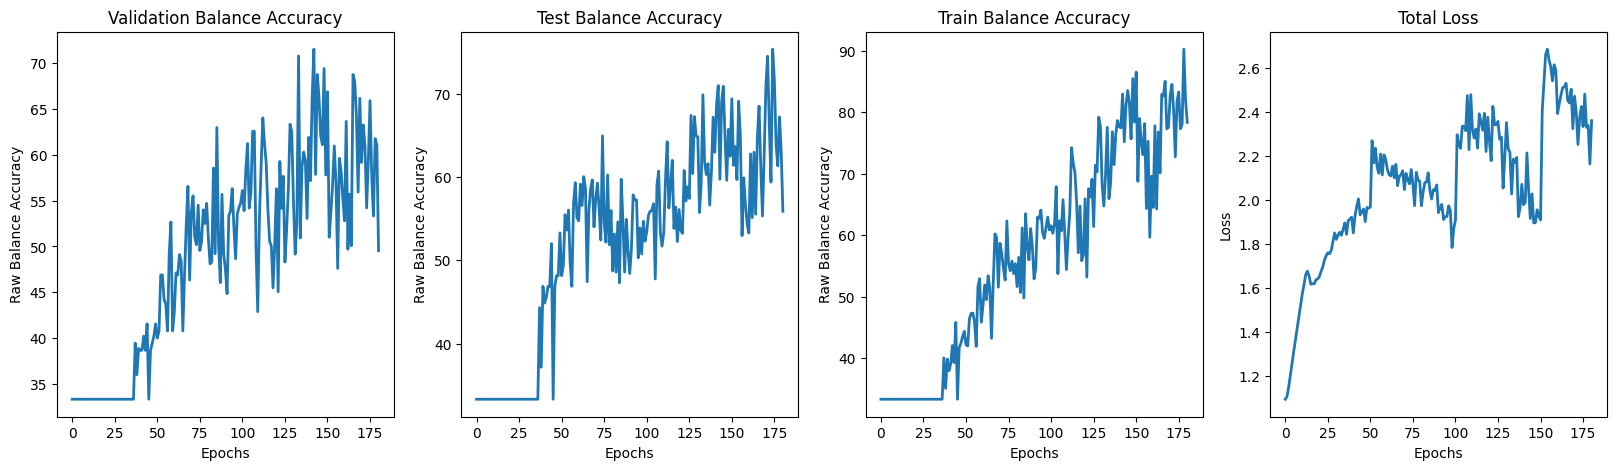

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  181
Learning Rate:  0.0003291805472444886


100%|██████████| 119/119 [00:04<00:00, 29.36it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.5294117647058824
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.35294117647058826
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 27.09it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.4411764705882353
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.23529411764705882
class2 recall: 0.8



100%|██████████| 360/360 [00:12<00:00, 28.61it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.7184466019417476
class2 recall: 0.8839779005524862
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.5922330097087378
class2 recall: 0.9447513812154696
Epoch:  182
Learning Rate:  0.00031871199487434486



100%|██████████| 119/119 [00:04<00:00, 29.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.88
class1 recall: 0.08823529411764706
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.3235294117647059
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 21.98it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9230769230769231
class1 recall: 0.11764705882352941
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.23529411764705882
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:11<00:00, 30.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.33980582524271846
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.5922330097087378
class2 recall: 0.9392265193370166
Epoch:  183
Learning Rate:  0.00030800262563145494



100%|██████████| 119/119 [00:05<00:00, 23.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.23529411764705882
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.35294117647058826
class2 recall: 0.8



100%|██████████| 120/120 [00:04<00:00, 24.69it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.14705882352941177
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.20588235294117646
class2 recall: 0.8



100%|██████████| 360/360 [00:12<00:00, 28.89it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.75
class1 recall: 0.5048543689320388
class2 recall: 0.9723756906077348
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.5922330097087378
class2 recall: 0.9502762430939227
Epoch:  184
Learning Rate:  0.00029706053145101924



100%|██████████| 119/119 [00:05<00:00, 23.08it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4411764705882353
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.3235294117647059
class2 recall: 0.8166666666666667



100%|██████████| 120/120 [00:04<00:00, 26.82it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4411764705882353
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.17647058823529413
class2 recall: 0.8



100%|██████████| 360/360 [00:13<00:00, 27.51it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.7184466019417476
class2 recall: 0.9116022099447514
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.5728155339805825
class2 recall: 0.9558011049723757
Epoch:  185
Learning Rate:  0.0002858939801138062



100%|██████████| 119/119 [00:04<00:00, 28.57it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.14705882352941177
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 28.11it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.11764705882352941
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.23529411764705882
class2 recall: 0.8



100%|██████████| 360/360 [00:12<00:00, 28.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.42718446601941745
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.6116504854368932
class2 recall: 0.9502762430939227


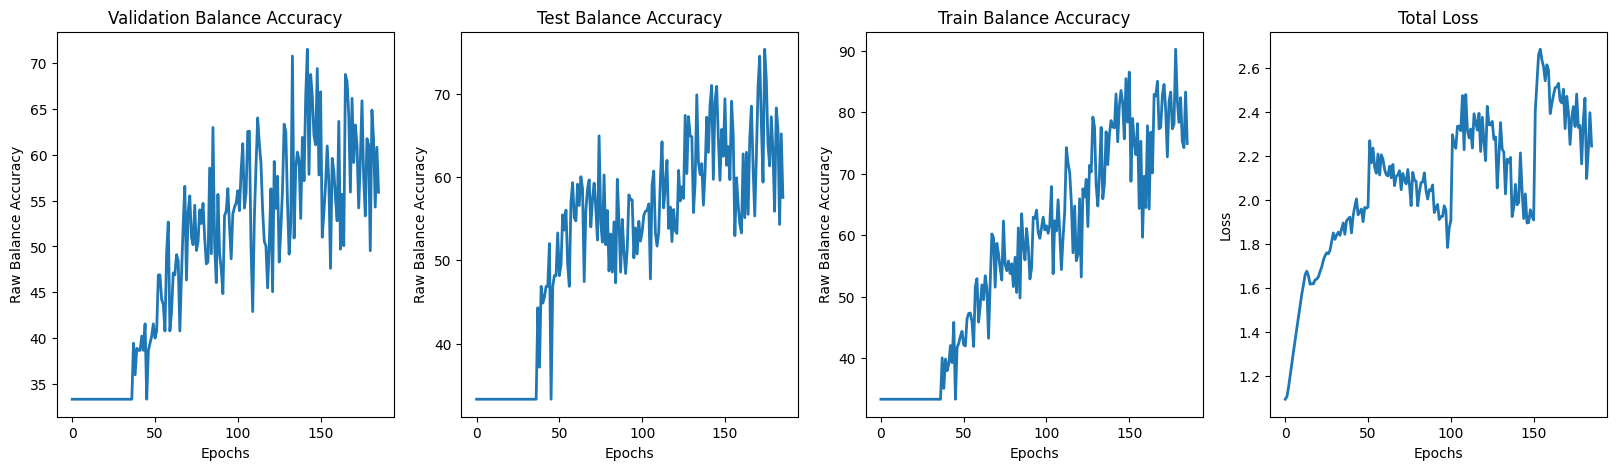

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  186
Learning Rate:  0.0002745114089990659


100%|██████████| 119/119 [00:04<00:00, 28.35it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.2647058823529412
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.29411764705882354
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:05<00:00, 22.68it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.23529411764705882
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.23529411764705882
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 29.70it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7894736842105263
class1 recall: 0.5339805825242718
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.5631067961165048
class2 recall: 0.9613259668508287
Epoch:  187
Learning Rate:  0.00026292141870929776



100%|██████████| 119/119 [00:04<00:00, 24.29it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.7058823529411765
class2 recall: 0.65
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.29411764705882354
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 23.05it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.7647058823529411
class2 recall: 0.6666666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.20588235294117646
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 28.16it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.912621359223301
class2 recall: 0.7900552486187845
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.5631067961165048
class2 recall: 0.9668508287292817
Epoch:  188
Learning Rate:  0.0002511327665716863



100%|██████████| 119/119 [00:05<00:00, 21.52it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.6764705882352942
class2 recall: 0.6833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.3235294117647059
class2 recall: 0.8



100%|██████████| 120/120 [00:04<00:00, 27.71it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.6764705882352942
class2 recall: 0.6666666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.20588235294117646
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:13<00:00, 27.45it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.9029126213592233
class2 recall: 0.8176795580110497
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8947368421052632
class1 recall: 0.5922330097087378
class2 recall: 0.9723756906077348
Epoch:  189
Learning Rate:  0.0002391543600211173



100%|██████████| 119/119 [00:04<00:00, 28.54it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.5882352941176471
class2 recall: 0.7166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 27.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.5882352941176471
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.29411764705882354
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 27.80it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.8155339805825242
class2 recall: 0.8839779005524862
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9078947368421053
class1 recall: 0.6019417475728155
class2 recall: 0.9613259668508287
Epoch:  190
Learning Rate:  0.0002269952498697734



100%|██████████| 119/119 [00:04<00:00, 29.16it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.029411764705882353
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:05<00:00, 23.10it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.029411764705882353
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.3235294117647059
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 29.35it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.1553398058252427
class2 recall: 0.988950276243094
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.6407766990291263
class2 recall: 0.9613259668508287


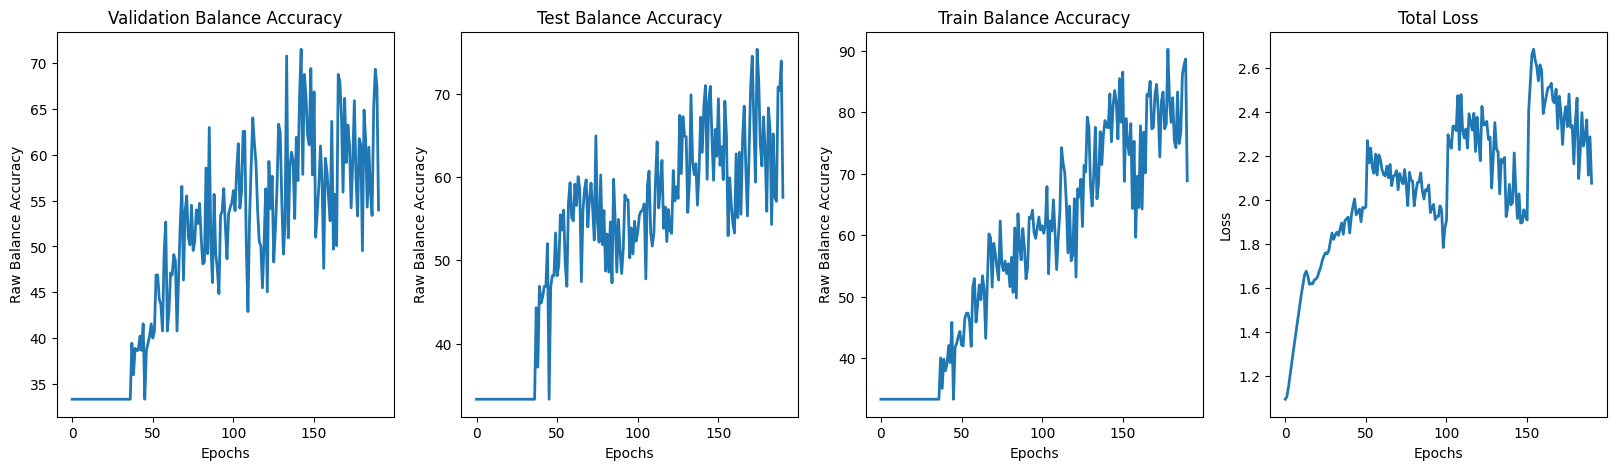

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  191
Learning Rate:  0.00021466462346839507


100%|██████████| 119/119 [00:04<00:00, 23.96it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.4117647058823529
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.35294117647058826
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:05<00:00, 22.90it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.5294117647058824
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.3235294117647059
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:13<00:00, 27.68it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.7572815533980582
class2 recall: 0.9171270718232044
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.6893203883495146
class2 recall: 0.9558011049723757
Epoch:  192
Learning Rate:  0.00020217179776437256



100%|██████████| 119/119 [00:05<00:00, 23.18it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.17647058823529413
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.38235294117647056
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 27.55it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.11764705882352941
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.4117647058823529
class2 recall: 0.8



100%|██████████| 360/360 [00:13<00:00, 27.12it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.631578947368421
class1 recall: 0.34951456310679613
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.7087378640776699
class2 recall: 0.9447513812154696
Epoch:  193
Learning Rate:  0.00018952621226191733



100%|██████████| 119/119 [00:04<00:00, 28.14it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.29411764705882354
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.38235294117647056
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 26.03it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.20588235294117646
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.4411764705882353
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 27.79it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8421052631578947
class1 recall: 0.5728155339805825
class2 recall: 0.9834254143646409
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.7087378640776699
class2 recall: 0.9502762430939227
Epoch:  194
Learning Rate:  0.00017673742188962856



100%|██████████| 119/119 [00:04<00:00, 28.13it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.88
class1 recall: 0.38235294117647056
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:05<00:00, 21.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.4117647058823529
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.4117647058823529
class2 recall: 0.8333333333333334



100%|██████████| 360/360 [00:12<00:00, 28.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.7475728155339806
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.6796116504854369
class2 recall: 0.9668508287292817
Epoch:  195
Learning Rate:  0.00016381508978084673



100%|██████████| 119/119 [00:05<00:00, 21.87it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.3235294117647059
class2 recall: 0.75
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.35294117647058826
class2 recall: 0.8



100%|██████████| 120/120 [00:04<00:00, 25.63it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.4411764705882353
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.4411764705882353
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:13<00:00, 27.22it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.6990291262135923
class2 recall: 0.9392265193370166
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.6990291262135923
class2 recall: 0.9668508287292817


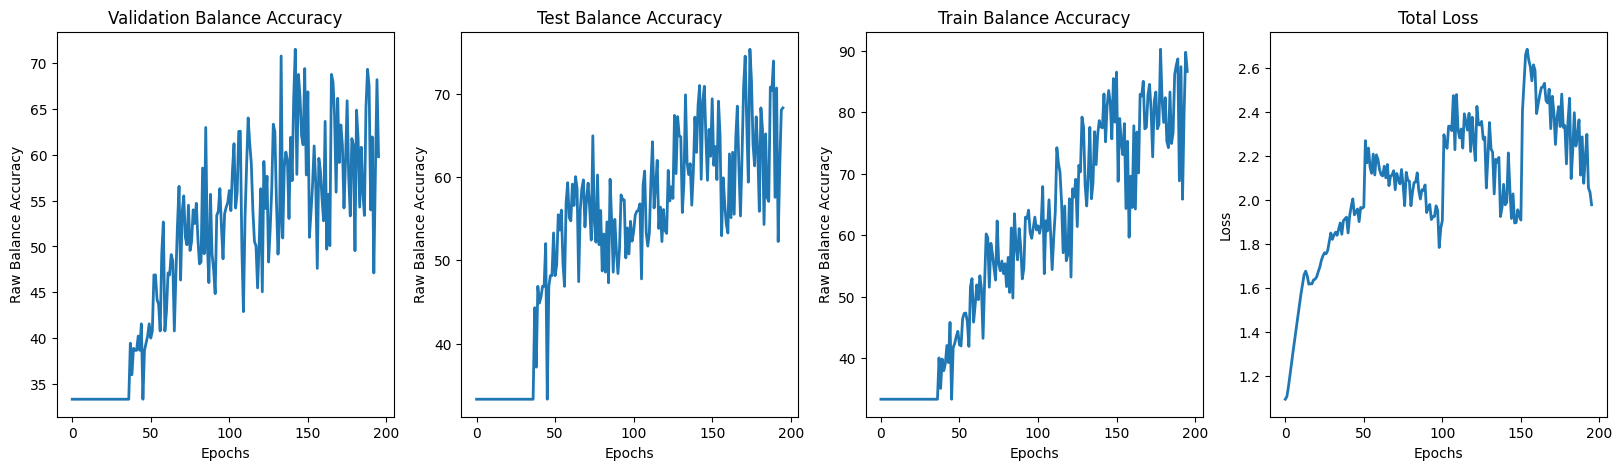

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  196
Learning Rate:  0.0001507689799722479


100%|██████████| 119/119 [00:04<00:00, 26.37it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.4117647058823529
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.38235294117647056
class2 recall: 0.8



100%|██████████| 120/120 [00:04<00:00, 27.78it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.4411764705882353
class2 recall: 0.7666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.4117647058823529
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:13<00:00, 27.29it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.7475728155339806
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.6990291262135923
class2 recall: 0.9613259668508287
Epoch:  197
Learning Rate:  0.0001376089500261958



100%|██████████| 119/119 [00:04<00:00, 28.52it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.6176470588235294
class2 recall: 0.6333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.35294117647058826
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 22.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.6176470588235294
class2 recall: 0.6166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.4117647058823529
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:12<00:00, 27.85it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9868421052631579
class1 recall: 0.9514563106796117
class2 recall: 0.856353591160221
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.7087378640776699
class2 recall: 0.9613259668508287
Epoch:  198
Learning Rate:  0.00012434494358242747



100%|██████████| 119/119 [00:04<00:00, 24.65it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.23529411764705882
class2 recall: 0.8
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.35294117647058826
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 23.03it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8846153846153846
class1 recall: 0.23529411764705882
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.4411764705882353
class2 recall: 0.8



100%|██████████| 360/360 [00:13<00:00, 27.49it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.5825242718446602
class2 recall: 0.9668508287292817
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.7378640776699029
class2 recall: 0.9613259668508287
Epoch:  199
Learning Rate:  0.00011098698284469807



100%|██████████| 119/119 [00:05<00:00, 22.79it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.6470588235294118
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.38235294117647056
class2 recall: 0.8



100%|██████████| 120/120 [00:04<00:00, 27.19it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.7058823529411765
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.5
class2 recall: 0.7833333333333333



100%|██████████| 360/360 [00:13<00:00, 26.67it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.9029126213592233
class2 recall: 0.8839779005524862
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9868421052631579
class1 recall: 0.7572815533980582
class2 recall: 0.9558011049723757
Epoch:  200
Learning Rate:  9.754516100806417e-05



100%|██████████| 119/119 [00:04<00:00, 28.34it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.3235294117647059
class2 recall: 0.7833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.38235294117647056
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:04<00:00, 25.83it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.5
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.5
class2 recall: 0.7666666666666667



100%|██████████| 360/360 [00:13<00:00, 27.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.7475728155339806
class2 recall: 0.9613259668508287
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9868421052631579
class1 recall: 0.7766990291262136
class2 recall: 0.9447513812154696


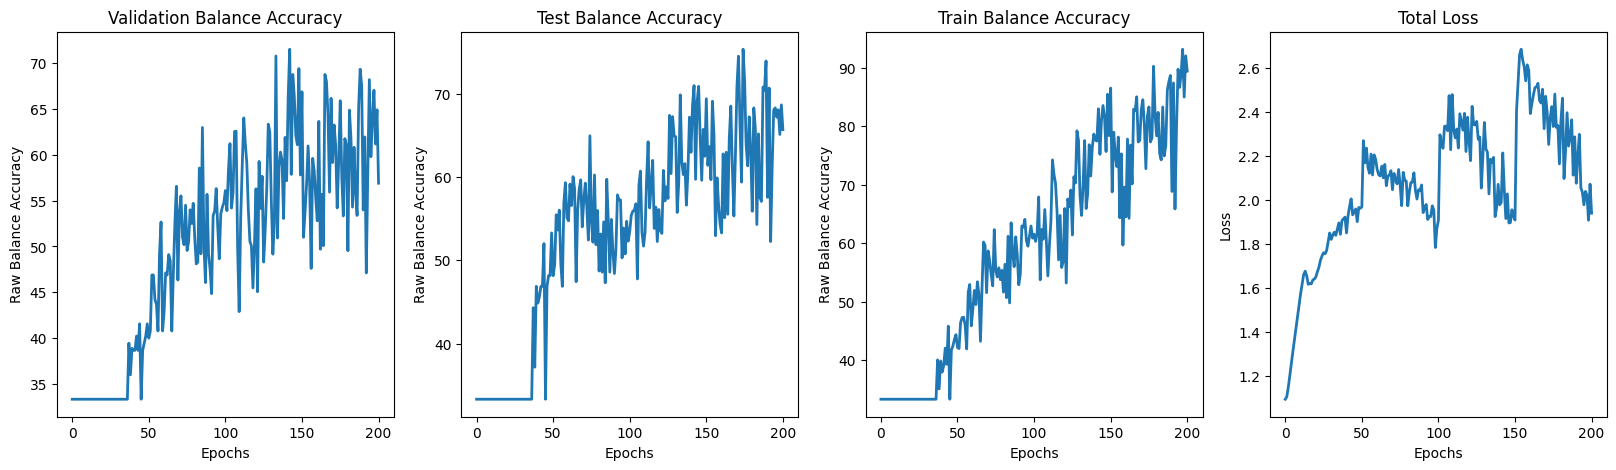

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  201
Learning Rate:  0.0004998111014986735


100%|██████████| 119/119 [00:04<00:00, 25.87it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.28
class1 recall: 0.17647058823529413
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.38235294117647056
class2 recall: 0.7333333333333333



100%|██████████| 120/120 [00:05<00:00, 22.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4230769230769231
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.5
class2 recall: 0.7666666666666667



100%|██████████| 360/360 [00:13<00:00, 27.24it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6052631578947368
class1 recall: 0.4563106796116505
class2 recall: 0.9834254143646409
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9868421052631579
class1 recall: 0.7864077669902912
class2 recall: 0.9558011049723757
Epoch:  202
Learning Rate:  0.0004992445487252689



100%|██████████| 119/119 [00:05<00:00, 22.55it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.7941176470588235
class2 recall: 0.45
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.4117647058823529
class2 recall: 0.75



100%|██████████| 120/120 [00:04<00:00, 27.47it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.8529411764705882
class2 recall: 0.5
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.4411764705882353
class2 recall: 0.8



100%|██████████| 360/360 [00:13<00:00, 26.83it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.941747572815534
class2 recall: 0.6464088397790055
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.7766990291262136
class2 recall: 0.9502762430939227
Epoch:  203
Learning Rate:  0.0004983007697636659



100%|██████████| 119/119 [00:04<00:00, 27.86it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.3235294117647059
class2 recall: 0.75
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.47058823529411764
class2 recall: 0.75



100%|██████████| 120/120 [00:04<00:00, 27.36it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4411764705882353
class2 recall: 0.8666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.5
class2 recall: 0.7833333333333333



100%|██████████| 360/360 [00:13<00:00, 26.96it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.881578947368421
class1 recall: 0.6407766990291263
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.8252427184466019
class2 recall: 0.9392265193370166
Epoch:  204
Learning Rate:  0.0004969804777275899



100%|██████████| 119/119 [00:04<00:00, 28.16it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.14705882352941177
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.47058823529411764
class2 recall: 0.7333333333333333



100%|██████████| 120/120 [00:05<00:00, 21.96it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6153846153846154
class1 recall: 0.11764705882352941
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.5294117647058824
class2 recall: 0.7833333333333333



100%|██████████| 360/360 [00:12<00:00, 28.91it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.2524271844660194
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9868421052631579
class1 recall: 0.8058252427184466
class2 recall: 0.9337016574585635
Epoch:  205
Learning Rate:  0.0004952846702217887



100%|██████████| 119/119 [00:05<00:00, 23.35it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.08823529411764706
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.47058823529411764
class2 recall: 0.7333333333333333



100%|██████████| 120/120 [00:05<00:00, 23.36it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.14705882352941177
class2 recall: 0.9666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.5294117647058824
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:13<00:00, 27.00it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5921052631578947
class1 recall: 0.2815533980582524
class2 recall: 1.0
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.7669902912621359
class2 recall: 0.9558011049723757


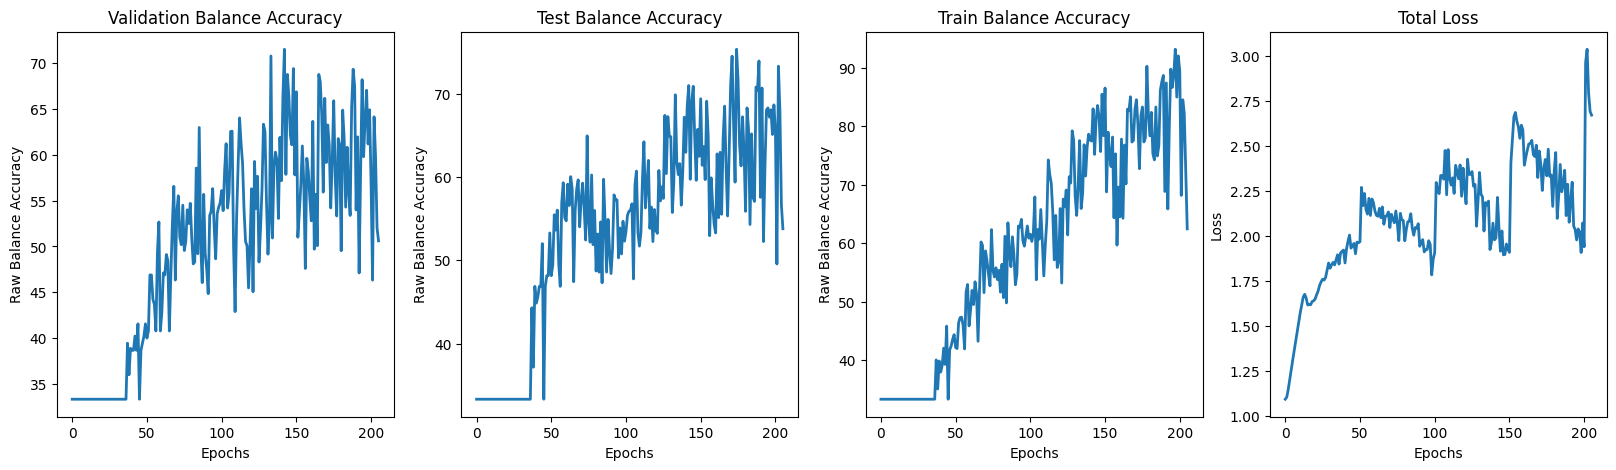

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  206
Learning Rate:  0.0004932146285882477


100%|██████████| 119/119 [00:04<00:00, 25.52it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.72
class1 recall: 0.5294117647058824
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.47058823529411764
class2 recall: 0.7333333333333333



100%|██████████| 120/120 [00:04<00:00, 27.23it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.5
class2 recall: 0.75
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.5294117647058824
class2 recall: 0.8



100%|██████████| 360/360 [00:13<00:00, 26.52it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.7378640776699029
class2 recall: 0.8950276243093923
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.7766990291262136
class2 recall: 0.9281767955801105
Epoch:  207
Learning Rate:  0.0004907719169380163



100%|██████████| 119/119 [00:04<00:00, 27.75it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.38235294117647056
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4411764705882353
class2 recall: 0.75



100%|██████████| 120/120 [00:05<00:00, 23.35it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.11764705882352941
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.5294117647058824
class2 recall: 0.8



100%|██████████| 360/360 [00:12<00:00, 28.22it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7631578947368421
class1 recall: 0.34951456310679613
class2 recall: 0.9834254143646409
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.7669902912621359
class2 recall: 0.9392265193370166
Epoch:  208
Learning Rate:  0.0004879583809693737



100%|██████████| 119/119 [00:05<00:00, 23.23it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.7058823529411765
class2 recall: 0.6833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.47058823529411764
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 22.72it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7307692307692307
class1 recall: 0.4411764705882353
class2 recall: 0.6166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.47058823529411764
class2 recall: 0.7833333333333333



100%|██████████| 360/360 [00:13<00:00, 26.50it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.868421052631579
class1 recall: 0.8252427184466019
class2 recall: 0.8232044198895028
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.8058252427184466
class2 recall: 0.9392265193370166
Epoch:  209
Learning Rate:  0.00048477614657323176



100%|██████████| 119/119 [00:04<00:00, 27.45it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.29411764705882354
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.5
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:04<00:00, 26.91it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.4117647058823529
class2 recall: 0.6833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.6470588235294118
class2 recall: 0.7333333333333333



100%|██████████| 360/360 [00:13<00:00, 26.50it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9736842105263158
class1 recall: 0.5631067961165048
class2 recall: 0.861878453038674
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.8155339805825242
class2 recall: 0.9392265193370166
Epoch:  210
Learning Rate:  0.00048122761822682366



100%|██████████| 119/119 [00:04<00:00, 28.24it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8
class1 recall: 0.38235294117647056
class2 recall: 0.6833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.4411764705882353
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 23.04it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.5
class2 recall: 0.6333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.6176470588235294
class2 recall: 0.75



100%|██████████| 360/360 [00:12<00:00, 28.83it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9868421052631579
class1 recall: 0.7475728155339806
class2 recall: 0.8176795580110497
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.7378640776699029
class2 recall: 0.9392265193370166


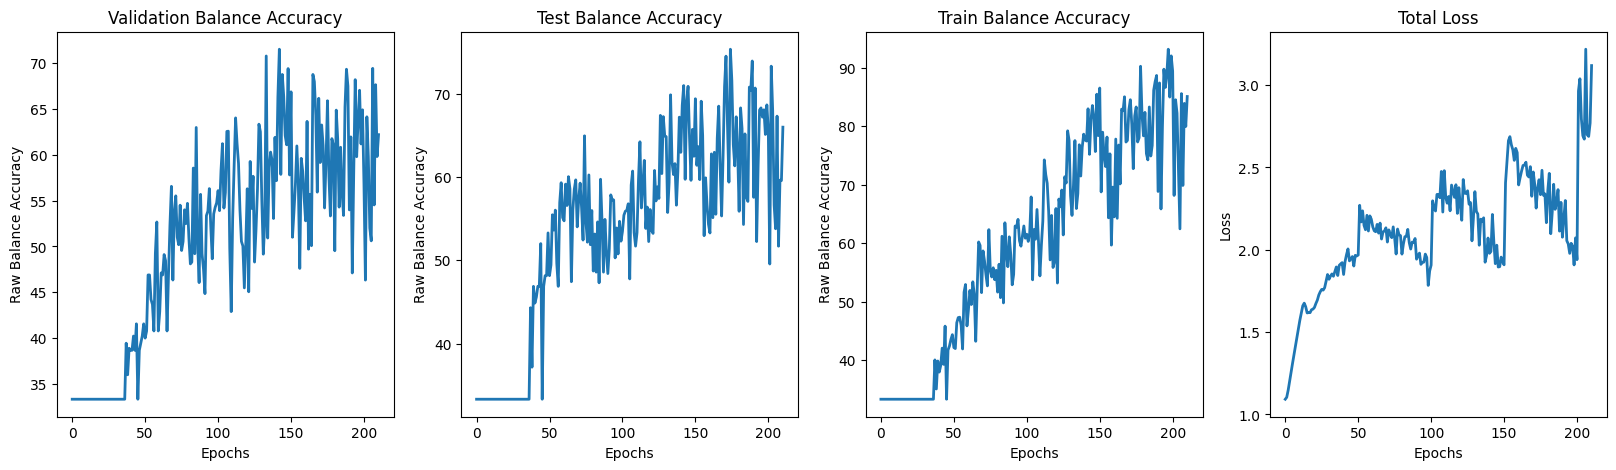

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  211
Learning Rate:  0.00047731547717689556


100%|██████████| 119/119 [00:05<00:00, 22.16it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.88
class1 recall: 0.29411764705882354
class2 recall: 0.6666666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.4411764705882353
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:05<00:00, 23.75it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.47058823529411764
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.5294117647058824
class2 recall: 0.75



100%|██████████| 360/360 [00:13<00:00, 26.31it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.6990291262135923
class2 recall: 0.861878453038674
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.7572815533980582
class2 recall: 0.9447513812154696
Epoch:  212
Learning Rate:  0.00047304267941377265



100%|██████████| 119/119 [00:04<00:00, 26.11it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.48
class1 recall: 0.4117647058823529
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.4411764705882353
class2 recall: 0.75



100%|██████████| 120/120 [00:04<00:00, 26.91it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5769230769230769
class1 recall: 0.2647058823529412
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.5
class2 recall: 0.7333333333333333



100%|██████████| 360/360 [00:13<00:00, 26.70it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7763157894736842
class1 recall: 0.7184466019417476
class2 recall: 0.9447513812154696
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.7864077669902912
class2 recall: 0.9392265193370166
Epoch:  213
Learning Rate:  0.0004684124534378307



100%|██████████| 119/119 [00:04<00:00, 27.73it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.35294117647058826
class2 recall: 0.8333333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.4117647058823529
class2 recall: 0.7833333333333333



100%|██████████| 120/120 [00:05<00:00, 23.91it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.35294117647058826
class2 recall: 0.9
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.4117647058823529
class2 recall: 0.7666666666666667



100%|██████████| 360/360 [00:12<00:00, 27.93it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.5242718446601942
class2 recall: 0.9502762430939227
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.7669902912621359
class2 recall: 0.9558011049723757
Epoch:  214
Learning Rate:  0.0004634282978200604



100%|██████████| 119/119 [00:05<00:00, 23.02it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.76
class1 recall: 0.6764705882352942
class2 recall: 0.25
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.4117647058823529
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 23.16it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.7941176470588235
class2 recall: 0.2833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.4411764705882353
class2 recall: 0.8



100%|██████████| 360/360 [00:13<00:00, 26.84it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.941747572815534
class2 recall: 0.4198895027624309
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.7184466019417476
class2 recall: 0.9558011049723757
Epoch:  215
Learning Rate:  0.000458093978558568



100%|██████████| 119/119 [00:04<00:00, 23.90it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.84
class1 recall: 0.5588235294117647
class2 recall: 0.5166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.4411764705882353
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:04<00:00, 26.53it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.6764705882352942
class2 recall: 0.5
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.5294117647058824
class2 recall: 0.7833333333333333



100%|██████████| 360/360 [00:13<00:00, 25.99it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.7864077669902912
class2 recall: 0.6795580110497238
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.7087378640776699
class2 recall: 0.9392265193370166


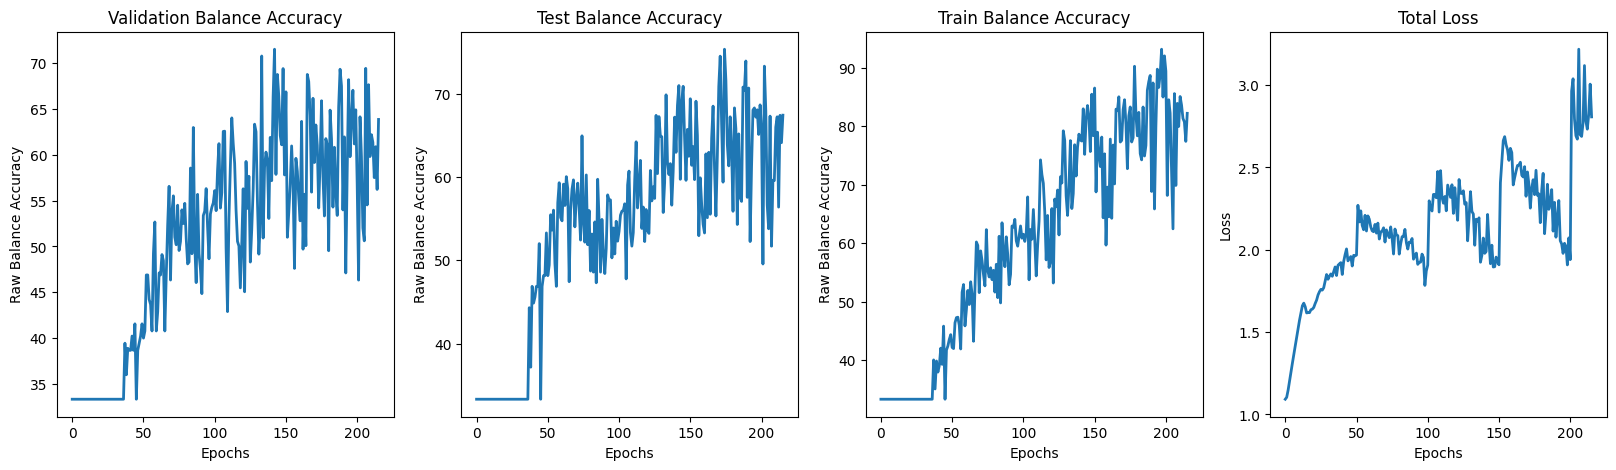

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  216
Learning Rate:  0.0004524135262330098


100%|██████████| 119/119 [00:04<00:00, 27.78it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.6176470588235294
class2 recall: 0.7166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.4117647058823529
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 22.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.5294117647058824
class2 recall: 0.6666666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.5
class2 recall: 0.8



100%|██████████| 360/360 [00:12<00:00, 28.21it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.7864077669902912
class2 recall: 0.8950276243093923
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.6796116504854369
class2 recall: 0.9337016574585635
Epoch:  217
Learning Rate:  0.0004463912329591104



100%|██████████| 119/119 [00:05<00:00, 22.99it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.14705882352941177
class2 recall: 0.9166666666666666
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.38235294117647056
class2 recall: 0.8



100%|██████████| 120/120 [00:05<00:00, 23.55it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.029411764705882353
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.4117647058823529
class2 recall: 0.8166666666666667



100%|██████████| 360/360 [00:13<00:00, 25.93it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9342105263157895
class1 recall: 0.3592233009708738
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.6601941747572816
class2 recall: 0.9392265193370166
Epoch:  218
Learning Rate:  0.000440031649145566



100%|██████████| 119/119 [00:04<00:00, 26.33it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.32
class1 recall: 0.7647058823529411
class2 recall: 0.5833333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.3235294117647059
class2 recall: 0.7666666666666667



100%|██████████| 120/120 [00:04<00:00, 26.67it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.5
class1 recall: 0.8529411764705882
class2 recall: 0.6333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.5
class2 recall: 0.8



100%|██████████| 360/360 [00:13<00:00, 26.13it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.75
class1 recall: 0.9320388349514563
class2 recall: 0.7900552486187845
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.6893203883495146
class2 recall: 0.9392265193370166
Epoch:  219
Learning Rate:  0.00043333958005578203



100%|██████████| 119/119 [00:04<00:00, 27.39it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.68
class1 recall: 0.5294117647058824
class2 recall: 0.7166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.4117647058823529
class2 recall: 0.7333333333333333



100%|██████████| 120/120 [00:05<00:00, 21.81it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8846153846153846
class1 recall: 0.47058823529411764
class2 recall: 0.7
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7692307692307693
class1 recall: 0.5
class2 recall: 0.8



100%|██████████| 360/360 [00:13<00:00, 27.09it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9868421052631579
class1 recall: 0.6990291262135923
class2 recall: 0.9060773480662984
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.7087378640776699
class2 recall: 0.9392265193370166
Epoch:  220
Learning Rate:  0.0004263200821770461



100%|██████████| 119/119 [00:05<00:00, 21.83it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.4
class1 recall: 0.29411764705882354
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.4117647058823529
class2 recall: 0.7333333333333333



100%|██████████| 120/120 [00:05<00:00, 23.35it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6923076923076923
class1 recall: 0.35294117647058826
class2 recall: 0.8833333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.5
class2 recall: 0.7833333333333333



100%|██████████| 360/360 [00:13<00:00, 26.10it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.7368421052631579
class1 recall: 0.47572815533980584
class2 recall: 0.9779005524861878
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.6893203883495146
class2 recall: 0.9502762430939227


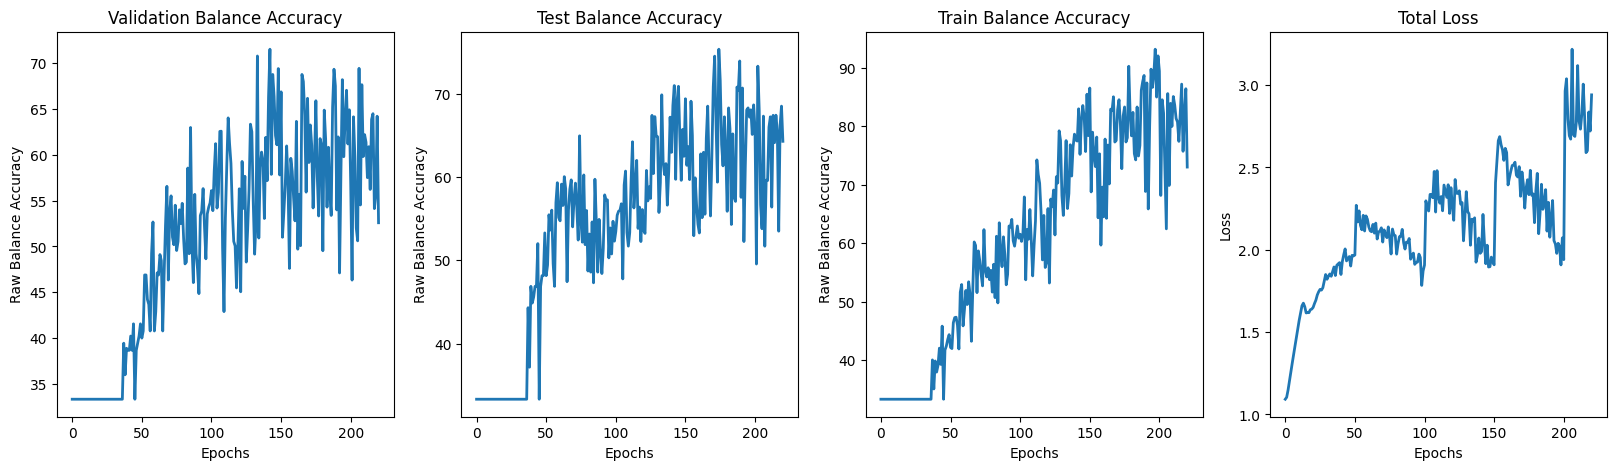

Max Validation Balance Accuracy - 71.5
Max Test Balance Accuracy - 75.3
Min Total Loss - 1.1
Epoch:  221
Learning Rate:  0.00041897845939987553


100%|██████████| 119/119 [00:04<00:00, 27.44it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.44
class1 recall: 0.11764705882352941
class2 recall: 0.95
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.5588235294117647
class2 recall: 0.7333333333333333



100%|██████████| 120/120 [00:04<00:00, 25.78it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6538461538461539
class1 recall: 0.029411764705882353
class2 recall: 0.9333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.5588235294117647
class2 recall: 0.7666666666666667



100%|██████████| 360/360 [00:13<00:00, 26.41it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8552631578947368
class1 recall: 0.24271844660194175
class2 recall: 0.994475138121547
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.7669902912621359
class2 recall: 0.9447513812154696
Epoch:  222
Learning Rate:  0.0004113202590104299



100%|██████████| 119/119 [00:04<00:00, 25.57it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.88
class1 recall: 0.08823529411764706
class2 recall: 0.85
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.5294117647058824
class2 recall: 0.75



100%|██████████| 120/120 [00:05<00:00, 20.74it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9230769230769231
class1 recall: 0.08823529411764706
class2 recall: 0.8166666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.5
class2 recall: 0.7666666666666667



100%|██████████| 360/360 [00:13<00:00, 26.64it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 1.0
class1 recall: 0.3300970873786408
class2 recall: 0.9116022099447514
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9210526315789473
class1 recall: 0.7475728155339806
class2 recall: 0.9613259668508287
Epoch:  223
Learning Rate:  0.000403351267499015



100%|██████████| 119/119 [00:05<00:00, 21.20it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.7058823529411765
class2 recall: 0.5666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.52
class1 recall: 0.5
class2 recall: 0.75



100%|██████████| 120/120 [00:04<00:00, 25.15it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8076923076923077
class1 recall: 0.6764705882352942
class2 recall: 0.6333333333333333
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.5
class2 recall: 0.7666666666666667



100%|██████████| 360/360 [00:13<00:00, 26.06it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.9611650485436893
class2 recall: 0.8011049723756906
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.7572815533980582
class2 recall: 0.9668508287292817
Epoch:  224
Learning Rate:  0.0003950775061878452



100%|██████████| 119/119 [00:04<00:00, 27.46it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.64
class1 recall: 0.7647058823529411
class2 recall: 0.11666666666666667
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.5294117647058824
class2 recall: 0.7333333333333333



100%|██████████| 120/120 [00:04<00:00, 24.72it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.9117647058823529
class2 recall: 0.2
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.8461538461538461
class1 recall: 0.4117647058823529
class2 recall: 0.7333333333333333



100%|██████████| 360/360 [00:13<00:00, 26.38it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9605263157894737
class1 recall: 0.9902912621359223
class2 recall: 0.292817679558011
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.9473684210526315
class1 recall: 0.8058252427184466
class2 recall: 0.9558011049723757
Epoch:  225
Learning Rate:  0.0003865052266813685



100%|██████████| 119/119 [00:05<00:00, 23.44it/s]

Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.6
class1 recall: 0.6176470588235294
class2 recall: 0.5833333333333334
Inside calculate_balanced_accuracy, 3 classes passed in
class0 recall: 0.56
class1 recall: 0.6176470588235294
class2 recall: 0.6833333333333333



 44%|████▍     | 53/120 [00:03<00:03, 17.50it/s]


KeyboardInterrupt: 

In [ ]:
# Modified SAMIL model (with drop out layers)
args = TrainingConfig()
args.start_epoch = 0
args.train_epoch = 2000
args.lr = 0.0005
args.wd = 0.0001
args.lambda_ViewRegularization = 20
args.T = 0.05
args.lr_cycle_epochs = 50
train_model(args)